In [1]:
# Step 1: Imports with updated modularized parsing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import the improved modularized parsing functions
from parsing_and_evaluation import (
    parse_and_evaluate_boolq, 
    parse_and_evaluate_trivia, 
    parse_and_evaluate_squad,
    universal_answer_confidence_parser,
    normalize_bool_answer,
    normalize_text_answer
)

In [2]:
import numpy as np
import pandas as pd

def calculate_ece(df, confidence_col='parsed_confidence', correct_col='is_correct', n_bins=10):
    """
    Calculate the Expected Calibration Error (ECE) for a dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing confidence scores and correctness information
    confidence_col : str, default='parsed_confidence'
        Name of the column containing confidence scores (0-100)
    correct_col : str, default='is_correct'
        Name of the column containing boolean correctness values
    n_bins : int, default=10
        Number of bins to use for binning confidence scores
        
    Returns:
    --------
    float
        The Expected Calibration Error value
    """
    
    # Filter out rows with missing values
    df_valid = df.dropna(subset=[confidence_col, correct_col])
    
    if len(df_valid) == 0:
        return np.nan
    
    # Create bins for confidence scores
    bin_edges = np.linspace(0, 100, n_bins + 1)
    bin_indices = np.digitize(df_valid[confidence_col], bin_edges) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)  # Ensure indices are within range
    
    # Calculate ECE
    ece = 0
    total_samples = len(df_valid)
    
    for bin_idx in range(n_bins):
        # Get samples in this bin
        bin_mask = (bin_indices == bin_idx)
        bin_size = bin_mask.sum()
        
        if bin_size > 0:
            # Calculate average confidence and accuracy for this bin
            bin_conf = df_valid.loc[bin_mask, confidence_col].mean() / 100.0  # Normalize to [0,1]
            bin_acc = df_valid.loc[bin_mask, correct_col].mean()
            
            # Add weighted absolute difference to ECE
            ece += (bin_size / total_samples) * abs(bin_acc - bin_conf)
    
    return ece



In [3]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

def calculate_auroc(df, confidence_col='parsed_confidence', correct_col='is_correct', plot=True, title=None, save_path=None):
    """
    Calculate the Area Under the ROC Curve (AUROC) for a dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing confidence scores and correctness information
    confidence_col : str, default='parsed_confidence'
        Name of the column containing confidence scores (0-100)
    correct_col : str, default='is_correct'
        Name of the column containing boolean correctness values
    plot : bool, default=True
        Whether to plot the ROC curve
    title : str, default=None
        Title for the plot, if None a default title will be used
    save_path : str, default=None
        Path to save the figure, if None the figure will not be saved
        
    Returns:
    --------
    float
        The AUROC value
    """
    
    # Filter out rows with missing values
    df_valid = df.dropna(subset=[confidence_col, correct_col])
    
    if len(df_valid) == 0:
        return np.nan
    
    # Ensure correct_col is boolean or 0/1
    if df_valid[correct_col].dtype == bool:
        y_true = df_valid[correct_col].astype(int)
    else:
        # Handle string True/False values if present
        if isinstance(df_valid[correct_col].iloc[0], str):
            y_true = df_valid[correct_col].map({'True': 1, 'False': 0}).astype(int)
        else:
            y_true = df_valid[correct_col].astype(int)
    
    # Normalize confidence to 0-1 range
    y_score = df_valid[confidence_col] / 100.0
    
    # Calculate ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve if requested
    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                 label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
        # Set title
        if title is None:
            plt.title(f'ROC Curve (AUROC = {roc_auc:.3f})')
        else:
            plt.title(f'{title}\nAUROC = {roc_auc:.3f}')
            
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        
        # Save figure if path provided
        if save_path:
            plt.savefig(save_path, dpi=150)
            
        plt.show()
    
    return roc_auc

## Parse boolQ output

In [5]:
# Example of using modularized parsing and evaluation on a BoolQ file
# Make sure to use the correct file path
try:
    # Use the same file path as in the first cell
    results_df_boolq = pd.read_csv("output/llm_confidence_elicitation/batch_llama_3B/boolq_verbalized_confidence_meta-llama_Llama-3.2-3B-Instruct_llama_batch_3B_1000.csv")
    results_df_boolq = parse_and_evaluate_boolq(results_df_boolq)
    
    print("Results from modularized BoolQ parsing:")
    print(f"Total samples: {len(results_df_boolq)}")
    print("Columns:", results_df_boolq.columns)
    print(f"Valid parsed answers: {results_df_boolq['parsed_answer'].notna().sum()}")
    print(f"Valid confidences: {results_df_boolq['parsed_confidence'].notna().sum()}")
    print(f"Accuracy: {results_df_boolq['is_correct'].mean():.3f}")
except FileNotFoundError as e:
    print(f"File not found: {e}")
    print("Please check the file path and make sure the file exists.")

Results from modularized BoolQ parsing:
Total samples: 1000
Columns: Index(['question', 'title', 'answer', 'passage', 'context', 'prompt',
       'model_output', 'parsed_answer', 'parsed_confidence', 'is_correct'],
      dtype='object')
Valid parsed answers: 973
Valid confidences: 978
Accuracy: 0.758


In [6]:
results_df_boolq

,question,title,answer,passage,context,prompt,model_output,parsed_answer,parsed_confidence,is_correct
0,is systemic functional grammar a contemporary ...,Systemic functional grammar,True,Systemic functional grammar (SFG) is a form of...,Systemic functional grammar (SFG) is a form of...,You are a reading comprehension assistant. Giv...,"? \n{""answer"": ""True"", ""confidence"": 100} \n{""...",True,100.0,True
1,is season 7 the final season of true blood,True Blood (season 7),True,The seventh and final season of the HBO supern...,The seventh and final season of the HBO supern...,You are a reading comprehension assistant. Giv...,"? \n{""answer"": ""True"", ""confidence"": 100} \n\n...",True,100.0,True
2,are there any of the temptations still living,Otis Williams,True,Williams is best known as the founder and last...,Williams is best known as the founder and last...,You are a reading comprehension assistant. Giv...,"? \n{""answer"": ""True"", ""confidence"": 80} \n\nP...",True,80.0,True
3,does shaving your head make lice go away,Treatment of human head lice,True,Shaving the head or cutting the hair extremely...,Shaving the head or cutting the hair extremely...,You are a reading comprehension assistant. Giv...,"for good? \n{""answer"": ""False"", ""confidence"": ...",False,70.0,False
4,does a turtle's shell grow with them,Turtle shell,True,The carapacial ridge has been found to play an...,The carapacial ridge has been found to play an...,You are a reading comprehension assistant. Giv...,"{""answer"": ""True"", ""confidence"": 100} \n\n{""an...",True,100.0,True
...,...,...,...,...,...,...,...,...,...,...
995,will there be a new season of venture brothers,The Venture Bros.,True,Jackson Publick confirmed on Twitter that Seas...,Jackson Publick confirmed on Twitter that Seas...,You are a reading comprehension assistant. Giv...,"in 2018? \n{""answer"": ""True"", ""confidence"": 10...",True,100.0,True
996,are the isles of scilly part of great britain,Isles of Scilly,True,"Politically, the islands are part of England, ...","Politically, the islands are part of England, ...",You are a reading comprehension assistant. Giv...,"? \n\n{""answer"": ""True"", ""confidence"": 95} \n\...",True,95.0,True
997,is there a movie based on the book number the ...,Number the Stars,False,"In September 2017, actor Sean Astin announced ...","In September 2017, actor Sean Astin announced ...",You are a reading comprehension assistant. Giv...,"? \n{""answer"": ""False"", ""confidence"": 0} \n{""a...",False,0.0,True
998,does a point guard have to be tall,Point guard,False,Among the taller players who have enjoyed succ...,Among the taller players who have enjoyed succ...,You are a reading comprehension assistant. Giv...,"? \n{""answer"": ""False"", ""confidence"": 100} \n\...",False,100.0,True


In [7]:
# Convert boolean answer to string for comparison
results_df_boolq["answer"] == results_df_boolq["parsed_answer"].astype(bool)

0       True
1       True
2       True
3       True
4       True
       ...  
995     True
996     True
997    False
998    False
999     True
Length: 1000, dtype: bool

In [8]:
results_df_boolq["parsed_answer"].value_counts()

parsed_answer
False    488
True     485
Name: count, dtype: int64

In [9]:
results_df_boolq["parsed_confidence"].value_counts()

parsed_confidence
100.0    504
80.0     154
90.0     110
0.0       74
95.0      67
99.0      30
70.0      12
98.0       8
85.0       6
50.0       6
60.0       3
92.0       1
30.0       1
87.0       1
40.0       1
Name: count, dtype: int64

In [10]:
df_valid_boolq = results_df_boolq.dropna(subset=["parsed_answer", "parsed_confidence"])
df_valid_boolq.shape

(973, 10)

In [11]:
import numpy as np

# Create df_cm_valid and calculate average confidence for confusion matrix
df_cm_valid_boolq = df_valid_boolq.copy()

# Calculate average confidence for each (true_answer, predicted_answer) combination
avg_conf = df_cm_valid_boolq.groupby(['answer', 'parsed_answer'])['parsed_confidence'].mean().unstack(fill_value=np.nan)
print("Average confidence by (True Answer, Predicted Answer):")
print(avg_conf)

Average confidence by (True Answer, Predicted Answer):
parsed_answer      False       True
answer                             
False          82.015823  94.984127
True           68.523256  96.518957


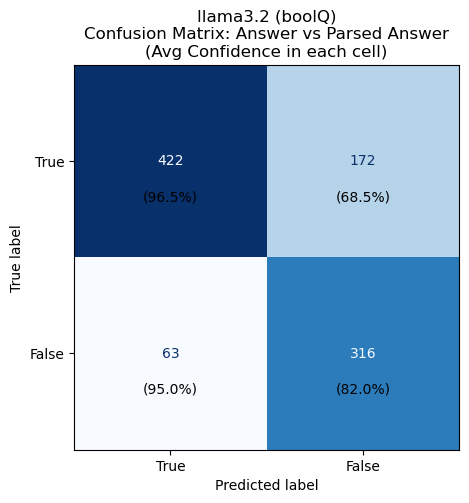

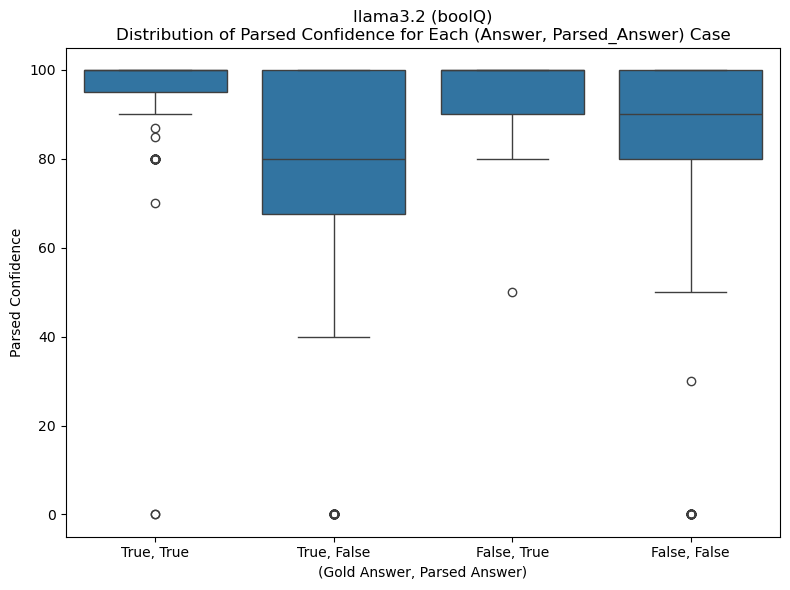

In [12]:
# Confusion matrix with average confidence annotation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import seaborn as sns

labels = ["True", "False"]
cm = confusion_matrix(df_cm_valid_boolq["answer"].astype(str), df_cm_valid_boolq["parsed_answer"].astype(str), labels=labels)

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)

# Annotate with average confidence in brackets, % and a little lower
for i, true_label in enumerate(labels):
    for j, pred_label in enumerate(labels):
        # Convert string labels to boolean for indexing avg_conf
        true_bool = True if true_label == "True" else False
        pred_bool = True if pred_label == "True" else False
        
        # Hard-code the indexing based on position
        try:
            if i == 0 and j == 0:  # True, True
                avg = avg_conf.iloc[1, 1]  # True row, True column
            elif i == 0 and j == 1:  # True, False
                avg = avg_conf.iloc[1, 0]  # True row, False column
            elif i == 1 and j == 0:  # False, True
                avg = avg_conf.iloc[0, 1]  # False row, True column
            else:  # False, False
                avg = avg_conf.iloc[0, 0]  # False row, False column
        except:
            avg = np.nan
            
        # Place confidence a bit lower (y+0.15)
        if not np.isnan(avg):
            ax.text(j, i + 0.15, f"({avg:.1f}%)", va='top', ha='center', color='black', fontsize=10)

plt.title("llama3.2 (boolQ)\nConfusion Matrix: Answer vs Parsed Answer\n(Avg Confidence in each cell)")
plt.savefig("figures/metrics/confidence_elicitation/confusion_matrix_answer_vs_parsed_answer.png")
plt.show()

# Distribution of confidence for all 4 cases
# Create a case column for the boxplot
df_cm_valid_boolq["case"] = df_cm_valid_boolq["answer"].astype(str) + ", " + df_cm_valid_boolq["parsed_answer"].astype(str)

plt.figure(figsize=(8, 6))
sns.boxplot(x="case", y="parsed_confidence", data=df_cm_valid_boolq)
plt.title("llama3.2 (boolQ)\nDistribution of Parsed Confidence for Each (Answer, Parsed_Answer) Case")
plt.xlabel("(Gold Answer, Parsed Answer)")
plt.ylabel("Parsed Confidence")
plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/parsed_confidence_distribution.png")
plt.show()


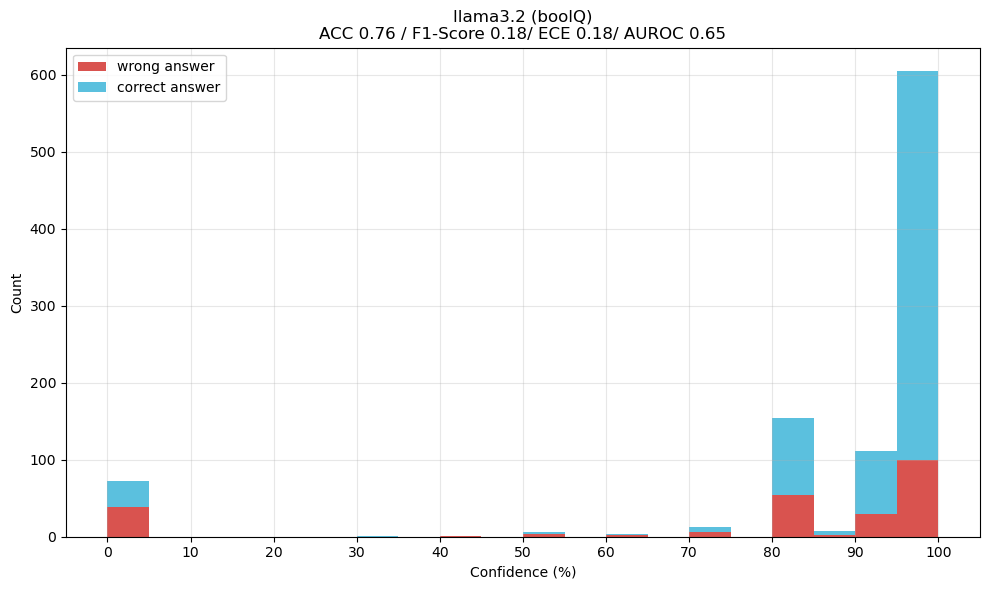

In [13]:
# Calculate f1-score
from sklearn.metrics import f1_score as sklearn_f1_score

f1_val_boolq = sklearn_f1_score(df_cm_valid_boolq["answer"].astype(str), df_cm_valid_boolq["parsed_answer"].astype(str), average="binary", pos_label="True")

# Calculate Expected Calibration Error (ECE) via parsed_confidence column
ece_val_boolq = calculate_ece(df_cm_valid_boolq, confidence_col='parsed_confidence', correct_col='is_correct', n_bins=10)

# Calculate AUROC
auroc_val_boolq = calculate_auroc(df_cm_valid_boolq, confidence_col='parsed_confidence', correct_col='is_correct', plot=False)

# Create more bins with smaller intervals
bins = np.arange(0, 101, 5)  # 5% intervals from 0 to 100

# Use df_cm_valid to define correct and wrong
correct = df_cm_valid_boolq[df_cm_valid_boolq["answer"].astype(str) == df_cm_valid_boolq["parsed_answer"].astype(str)]["parsed_confidence"]
wrong = df_cm_valid_boolq[df_cm_valid_boolq["answer"].astype(str) != df_cm_valid_boolq["parsed_answer"].astype(str)]["parsed_confidence"]

plt.figure(figsize=(10, 6))
plt.hist([wrong, correct], bins=bins, stacked=True, color=["#d9534f", "#5bc0de"], label=["wrong answer", "correct answer"])

plt.xlabel("Confidence (%)")
plt.ylabel("Count")
acc_boolq = (df_cm_valid_boolq["answer"].astype(str) == df_cm_valid_boolq["parsed_answer"].astype(str)).mean()

# Title with ACC and F1-Score
plt.title("llama3.2 (boolQ)\nACC {:.2f} / F1-Score {:.2f}".format(acc_boolq, ece_val_boolq) + "/ ECE {:.2f}".format(ece_val_boolq) + "/ AUROC {:.2f}".format(auroc_val_boolq))
plt.legend(loc="upper left", frameon=True)
plt.xticks(bins[::2])  # Show every other bin label to avoid crowding
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/confidence_distribution_llama3.2.png", dpi=150)
plt.show()

C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\2645217583.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df_cm_valid_boolq.groupby("conf_bin").agg(


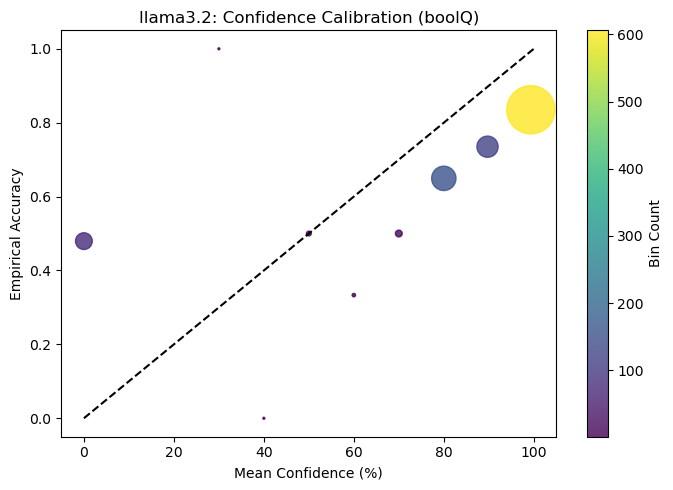

In [14]:
# Confidence calibration plot for llama3.2

# Bin confidence scores into intervals of 10, ensuring 100% is included
conf_bins = np.arange(0, 101, 10)  # Changed to 101 to include 100
df_cm_valid_boolq["conf_bin"] = pd.cut(df_cm_valid_boolq["parsed_confidence"], bins=conf_bins, right=True, include_lowest=True)

# Calculate mean confidence and empirical accuracy for each bin
calib = df_cm_valid_boolq.groupby("conf_bin").agg(
    mean_conf=("parsed_confidence", "mean"),
    accuracy=("answer", lambda x: (x.astype(str) == df_cm_valid_boolq.loc[x.index, "parsed_answer"].astype(str)).mean()),
    count=("parsed_confidence", "count")
).dropna()

plt.figure(figsize=(7, 5))
plt.plot([0, 100], [0, 1], "k--", label="Perfect Calibration")
plt.scatter(calib["mean_conf"], calib["accuracy"], s=calib["count"]*2, c=calib["count"], cmap="viridis", alpha=0.8)
plt.xlabel("Mean Confidence (%)")
plt.ylabel("Empirical Accuracy")
plt.title("llama3.2: Confidence Calibration (boolQ)")
plt.colorbar(label="Bin Count")
plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/confidence_calibration_llama3.2.png")
plt.show()

## Parse TriviaQA output

In [19]:
from parsing_and_evaluation import parse_and_evaluate_trivia

# Example usage for TriviaQA
# Load TriviaQA data (adjust filepath as needed)
df_trivia = pd.read_csv("output/llm_confidence_elicitation/batch_llama_3B/trivia_verbalized_confidence_meta-llama_Llama-3.2-3B-Instruct_llama_batch_3B_1000.csv")

# Parse and evaluate using the modularized function from parsing_and_evaluation.py
df_trivia = parse_and_evaluate_trivia(df_trivia)

# Display results
print("TriviaQA Results:")
print(f"Total samples: {len(df_trivia)}")
print(f"Valid parsed answers: {df_trivia['parsed_answer'].notna().sum()}")
print(f"Valid confidences: {df_trivia['parsed_confidence'].notna().sum()}")
print(f"Accuracy: {df_trivia['is_correct'].mean():.3f}")

# Show first few rows to verify parsing
print("\nFirst few parsed results:")
print(df_trivia[['parsed_answer', 'parsed_confidence', 'is_correct']].head())

# # Example of testing the parser on sample outputs
# test_outputs = [
#     '{"answer": "Paris", "confidence": 95}',
#     'Answer: The Beatles\nConfidence: 88',
#     'The answer is William Shakespeare.',
#     'Paris, France',
#     '?'
# ]

# print("Testing TriviaQA parser:")
# for i, output in enumerate(test_outputs):
#     result = parse_trivia_output(output)
#     print(f"Output {i+1}: {output}")
#     print(f"  Parsed: {result}")
#     print()

TriviaQA Results:
Total samples: 1000
Valid parsed answers: 1000
Valid confidences: 994
Accuracy: 0.498

First few parsed results:
      parsed_answer  parsed_confidence  is_correct
0            square               80.0       False
1  the blind beggar              100.0        True
2   the ritz london              100.0       False
3         greyhound              100.0        True
4             angie                0.0       False


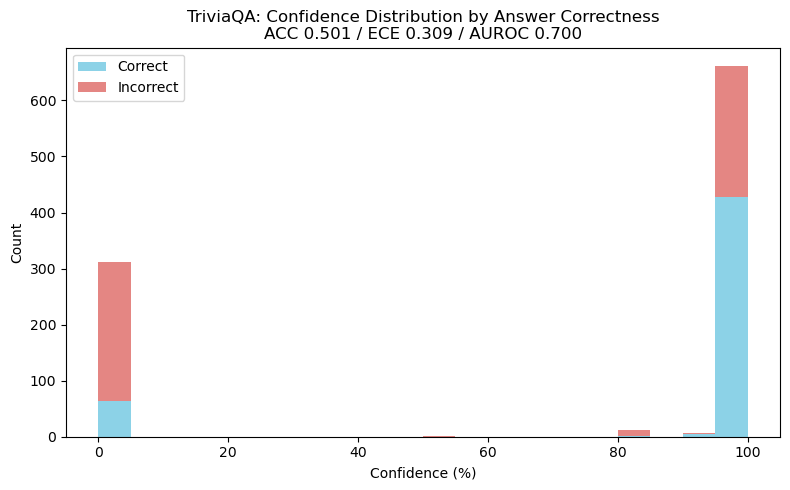

C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\4114795629.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_correct", y="parsed_confidence", data=df_trivia_valid, palette=["#d9534f", "#5bc0de"])


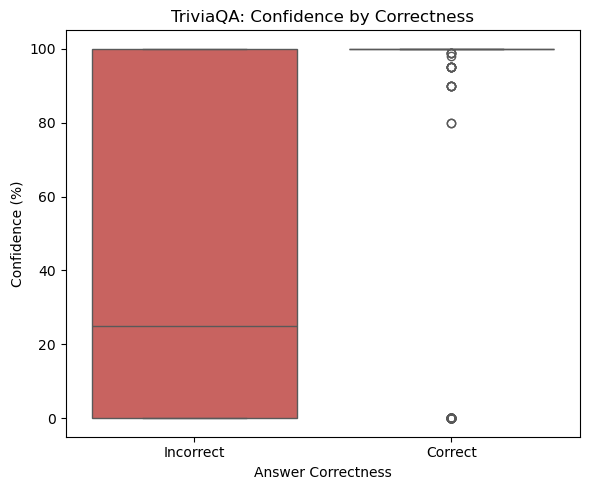

C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\4114795629.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trivia_valid["conf_bin"] = pd.cut(df_trivia_valid["parsed_confidence"], bins=conf_bins, right=False)
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\4114795629.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df_trivia_valid.groupby("conf_bin").agg(


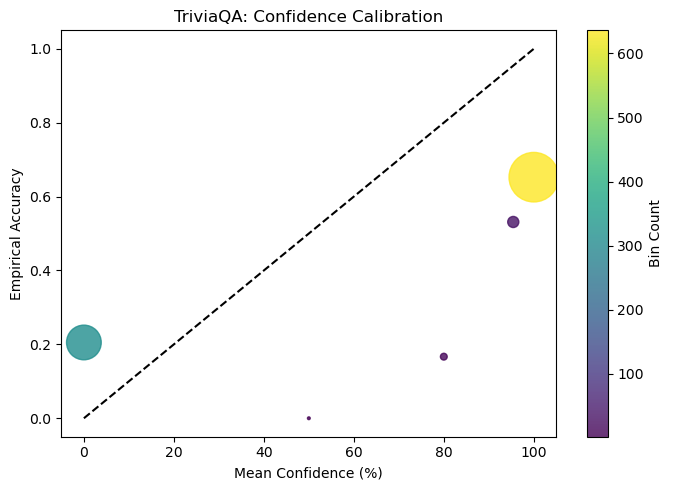

In [20]:
import seaborn as sns
import numpy as np
import os

import matplotlib.pyplot as plt

# Ensure output directory exists
os.makedirs("figures/metrics/confidence_elicitation", exist_ok=True)

# Filter valid rows for plotting
df_trivia_valid = df_trivia.dropna(subset=["parsed_confidence", "is_correct"])

# Calculate ECE and AUROC for TriviaQA
ece_trivia = calculate_ece(df_trivia_valid, confidence_col='parsed_confidence', correct_col='is_correct', n_bins=10)
auroc_trivia = calculate_auroc(df_trivia_valid, confidence_col='parsed_confidence', correct_col='is_correct', plot=False)

# 1. Histogram: Confidence distribution for correct vs. incorrect answers
plt.figure(figsize=(8, 5))
bins = np.arange(0, 105, 5)
plt.hist(
    [df_trivia_valid[df_trivia_valid["is_correct"]]["parsed_confidence"],
     df_trivia_valid[~df_trivia_valid["is_correct"]]["parsed_confidence"]],
    bins=bins,
    label=["Correct", "Incorrect"],
    color=["#5bc0de", "#d9534f"],
    alpha=0.7,
    stacked=True
)
plt.xlabel("Confidence (%)")
plt.ylabel("Count")
plt.title(f"TriviaQA: Confidence Distribution by Answer Correctness\nACC {df_trivia_valid['is_correct'].mean():.3f} / ECE {ece_trivia:.3f} / AUROC {auroc_trivia:.3f}")
plt.legend()
plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/trivia_confidence_hist.png")
plt.show()

# 2. Boxplot: Confidence by correctness
plt.figure(figsize=(6, 5))
sns.boxplot(x="is_correct", y="parsed_confidence", data=df_trivia_valid, palette=["#d9534f", "#5bc0de"])
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.xlabel("Answer Correctness")
plt.ylabel("Confidence (%)")
plt.title("TriviaQA: Confidence by Correctness")
plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/trivia_confidence_boxplot.png")
plt.show()
# 3. Calibration plot: Confidence bins vs. empirical accuracy
conf_bins = np.arange(0, 111, 10)  # Changed to 111 to include 100%
df_trivia_valid["conf_bin"] = pd.cut(df_trivia_valid["parsed_confidence"], bins=conf_bins, right=False)
calib = df_trivia_valid.groupby("conf_bin").agg(
    mean_conf=("parsed_confidence", "mean"),
    accuracy=("is_correct", "mean"),
    count=("is_correct", "count")
).dropna()

plt.figure(figsize=(7, 5))
plt.plot([0, 100], [0, 1], "k--", label="Perfect Calibration")
plt.scatter(calib["mean_conf"], calib["accuracy"], s=calib["count"]*2, c=calib["count"], cmap="viridis", alpha=0.8)
plt.xlabel("Mean Confidence (%)")
plt.ylabel("Empirical Accuracy")
plt.title("TriviaQA: Confidence Calibration")
plt.colorbar(label="Bin Count")
plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/trivia_confidence_calibration.png")
plt.show()


## Parse SQuAD output

In [16]:
from parsing_and_evaluation import parse_and_evaluate_squad

# Load SQuAD data (adjust filepath as needed)
try:
    df_squad = pd.read_csv("output/llm_confidence_elicitation/batch_llama_3B/squad_verbalized_confidence_meta-llama_Llama-3.2-3B-Instruct_llama_batch_3B_1000.csv")
    
    # Parse and evaluate using the modularized function from parsing_and_evaluation.py
    # Option 1: Keep unanswerable questions
    df_squad_all = parse_and_evaluate_squad(df_squad.copy(), remove_unanswerable=False)
    
    # Drop rows with NaN in parsed_confidence or is_correct for valid evaluation
    df_squad_all_valid = df_squad_all.dropna(subset=["parsed_confidence", "is_correct"])
    
    # Option 2: Remove unanswerable questions
    df_squad_answerable = parse_and_evaluate_squad(df_squad.copy(), remove_unanswerable=True)

    # Drop rows with NaN in parsed_confidence or is_correct for valid evaluation
    df_squad_answerable_valid = df_squad_answerable.dropna(subset=["parsed_confidence", "is_correct"])
    
    # Display results for both versions
    print("=== SQuAD Results (All Questions) ===")
    print(f"Total samples: {len(df_squad_all)}")
    print(f"Total samples (valid): {len(df_squad_all_valid)}")
    print(f"Valid parsed answers: {df_squad_all['parsed_answer'].notna().sum()}")
    print(f"Valid confidences: {df_squad_all['parsed_confidence'].notna().sum()}")
    print(f"Accuracy (of valid answers): {df_squad_all_valid['is_correct'].mean():.3f}")
    
    if 'is_impossible' in df_squad_all.columns:
        unanswerable_count = (df_squad_all['is_impossible'] == True).sum()
        print(f"Unanswerable questions: {unanswerable_count}")
    
    print("\n=== SQuAD Results (Answerable Questions Only) ===")
    print(f"Total samples: {len(df_squad_answerable)}")
    print(f"Total samples (valid): {len(df_squad_answerable_valid)}")
    print(f"Valid parsed answers: {df_squad_answerable['parsed_answer'].notna().sum()}")
    print(f"Valid confidences: {df_squad_answerable['parsed_confidence'].notna().sum()}")
    print(f"Accuracy (of valid answers): {df_squad_answerable_valid['is_correct'].mean():.3f}")
    
    # Show first few rows to verify parsing
    print("\nFirst few parsed results (all questions):")
    print(df_squad_all[['parsed_answer', 'parsed_confidence', 'is_correct']].head())
    
except FileNotFoundError as e:
    print(f"SQuAD file not found: {e}")
    print("Please check the file path. Expected file:")
    print("output/llm_confidence_elicitation/batch_llama_3B/squad_verbalized_confidence_meta-llama_Llama-3.2-3B-Instruct_llama_batch_3B_1000.csv")
except Exception as e:
    print(f"Error loading SQuAD data: {e}")
    
    # Create a demo with sample data if file not found
    print("\nCreating demo SQuAD analysis with sample data...")
    
    # Sample SQuAD data for demonstration
    sample_data = {
        'model_output': [
            '{"answer": "Paris", "confidence": 90}',
            'Answer: The Beatles\nConfidence: 85',
            '{"answer": "", "confidence": 95}',  # Unanswerable
            'Answer: William Shakespeare\nConfidence: 88'
        ],
        'answers': [
            "['Paris']",
            "['Beatles', 'The Beatles']", 
            "['']",  # Unanswerable
            "['William Shakespeare', 'Shakespeare']"
        ],
        'is_impossible': [False, False, True, False]
    }
    
    df_squad_demo = pd.DataFrame(sample_data)
    df_squad_demo_parsed = parse_and_evaluate_squad(df_squad_demo, remove_unanswerable=False)
    
    print("Demo SQuAD parsing results:")
    print(df_squad_demo_parsed[['model_output', 'parsed_answer', 'parsed_confidence', 'is_correct', 'is_impossible']])

Removed 362 unanswerable questions. 638 questions remaining.
=== SQuAD Results (All Questions) ===
Total samples: 1000
Total samples (valid): 1000
Valid parsed answers: 1000
Valid confidences: 1000
Accuracy (of valid answers): 0.554
Unanswerable questions: 362

=== SQuAD Results (Answerable Questions Only) ===
Total samples: 638
Total samples (valid): 638
Valid parsed answers: 638
Valid confidences: 638
Accuracy (of valid answers): 0.868

First few parsed results (all questions):
  parsed_answer  parsed_confidence  is_correct
0        the eu                100       False
1         wi-fi                100        True
2         sweep                 80       False
3          1604                100        True
4      mp3 file                100        True



=== All Questions Analysis ===
Valid samples: 1000
Accuracy: 0.554
Average confidence: 93.6


C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\3579501288.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_correct", y="parsed_confidence", data=df_squad_valid,
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\3579501288.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(["Incorrect", "Correct"])
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\3579501288.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df_squad_valid.groupby("conf_bin").agg(


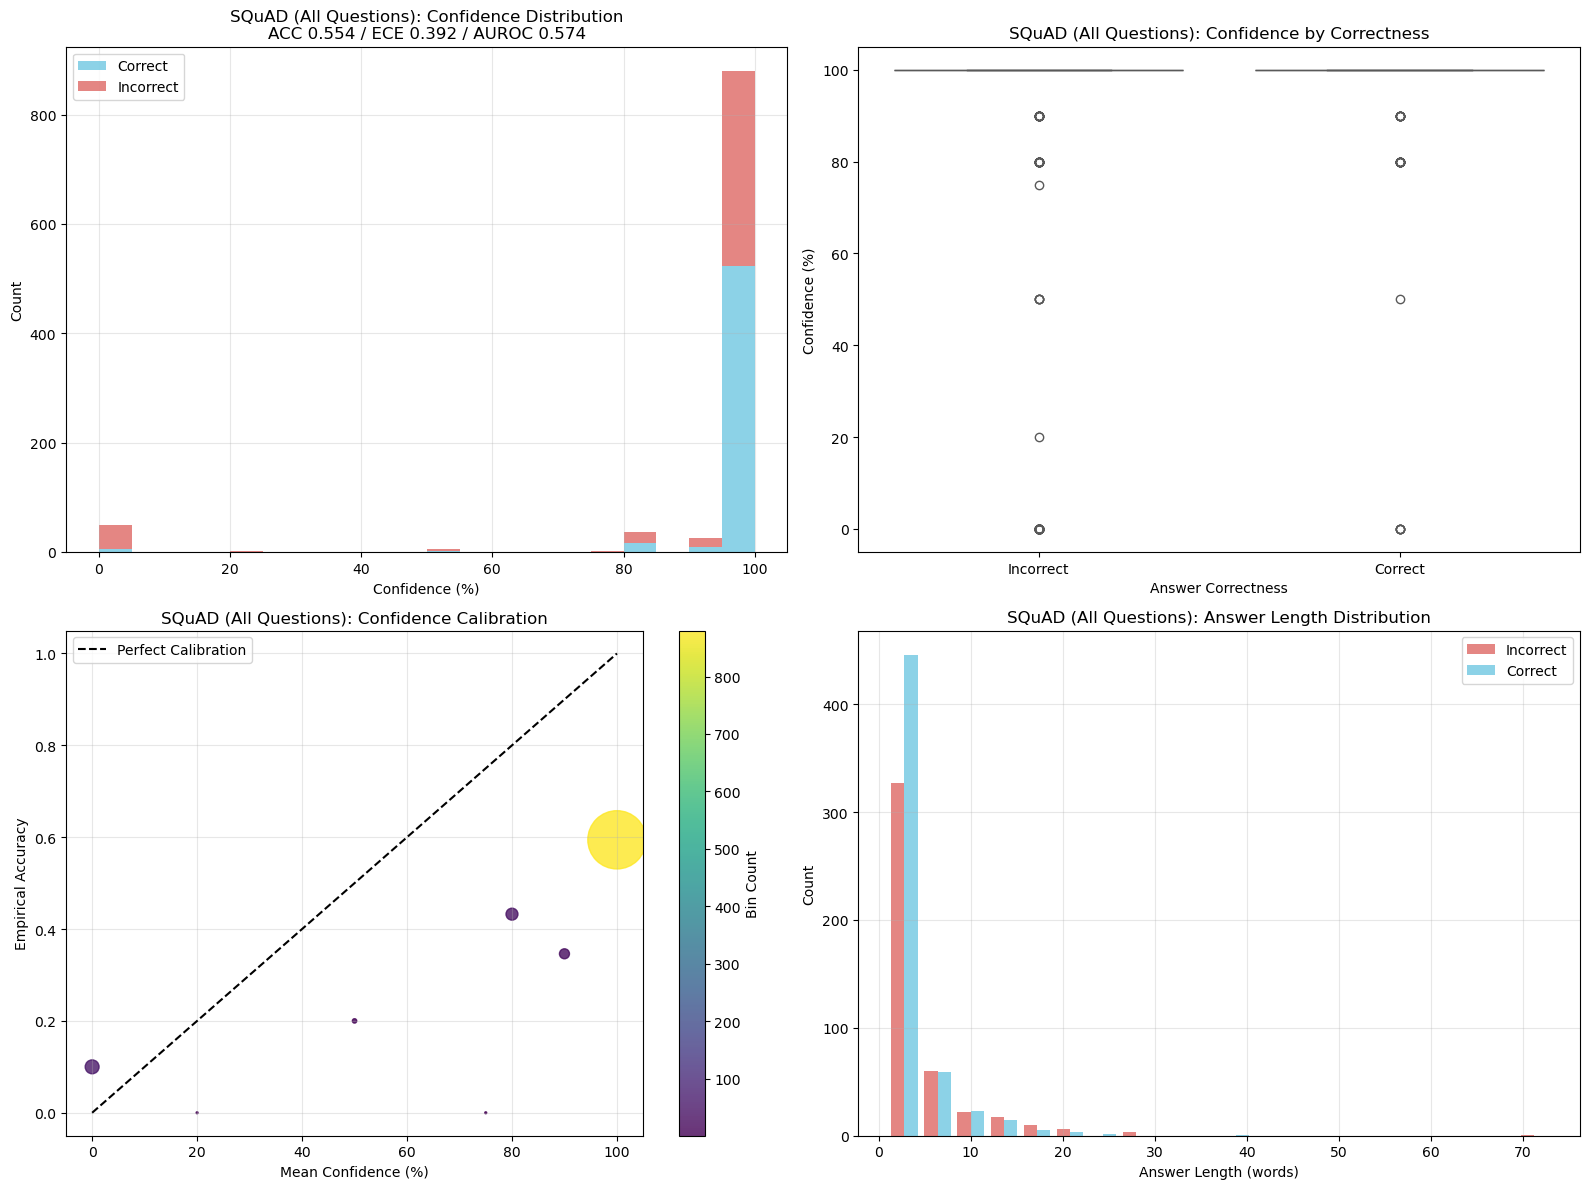


=== Sample All Questions Results ===
Correct predictions:
Q: what type of technology is used to connect to the internet wirelessly? 
Gold: ['wireless Ethernet (wi-fi)'] | Pred: 'wi-fi' | Conf: 100

Q: When did England first establish a colony in Guiana?
Gold: ['1604'] | Pred: '1604' | Conf: 100

Q: What would an example of lossy audio encoding be?
Gold: ['creating an MP3 file'] | Pred: 'mp3 file' | Conf: 100

Incorrect predictions:
Q: What's another thing the paper showed hostility to?
Gold: ['promotion of right-wing ministers to the cabinet'] | Pred: 'the eu' | Conf: 100

Q: What is one of the important functions of the OCA in dealing with attacks? 
Gold: ['suppression/destruction of enemy air defense'] | Pred: 'sweep' | Conf: 80

Q: How do genes encode multiple proteins?
Gold: ['by alternative splicing and coding sequences'] | Pred: 'through alternative splicing and coding sequences split in short sections across the genome that are concatenated by trans-splicing' | Conf: 100


=== 

C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\3579501288.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_correct", y="parsed_confidence", data=df_squad_valid,
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\3579501288.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(["Incorrect", "Correct"])
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\3579501288.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df_squad_valid.groupby("conf_bin").agg(


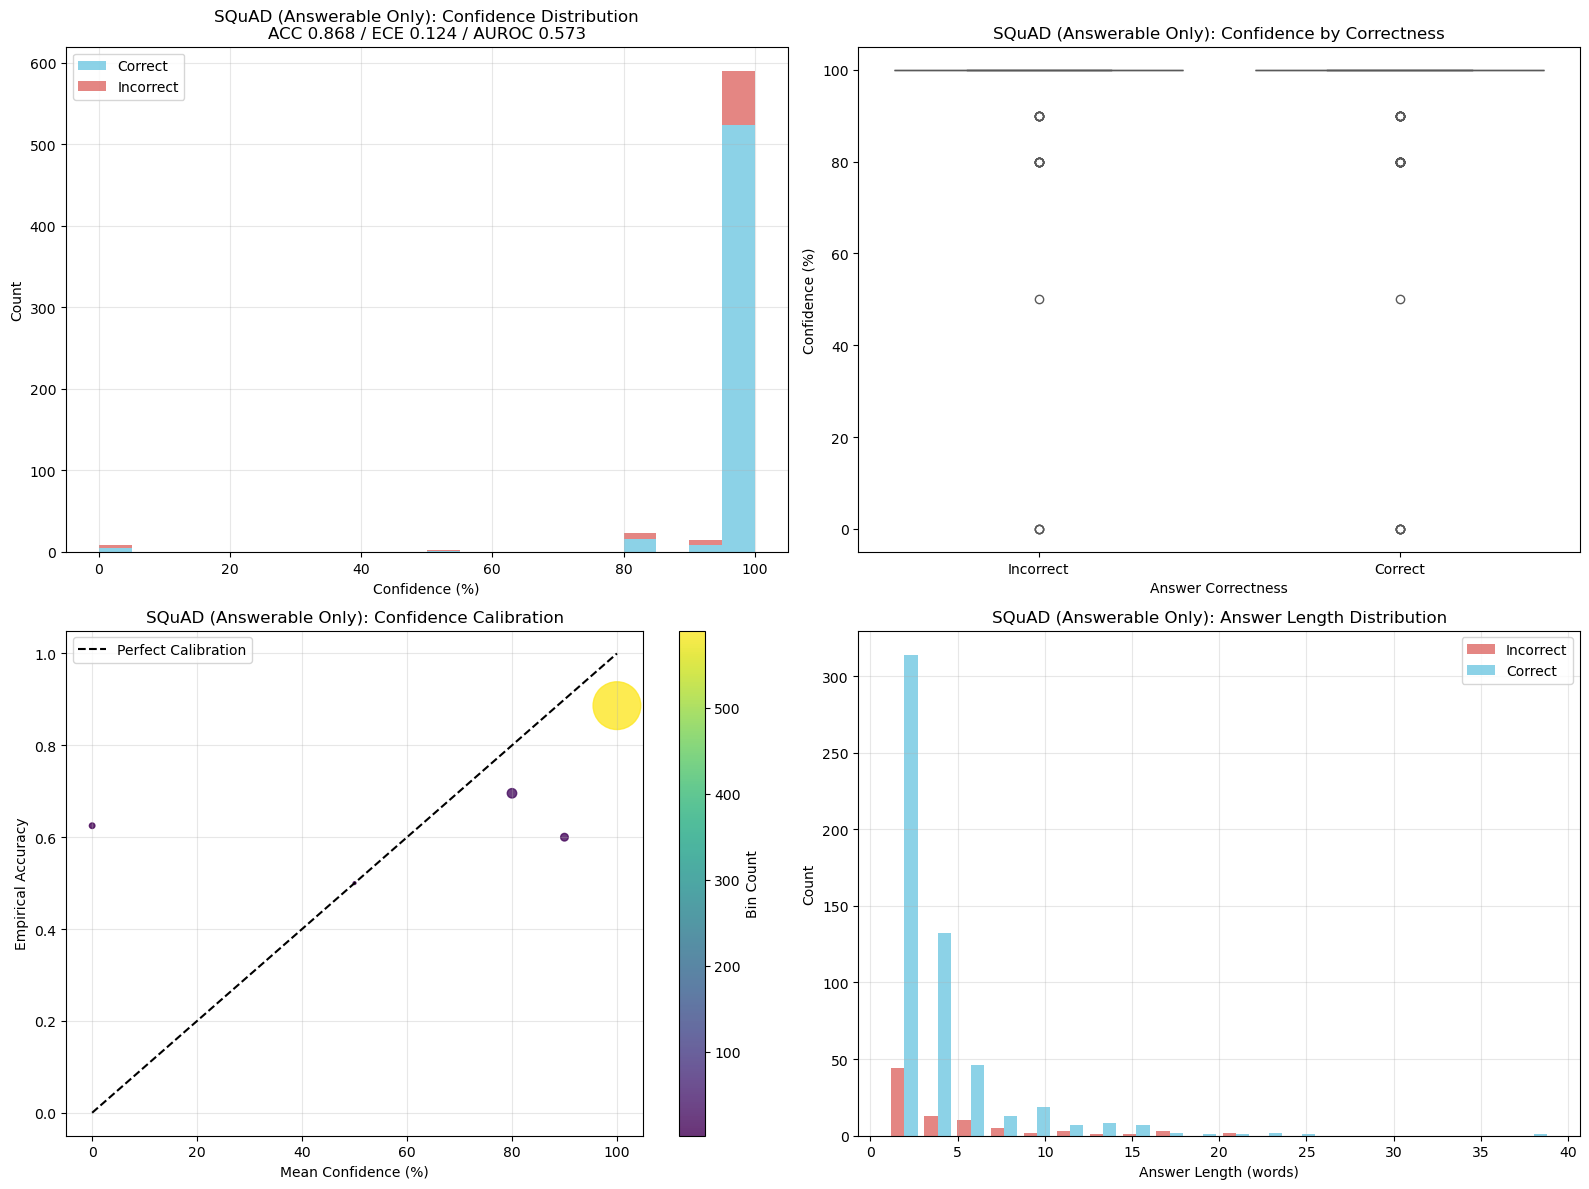


=== Sample Answerable Only Results ===
Correct predictions:
Q: what type of technology is used to connect to the internet wirelessly? 
Gold: ['wireless Ethernet (wi-fi)'] | Pred: 'wi-fi' | Conf: 100

Q: When did England first establish a colony in Guiana?
Gold: ['1604'] | Pred: '1604' | Conf: 100

Q: What would an example of lossy audio encoding be?
Gold: ['creating an MP3 file'] | Pred: 'mp3 file' | Conf: 100

Incorrect predictions:
Q: What's another thing the paper showed hostility to?
Gold: ['promotion of right-wing ministers to the cabinet'] | Pred: 'the eu' | Conf: 100

Q: What is one of the important functions of the OCA in dealing with attacks? 
Gold: ['suppression/destruction of enemy air defense'] | Pred: 'sweep' | Conf: 80

Q: How do genes encode multiple proteins?
Gold: ['by alternative splicing and coding sequences'] | Pred: 'through alternative splicing and coding sequences split in short sections across the genome that are concatenated by trans-splicing' | Conf: 100



In [17]:
# SQuAD Analysis and Visualization
if 'df_squad_all' in locals():
    import seaborn as sns
    import numpy as np
    import os
    import matplotlib.pyplot as plt

    # Ensure output directory exists
    os.makedirs("figures/metrics/confidence_elicitation", exist_ok=True)
    
    # Analyze both versions (all questions vs answerable only)
    datasets = {
        'All Questions': df_squad_all,
        'Answerable Only': df_squad_answerable
    }

    # Create list for squad ece and auroc scores
    squad_ece_scores = []
    squad_auroc_scores = []
    
    for dataset_name, df_squad_current in datasets.items():
        print(f"\n=== {dataset_name} Analysis ===")
        
        # Filter valid rows for plotting
        df_squad_valid = df_squad_current.dropna(subset=["parsed_confidence", "is_correct"])
        
        if len(df_squad_valid) == 0:
            print(f"No valid results for {dataset_name}!")
            continue
            
        print(f"Valid samples: {len(df_squad_valid)}")
        print(f"Accuracy: {df_squad_valid['is_correct'].mean():.3f}")
        print(f"Average confidence: {df_squad_valid['parsed_confidence'].mean():.1f}")

        # Calculate ECE for SQuAD
        ece_squad = calculate_ece(df_squad_valid, confidence_col='parsed_confidence', correct_col='is_correct', n_bins=10)
        squad_ece_scores.append((dataset_name, ece_squad))

        # Calculate AUROC for SQuAD
        auroc_squad = calculate_auroc(df_squad_valid, confidence_col='parsed_confidence', correct_col='is_correct', plot=False)
        squad_auroc_scores.append((dataset_name, auroc_squad))
        
        # Create visualizations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Histogram: Confidence distribution for correct vs. incorrect answers
        bins = np.arange(0, 105, 5)
        ax1.hist(
            [df_squad_valid[df_squad_valid["is_correct"]]["parsed_confidence"],
             df_squad_valid[~df_squad_valid["is_correct"]]["parsed_confidence"]],
            bins=bins,
            label=["Correct", "Incorrect"],
            color=["#5bc0de", "#d9534f"],
            alpha=0.7,
            stacked=True
        )
        ax1.set_xlabel("Confidence (%)")
        ax1.set_ylabel("Count")
        ax1.set_title(f"SQuAD ({dataset_name}): Confidence Distribution\nACC {df_squad_valid['is_correct'].mean():.3f} / ECE {ece_squad:.3f} / AUROC {auroc_squad:.3f}")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Boxplot: Confidence by correctness
        sns.boxplot(x="is_correct", y="parsed_confidence", data=df_squad_valid, 
                   palette=["#d9534f", "#5bc0de"], ax=ax2)
        ax2.set_xticklabels(["Incorrect", "Correct"])
        ax2.set_xlabel("Answer Correctness")
        ax2.set_ylabel("Confidence (%)")
        ax2.set_title(f"SQuAD ({dataset_name}): Confidence by Correctness")
        
        # 3. Calibration plot: Confidence bins vs. empirical accuracy
        conf_bins = np.arange(0, 111, 10)
        df_squad_valid["conf_bin"] = pd.cut(df_squad_valid["parsed_confidence"], bins=conf_bins, right=False)
        calib = df_squad_valid.groupby("conf_bin").agg(
            mean_conf=("parsed_confidence", "mean"),
            accuracy=("is_correct", "mean"),
            count=("is_correct", "count")
        ).dropna()
        
        ax3.plot([0, 100], [0, 1], "k--", label="Perfect Calibration")
        scatter = ax3.scatter(calib["mean_conf"], calib["accuracy"], 
                            s=calib["count"]*2, c=calib["count"], cmap="viridis", alpha=0.8)
        ax3.set_xlabel("Mean Confidence (%)")
        ax3.set_ylabel("Empirical Accuracy")
        ax3.set_title(f"SQuAD ({dataset_name}): Confidence Calibration")
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax3, label="Bin Count")
        
        # 4. Answer length distribution
        if 'parsed_answer' in df_squad_valid.columns:
            answer_lengths = df_squad_valid['parsed_answer'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
            correct_lengths = answer_lengths[df_squad_valid['is_correct']]
            incorrect_lengths = answer_lengths[~df_squad_valid['is_correct']]
            
            ax4.hist([incorrect_lengths, correct_lengths], bins=20, alpha=0.7, 
                    label=['Incorrect', 'Correct'], color=['#d9534f', '#5bc0de'])
            ax4.set_xlabel("Answer Length (words)")
            ax4.set_ylabel("Count")
            ax4.set_title(f"SQuAD ({dataset_name}): Answer Length Distribution")
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure
        filename_suffix = "all" if "All" in dataset_name else "answerable"
        plt.savefig(f"figures/metrics/confidence_elicitation/squad_{filename_suffix}_analysis.png", dpi=150)
        plt.show()
        
        # Show some examples
        if len(df_squad_valid) > 0:
            print(f"\n=== Sample {dataset_name} Results ===")
            print("Correct predictions:")
            correct_samples = df_squad_valid[df_squad_valid['is_correct']].head(3)
            for _, row in correct_samples.iterrows():
                question = row.get('question', 'N/A')[:80] + "..." if len(str(row.get('question', ''))) > 80 else row.get('question', 'N/A')
                print(f"Q: {question}")
                print(f"Gold: {row.get('answers', 'N/A')} | Pred: '{row['parsed_answer']}' | Conf: {row['parsed_confidence']}")
                print()
            
            print("Incorrect predictions:")
            wrong_samples = df_squad_valid[~df_squad_valid['is_correct']].head(3)
            for _, row in wrong_samples.iterrows():
                question = row.get('question', 'N/A')[:80] + "..." if len(str(row.get('question', ''))) > 80 else row.get('question', 'N/A')
                print(f"Q: {question}")
                print(f"Gold: {row.get('answers', 'N/A')} | Pred: '{row['parsed_answer']}' | Conf: {row['parsed_confidence']}")
                print()

else:
    print("SQuAD data not loaded. Run the previous cell first.")

=== CROSS-DATASET PERFORMANCE COMPARISON ===

Performance Summary:
BoolQ              | ACC: 0.758 | Conf:  86.8 | Parse: 0.973 | ECE: 0.183 | AUROC: 0.646 | Samples: 973/1000
TriviaQA           | ACC: 0.501 | Conf:  68.1 | Parse: 0.994 | ECE: 0.309 | AUROC: 0.700 | Samples: 994/1000
SQuAD (All)        | ACC: 0.554 | Conf:  93.6 | Parse: 1.000 | ECE: 0.392 | AUROC: 0.574 | Samples: 1000/1000
SQuAD (Answerable) | ACC: 0.868 | Conf:  97.6 | Parse: 1.000 | ECE: 0.124 | AUROC: 0.573 | Samples: 638/638


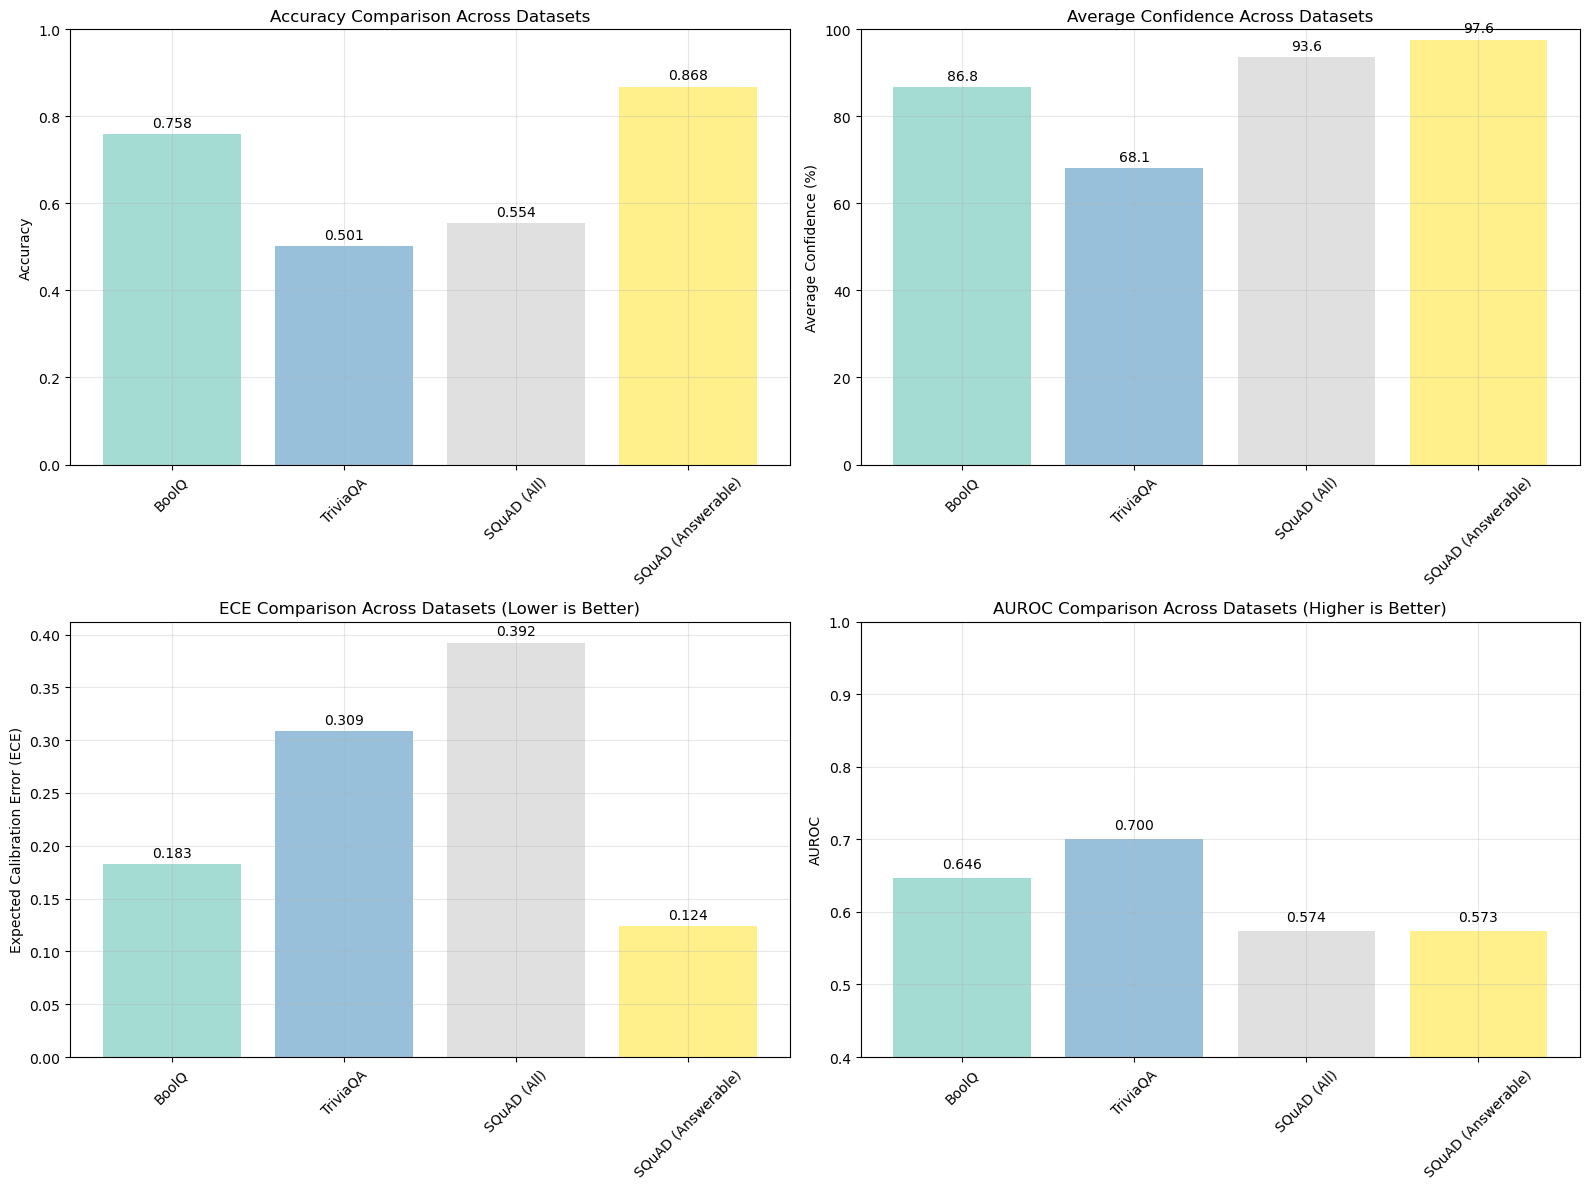


💡 Key Insights:
- Highest accuracy: SQuAD (Answerable) (0.868)
- Highest confidence: SQuAD (Answerable) (97.6%)
- Best calibration (lowest ECE): SQuAD (Answerable) (0.124)
- Best confidence discrimination (highest AUROC): TriviaQA (0.700)
- Confidence-accuracy alignment:
  BoolQ             : 0.109 (lower is better)
  TriviaQA          : 0.180 (lower is better)
  SQuAD (All)       : 0.382 (lower is better)
  SQuAD (Answerable): 0.108 (lower is better)


In [21]:
# Cross-Dataset Comparison: BoolQ vs TriviaQA vs SQuAD
print("=== CROSS-DATASET PERFORMANCE COMPARISON ===")
print()

# Collect metrics from all datasets
comparison_data = []

# BoolQ (if available)
if 'results_df_boolq' in locals():
    boolq_valid = results_df_boolq.dropna(subset=["parsed_answer", "parsed_confidence", "is_correct"])
    comparison_data.append({
        'Dataset': 'BoolQ',
        'Total Samples': len(results_df_boolq),
        'Valid Samples': len(boolq_valid),
        'Accuracy': boolq_valid['is_correct'].mean(),
        'Avg Confidence': boolq_valid['parsed_confidence'].mean(),
        'Valid Parse Rate': len(boolq_valid) / len(results_df_boolq),
        'ECE': ece_val_boolq if 'ece_val_boolq' in locals() else None,
        'AUROC': auroc_val_boolq
    })

# TriviaQA (if available)
if 'df_trivia_valid' in locals():
    comparison_data.append({
        'Dataset': 'TriviaQA',
        'Total Samples': len(df_trivia),
        'Valid Samples': len(df_trivia_valid),
        'Accuracy': df_trivia_valid['is_correct'].mean(),
        'Avg Confidence': df_trivia_valid['parsed_confidence'].mean(),
        'Valid Parse Rate': len(df_trivia_valid) / len(df_trivia),
        'ECE': ece_trivia if 'ece_trivia' in locals() else None,
        'AUROC': auroc_trivia
    })

# SQuAD All (if available)
if 'df_squad_all_valid' in locals():
    comparison_data.append({
        'Dataset': 'SQuAD (All)',
        'Total Samples': len(df_squad_all),
        'Valid Samples': len(df_squad_all_valid),
        'Accuracy': df_squad_all_valid['is_correct'].mean(),
        'Avg Confidence': df_squad_all_valid['parsed_confidence'].mean(),
        'Valid Parse Rate': len(df_squad_all_valid) / len(df_squad_all),
        'ECE': squad_ece_scores[0][1] if 'squad_ece_scores' in locals() else None,
        'AUROC': squad_auroc_scores[0][1] if 'squad_auroc_scores' in locals() else None
    })

# SQuAD Answerable (if available)
if 'df_squad_answerable_valid' in locals():
    comparison_data.append({
        'Dataset': 'SQuAD (Answerable)',
        'Total Samples': len(df_squad_answerable),
        'Valid Samples': len(df_squad_answerable_valid),
        'Accuracy': df_squad_answerable_valid['is_correct'].mean(),
        'Avg Confidence': df_squad_answerable_valid['parsed_confidence'].mean(),
        'Valid Parse Rate': len(df_squad_answerable_valid) / len(df_squad_answerable),
        'ECE': squad_ece_scores[1][1] if 'squad_ece_scores' in locals() else None,
        'AUROC': squad_auroc_scores[1][1] if 'squad_auroc_scores' in locals() else None
    })

# Create comparison DataFrame
if comparison_data:
    df_comparison = pd.DataFrame(comparison_data)
    
    print("Performance Summary:")
    print("=" * 100)
    for _, row in df_comparison.iterrows():
        ece_str = f"{row['ECE']:.3f}" if row['ECE'] is not None else "N/A"
        auroc_str = f"{row['AUROC']:.3f}" if row['AUROC'] is not None else "N/A"
        print(f"{row['Dataset']:18} | ACC: {row['Accuracy']:.3f} | "
              f"Conf: {row['Avg Confidence']:5.1f} | "
              f"Parse: {row['Valid Parse Rate']:.3f} | "
              f"ECE: {ece_str:5} | AUROC: {auroc_str:5} | "
              f"Samples: {row['Valid Samples']}/{row['Total Samples']}")
    
    # Visualization
    if len(comparison_data) > 1:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        datasets = df_comparison['Dataset']
        colors = plt.cm.Set3(np.linspace(0, 1, len(datasets)))
        
        # Accuracy comparison
        accuracies = df_comparison['Accuracy']
        bars1 = ax1.bar(datasets, accuracies, color=colors, alpha=0.8)
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Accuracy Comparison Across Datasets')
        ax1.set_ylim(0, 1)
        ax1.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, acc in zip(bars1, accuracies):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom')
        
        # Confidence comparison
        confidences = df_comparison['Avg Confidence']
        bars2 = ax2.bar(datasets, confidences, color=colors, alpha=0.8)
        ax2.set_ylabel('Average Confidence (%)')
        ax2.set_title('Average Confidence Across Datasets')
        ax2.set_ylim(0, 100)
        ax2.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, conf in zip(bars2, confidences):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{conf:.1f}', ha='center', va='bottom')
        
        # ECE comparison
        ece_values = [val for val in df_comparison['ECE'] if val is not None]
        ece_datasets = [ds for ds, val in zip(datasets, df_comparison['ECE']) if val is not None]
        ece_colors = [color for color, val in zip(colors, df_comparison['ECE']) if val is not None]
        
        if ece_values:
            bars3 = ax3.bar(ece_datasets, ece_values, color=ece_colors, alpha=0.8)
            ax3.set_ylabel('Expected Calibration Error (ECE)')
            ax3.set_title('ECE Comparison Across Datasets (Lower is Better)')
            ax3.grid(True, alpha=0.3)
            
            # Add value labels on bars
            for bar, ece in zip(bars3, ece_values):
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2., height + max(ece_values)*0.01,
                        f'{ece:.3f}', ha='center', va='bottom')
        
        # AUROC comparison
        auroc_values = [val for val in df_comparison['AUROC'] if val is not None]
        auroc_datasets = [ds for ds, val in zip(datasets, df_comparison['AUROC']) if val is not None]
        auroc_colors = [color for color, val in zip(colors, df_comparison['AUROC']) if val is not None]
        
        if auroc_values:
            bars4 = ax4.bar(auroc_datasets, auroc_values, color=auroc_colors, alpha=0.8)
            ax4.set_ylabel('AUROC')
            ax4.set_title('AUROC Comparison Across Datasets (Higher is Better)')
            ax4.set_ylim(0.4, 1.0)
            ax4.grid(True, alpha=0.3)
            
            # Add value labels on bars
            for bar, auroc in zip(bars4, auroc_values):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{auroc:.3f}', ha='center', va='bottom')
        
        # Rotate x-axis labels if needed
        for ax in [ax1, ax2, ax3, ax4]:
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig("figures/metrics/confidence_elicitation/dataset_comparison.png", dpi=150)
        plt.show()
        
        print(f"\n💡 Key Insights:")
        best_acc_idx = df_comparison['Accuracy'].idxmax()
        best_conf_idx = df_comparison['Avg Confidence'].idxmax()
        print(f"- Highest accuracy: {df_comparison.loc[best_acc_idx, 'Dataset']} ({df_comparison.loc[best_acc_idx, 'Accuracy']:.3f})")
        print(f"- Highest confidence: {df_comparison.loc[best_conf_idx, 'Dataset']} ({df_comparison.loc[best_conf_idx, 'Avg Confidence']:.1f}%)")
        
        # ECE and AUROC insights
        if any(df_comparison['ECE'].notna()):
            best_ece_idx = df_comparison['ECE'].idxmin()
            print(f"- Best calibration (lowest ECE): {df_comparison.loc[best_ece_idx, 'Dataset']} ({df_comparison.loc[best_ece_idx, 'ECE']:.3f})")
        
        if any(df_comparison['AUROC'].notna()):
            best_auroc_idx = df_comparison['AUROC'].idxmax()
            print(f"- Best confidence discrimination (highest AUROC): {df_comparison.loc[best_auroc_idx, 'Dataset']} ({df_comparison.loc[best_auroc_idx, 'AUROC']:.3f})")
        
        # Calculate confidence-accuracy alignment
        print("- Confidence-accuracy alignment:")
        for _, row in df_comparison.iterrows():
            alignment = abs(row['Accuracy'] - row['Avg Confidence']/100)
            print(f"  {row['Dataset']:18}: {alignment:.3f} (lower is better)")
    
else:
    print("No datasets available for comparison. Please run the parsing cells first.")

# Multiple Sampels per Answer from single decoding

## BoolQ

In [31]:
import pandas as pd
from parsing_and_evaluation import parse_aggregate_evaluate_boolq_multi, parse_and_evaluate_boolq_multi, aggregate_confidence_boolq, evaluate_boolq_aggregated, normalize_boolq_multi

# ───────────────────────────────
# 0. Load Data
# ───────────────────────────────
df_boolq_multi = pd.read_csv("output/llm_confidence_elicitation/verbalized_confidence_multi_model/boolq_llama_k5_topk_500_full.csv")

# ───────────────────────────────
# Complete Pipeline: Parse, Aggregate, and Evaluate
# ───────────────────────────────
df_parsed_boolq_agg, df_agg_boolq_agg, eval_df_boolq_agg, acc_boolq_agg = parse_aggregate_evaluate_boolq_multi(df_boolq_multi, group_col="question_id")

print(f"✅ Multi-Sample BoolQ Results (Modularized):")
print(f"   - Total samples: {len(df_boolq_multi)}")
print(f"   - Unique questions: {df_boolq_multi['question_id'].nunique()}")
print(f"   - Valid parsed samples: {df_parsed_boolq_agg['parsed_answer'].notna().sum()}")
print(f"   - Aggregated accuracy: {acc:.2%}")

# Show first few results
print(f"\nFirst few aggregated results:")
eval_df_boolq_agg.head()


✅ Multi-Sample BoolQ Results (Modularized):
   - Total samples: 2500
   - Unique questions: 500
   - Valid parsed samples: 1957
   - Aggregated accuracy: 86.83%

First few aggregated results:


,question_id,agg_answer,agg_confidence,answer,answer_norm,is_correct
0,0,true,100.000000,True,true,True
1,1,true,100.000000,True,true,True
2,2,true,100.000000,True,true,True
3,3,true,100.000000,True,true,True
4,4,true,64.285714,True,true,True


In [32]:
# Alternative: Step-by-step usage of modularized functions
print("=== STEP-BY-STEP MULTI-SAMPLE BOOLQ PROCESSING ===")
print()

# Step 1: Parse individual outputs (if needed)
print("Step 1: Parsing individual model outputs...")
df_step1 = parse_and_evaluate_boolq_multi(df_boolq_multi.copy(), group_col="question_id")
print(f"   ✅ Parsed {df_step1['parsed_answer'].notna().sum()} valid answers")

# Step 2: Aggregate by confidence-weighted voting
print("\nStep 2: Aggregating with confidence-weighted voting...")
df_step2 = aggregate_confidence_boolq(df_step1, group_col="question_id")
print(f"   ✅ Aggregated {len(df_step2)} unique questions")
print(f"   - Answer distribution: {df_step2['agg_answer'].value_counts().to_dict()}")

# Step 3: Evaluate against ground truth
print("\nStep 3: Evaluating aggregated results...")
eval_step3, acc_step3 = evaluate_boolq_aggregated(df_step2, df_step1, group_col="question_id")
print(f"   ✅ Accuracy: {acc_step3:.3f}")

# Show some examples
print(f"\nExample aggregated results:")
sample_results = eval_step3[['question_id', 'agg_answer', 'agg_confidence', 'answer_norm', 'is_correct']].head(5)
for _, row in sample_results.iterrows():
    status = "✅" if row['is_correct'] else "❌"
    print(f"{status} Q{row['question_id']}: Pred={row['agg_answer']} (conf={row['agg_confidence']:.1f}%), Gold={row['answer_norm']}")

print(f"\n💡 Benefits of modularized approach:")
print("- Consistent parsing across single and multi-sample cases")
print("- Flexible aggregation methods")
print("- Standardized evaluation pipeline")
print("- Easy to extend and modify")

=== STEP-BY-STEP MULTI-SAMPLE BOOLQ PROCESSING ===

Step 1: Parsing individual model outputs...
   ✅ Parsed 1957 valid answers

Step 2: Aggregating with confidence-weighted voting...
   ✅ Aggregated 500 unique questions
   - Answer distribution: {'true': 347, 'false': 148, 'genetic': 1, 'atlantic': 1}

Step 3: Evaluating aggregated results...
   ✅ Accuracy: 0.650

Example aggregated results:
✅ Q0: Pred=true (conf=100.0%), Gold=true
✅ Q1: Pred=true (conf=100.0%), Gold=true
✅ Q2: Pred=true (conf=100.0%), Gold=true
✅ Q3: Pred=true (conf=100.0%), Gold=true
✅ Q4: Pred=true (conf=64.3%), Gold=true

💡 Benefits of modularized approach:
- Consistent parsing across single and multi-sample cases
- Flexible aggregation methods
- Standardized evaluation pipeline
- Easy to extend and modify


Average aggregated confidence by (True Answer, Aggregated Answer):
agg_answer        true      false
answer_norm                      
true         90.991977  73.094917
false        81.479616  79.432088


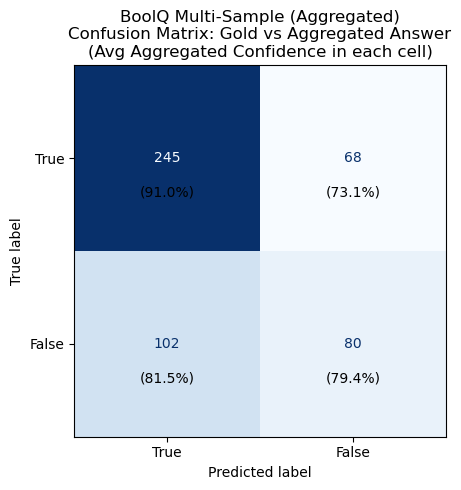

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Create confusion matrix for aggregated results

# Filter valid aggregated results (drop duplicates to have one entry per question_id)
valid_eval_boolq_agg = eval_df_boolq_agg.dropna(subset=["agg_answer", "agg_confidence"])
valid_eval_unique_boolq_agg = valid_eval_boolq_agg.drop_duplicates(subset=["question_id"])

# Calculate average aggregated confidence for each (true_answer, agg_answer) combination
avg_agg_conf_boolq_agg = valid_eval_unique_boolq_agg.groupby(['answer_norm', 'agg_answer'])['agg_confidence'].mean().unstack(fill_value=np.nan)
# Only choose true and false agg_answers
avg_agg_conf_boolq_agg = avg_agg_conf_boolq_agg.loc[["true", "false"], ["true", "false"]]
print("Average aggregated confidence by (True Answer, Aggregated Answer):")
print(avg_agg_conf_boolq_agg)

# Create confusion matrix
labels_norm = ["true", "false"]
cm_agg_boolq = confusion_matrix(valid_eval_unique_boolq_agg["answer_norm"], valid_eval_unique_boolq_agg["agg_answer"], labels=labels_norm)

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_agg_boolq, display_labels=["True", "False"])
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)

# Annotate with average aggregated confidence in brackets
for i, true_label in enumerate(labels_norm):
    for j, pred_label in enumerate(labels_norm):
        try:
            avg = valid_eval_unique_boolq_agg[
                (valid_eval_unique_boolq_agg["answer_norm"] == true_label) & 
                (valid_eval_unique_boolq_agg["agg_answer"] == pred_label)
            ]["agg_confidence"].mean()
        except Exception:
            avg = np.nan
        
        # Place confidence a bit lower (y+0.15)
        if not np.isnan(avg):
            ax.text(j, i + 0.15, f"({avg:.1f}%)", va='top', ha='center', color='black', fontsize=10)

plt.title("BoolQ Multi-Sample (Aggregated)\nConfusion Matrix: Gold vs Aggregated Answer\n(Avg Aggregated Confidence in each cell)")
plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/boolq_multi_sample_confusion_matrix.png")
plt.show()

C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\2236606705.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = eval_df_boolq_agg.groupby("conf_bin").agg(
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\2236606705.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=box_labels)


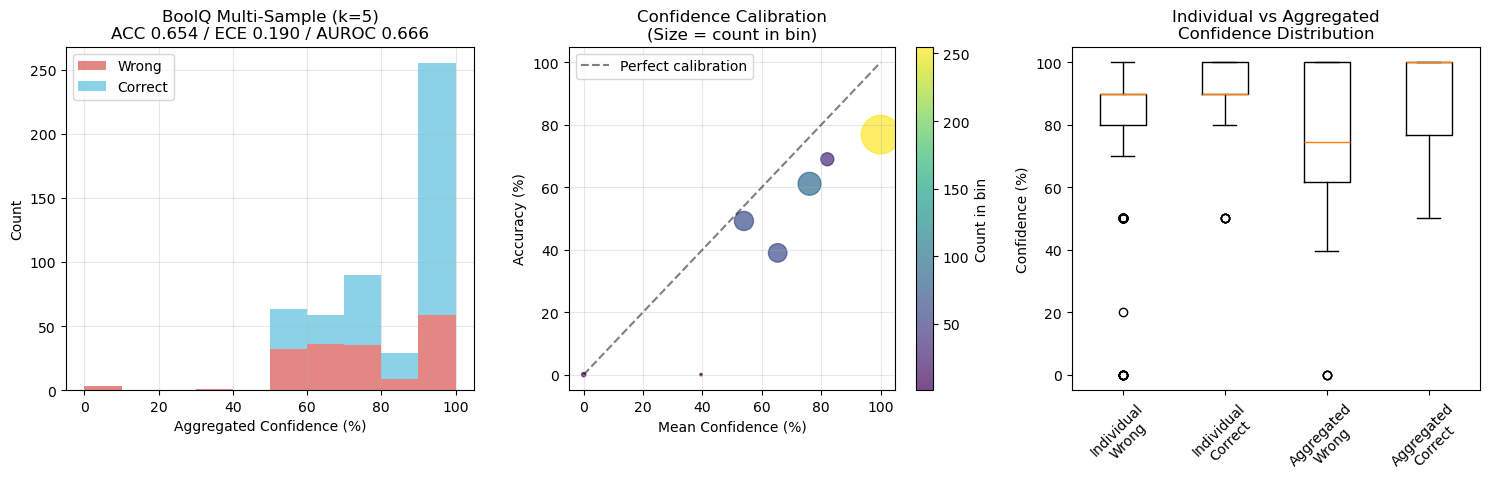


=== BoolQ Multi-Sample Results ===
Individual samples accuracy: 0.681
Aggregated accuracy: 0.654
Improvement in accuracy: -0.027


In [34]:
from sklearn.metrics import f1_score

agg_accuracy_boolq_agg = (valid_eval_unique_boolq_agg["agg_answer"] == valid_eval_unique_boolq_agg["answer_norm"]).mean()

# Visualizations for BoolQ multi-sample analysis
plt.figure(figsize=(15, 5))

# 1. Confidence distribution histogram
plt.subplot(1, 3, 1)
bins = np.arange(0, 101, 10)
correct_conf_boolq_agg = eval_df_boolq_agg[eval_df_boolq_agg["is_correct"]]["agg_confidence"]
wrong_conf_boolq_agg = eval_df_boolq_agg[~eval_df_boolq_agg["is_correct"]]["agg_confidence"]
# Calculate ECE and AUROC for aggregated results
ece_boolq_agg = calculate_ece(eval_df_boolq_agg, confidence_col='agg_confidence', correct_col='is_correct', n_bins=10)
auroc_boolq_agg = calculate_auroc(eval_df_boolq_agg, confidence_col='agg_confidence', correct_col='is_correct', plot=False)

plt.hist([wrong_conf_boolq_agg, correct_conf_boolq_agg], bins=bins, stacked=True, 
         color=["#d9534f", "#5bc0de"], label=["Wrong", "Correct"], alpha=0.7)
plt.xlabel("Aggregated Confidence (%)")
plt.ylabel("Count")
plt.title(f"BoolQ Multi-Sample (k=5)\nACC {agg_accuracy_boolq_agg:.3f} / ECE {ece_boolq_agg:.3f} / AUROC {auroc_boolq_agg:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Confidence calibration plot
plt.subplot(1, 3, 2)
conf_bins = np.arange(0, 111, 10)  # Fixed: include 100% bin
eval_df_boolq_agg["conf_bin"] = pd.cut(eval_df_boolq_agg["agg_confidence"], bins=conf_bins, right=False)
calib = eval_df_boolq_agg.groupby("conf_bin").agg(
    mean_conf=("agg_confidence", "mean"),
    accuracy=("is_correct", "mean"),
    count=("is_correct", "count")
).dropna()

plt.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Perfect calibration')
scatter = plt.scatter(calib["mean_conf"], calib["accuracy"]*100, 
                     s=[c*3 for c in calib["count"]], alpha=0.7, c=calib["count"], cmap='viridis')
plt.xlabel("Mean Confidence (%)")
plt.ylabel("Accuracy (%)")
plt.title("Confidence Calibration\n(Size = count in bin)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Count in bin')  # Added colorbar

# 3. Box plot comparing single vs aggregated confidence
plt.subplot(1, 3, 3)
# Get individual sample confidences for comparison
individual_valid = df_boolq_multi.dropna(subset=["parsed_confidence"])
individual_correct = individual_valid.apply(lambda row: 
    normalize_boolq_multi(row["parsed_answer"]) == "true", axis=1)

box_data = [
    individual_valid[~individual_correct]["parsed_confidence"],
    individual_valid[individual_correct]["parsed_confidence"],
    eval_df_boolq_agg[~eval_df_boolq_agg["is_correct"]]["agg_confidence"],
    eval_df_boolq_agg[eval_df_boolq_agg["is_correct"]]["agg_confidence"]
]
box_labels = ["Individual\nWrong", "Individual\nCorrect", "Aggregated\nWrong", "Aggregated\nCorrect"]

plt.boxplot(box_data, labels=box_labels)
plt.ylabel("Confidence (%)")
plt.title("Individual vs Aggregated\nConfidence Distribution")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/boolq_multi_sample_analysis.png", dpi=150)
plt.show()

print(f"\n=== BoolQ Multi-Sample Results ===")
print(f"Individual samples accuracy: {individual_correct.mean():.3f}")
print(f"Aggregated accuracy: {agg_accuracy_boolq_agg:.3f}")
print(f"Improvement in accuracy: {agg_accuracy_boolq_agg - individual_correct.mean():.3f}")

## TriviaQA Multi-Sample

Multi-sample analysis for TriviaQA with confidence-weighted voting and answer clustering.

In [35]:
# Import modularized functions for multi-sample TriviaQA
from parsing_and_evaluation import (
    parse_aggregate_evaluate_trivia_multi,
    parse_and_evaluate_trivia_multi, 
    aggregate_confidence_trivia,
    evaluate_trivia_aggregated,
    normalize_trivia_multi
)

# ───────────────────────────────
# 0. Load Data
# ───────────────────────────────
df_trivia_multi = pd.read_csv("output/llm_confidence_elicitation/verbalized_confidence_multi_model/trivia_llama_k5_topk_500_full_parsed.csv")

print(f"Loaded TriviaQA multi-sample data:")
print(f"- Total samples: {len(df_trivia_multi)}")
print(f"- Unique questions: {df_trivia_multi['question_id'].nunique()}")
print(f"- Samples per question: {len(df_trivia_multi) / df_trivia_multi['question_id'].nunique():.1f}")

# ───────────────────────────────
# Complete Pipeline: Parse, Aggregate, and Evaluate
# ───────────────────────────────
df_parsed_trivia, df_agg_trivia, eval_df_trivia, acc_trivia = parse_aggregate_evaluate_trivia_multi(
    df_trivia_multi, 
    group_col="question_id",
    similarity_threshold=0.8  # Threshold for clustering similar answers
)

print(f"\n✅ Multi-Sample TriviaQA Results (Modularized):")
print(f"   - Valid parsed samples: {df_parsed_trivia['parsed_answer'].notna().sum()}")
print(f"   - Questions with valid aggregations: {len(df_agg_trivia)}")
print(f"   - Aggregated accuracy: {acc_trivia:.3f}")
# Return average accuracy after removing rows with answer_variants equal to 0
valid_eval_trivia = eval_df_trivia[eval_df_trivia['answer_variants'] > 0]
avg_accuracy_trivia = valid_eval_trivia['is_correct'].mean()
avg_confidence_trivia = valid_eval_trivia['agg_confidence'].mean()
print(f"   - Average accuracy (after removing questions with no answer variants): {avg_accuracy_trivia:.3f}")
print(f"   - Average confidence (after removing questions with no answer variants): {avg_confidence_trivia:.3f}")
print(f"   - Average answer variants per question: {df_agg_trivia['answer_variants'].mean():.1f}")

# Show first few results
print(f"\nFirst few aggregated results:")
display_cols = ['question_id', 'agg_answer', 'agg_confidence', 'answer_variants', 'is_correct']
eval_df_trivia[display_cols].head()

Loaded TriviaQA multi-sample data:
- Total samples: 2500
- Unique questions: 500
- Samples per question: 5.0

✅ Multi-Sample TriviaQA Results (Modularized):
   - Valid parsed samples: 2240
   - Questions with valid aggregations: 500
   - Aggregated accuracy: 0.186
   - Average accuracy (after removing questions with no answer variants): 0.192
   - Average confidence (after removing questions with no answer variants): 61.004
   - Average answer variants per question: 2.3

First few aggregated results:


,question_id,agg_answer,agg_confidence,answer_variants,is_correct
0,0,NaN,0.000000,0.0,False
1,1,<string>,100.000000,1.0,False
2,2,the ritz london,35.714286,3.0,False
3,3,greyhound lines inc,52.631579,2.0,True
4,4,b,100.000000,1.0,False


In [36]:
# Alternative: Step-by-step usage of modularized TriviaQA functions
print("=== STEP-BY-STEP MULTI-SAMPLE TRIVIA PROCESSING ===")
print()

# Step 1: Parse individual outputs
print("Step 1: Parsing individual model outputs...")
df_step1_trivia = parse_and_evaluate_trivia_multi(df_trivia_multi.copy(), group_col="question_id")
print(f"   ✅ Parsed {df_step1_trivia['parsed_answer'].notna().sum()} valid answers")

# Step 2: Aggregate by confidence-weighted voting with answer clustering
print("\nStep 2: Aggregating with confidence-weighted voting and answer clustering...")
df_step2_trivia = aggregate_confidence_trivia(df_step1_trivia, group_col="question_id", similarity_threshold=0.8)
print(f"   ✅ Aggregated {len(df_step2_trivia)} unique questions")
print(f"   - Average answer variants per question: {df_step2_trivia['answer_variants'].mean():.1f}")
print(f"   - Questions with multiple variants: {(df_step2_trivia['answer_variants'] > 1).sum()}")

# Step 3: Evaluate against ground truth
print("\nStep 3: Evaluating aggregated results...")
eval_step3_trivia, acc_step3_trivia = evaluate_trivia_aggregated(df_step2_trivia, df_step1_trivia, group_col="question_id")
print(f"   ✅ Accuracy: {acc_step3_trivia:.3f}")

# Show some examples
print(f"\nExample aggregated results:")
sample_results_trivia = eval_step3_trivia[['question_id', 'agg_answer', 'agg_confidence', 'answer_variants', 'is_correct']].head(5)
for _, row in sample_results_trivia.iterrows():
    status = "✅" if row['is_correct'] else "❌"
    print(f"{status} Q{row['question_id']}: '{row['agg_answer']}' (conf={row['agg_confidence']:.1f}%, variants={row['answer_variants']})")

# Compare individual vs aggregated performance
individual_trivia = df_step1_trivia.dropna(subset=["parsed_answer", "parsed_confidence"])
individual_acc_trivia = individual_trivia['is_correct'].mean() if 'is_correct' in individual_trivia.columns else 0

print(f"\n💡 Performance Comparison:")
print(f"- Individual samples accuracy: {individual_acc_trivia:.3f}")
print(f"- Aggregated accuracy: {acc_step3_trivia:.3f}")
print(f"- Improvement: {acc_step3_trivia - individual_acc_trivia:.3f}")

print(f"\n🔍 Answer Clustering Analysis:")
print(f"- Questions with single answer variant: {(df_step2_trivia['answer_variants'] == 1).sum()}")
print(f"- Questions with multiple variants: {(df_step2_trivia['answer_variants'] > 1).sum()}")
print(f"- Max variants for a single question: {df_step2_trivia['answer_variants'].max()}")

print(f"\n💡 Benefits of modularized TriviaQA approach:")
print("- Intelligent answer clustering for similar responses")
print("- Confidence-weighted voting across multiple samples")
print("- Flexible similarity threshold for answer grouping")
print("- Comprehensive evaluation against multiple gold answers")

=== STEP-BY-STEP MULTI-SAMPLE TRIVIA PROCESSING ===

Step 1: Parsing individual model outputs...
   ✅ Parsed 2240 valid answers

Step 2: Aggregating with confidence-weighted voting and answer clustering...
   ✅ Aggregated 500 unique questions
   - Average answer variants per question: 2.3
   - Questions with multiple variants: 373

Step 3: Evaluating aggregated results...
   ✅ Accuracy: 0.186

Example aggregated results:
❌ Q0: 'nan' (conf=0.0%, variants=0.0)
❌ Q1: '<string>' (conf=100.0%, variants=1.0)
❌ Q2: 'the ritz london' (conf=35.7%, variants=3.0)
✅ Q3: 'greyhound lines inc' (conf=52.6%, variants=2.0)
❌ Q4: 'b' (conf=100.0%, variants=1.0)

💡 Performance Comparison:
- Individual samples accuracy: 0.000
- Aggregated accuracy: 0.186
- Improvement: 0.186

🔍 Answer Clustering Analysis:
- Questions with single answer variant: 105
- Questions with multiple variants: 373
- Max variants for a single question: 5.0

💡 Benefits of modularized TriviaQA approach:
- Intelligent answer clustering

C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\4257020938.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = valid_agg_trivia.groupby("conf_bin").agg(
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\4257020938.py:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(variant_groups, labels=variant_labels)


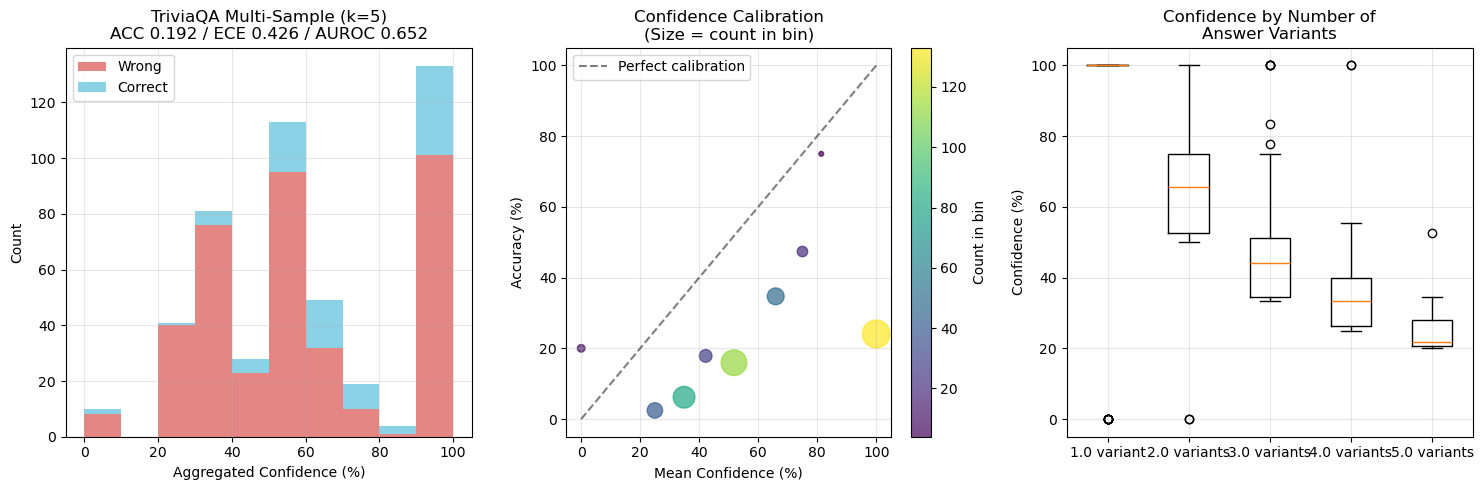

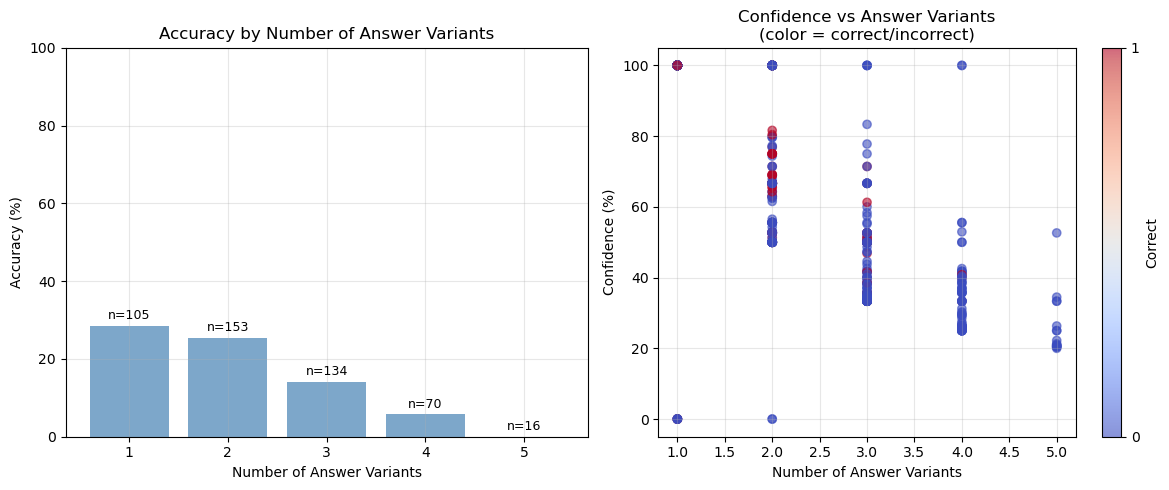

Total individual samples with valid answers: 1422
Individual samples accuracy: 0.182
Aggregated accuracy: 0.192
Improvement in accuracy: 0.010


C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\4257020938.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  individual_valid['is_correct'] = individual_valid.apply(


In [37]:
import seaborn as sns
import pandas as pd
import numpy as np
from parsing_and_evaluation import normalize_trivia_multi, evaluate_trivia_answer

# Visualizations for TriviaQA multi-sample analysis
import matplotlib.pyplot as plt

# Filter valid aggregated results (with actual answers and confidence) and remove those with no answer variants
valid_agg_trivia = eval_df_trivia[eval_df_trivia['agg_answer'].notna()].copy()
valid_agg_trivia = valid_agg_trivia[valid_agg_trivia['answer_variants'] > 0]

plt.figure(figsize=(15, 5))

# Calculate ECE and AUROC for aggregated results
ece_trivia_agg = calculate_ece(valid_agg_trivia, confidence_col='agg_confidence', correct_col='is_correct', n_bins=10)
auroc_trivia_agg = calculate_auroc(valid_agg_trivia, confidence_col='agg_confidence', correct_col='is_correct', plot=False)

# 1. Confidence distribution histogram
plt.subplot(1, 3, 1)
bins = np.arange(0, 101, 10)
correct_conf_trivia = valid_agg_trivia[valid_agg_trivia["is_correct"]]["agg_confidence"]
wrong_conf_trivia = valid_agg_trivia[~valid_agg_trivia["is_correct"]]["agg_confidence"]

plt.hist([wrong_conf_trivia, correct_conf_trivia], bins=bins, stacked=True, 
         color=["#d9534f", "#5bc0de"], label=["Wrong", "Correct"], alpha=0.7)
plt.xlabel("Aggregated Confidence (%)")
plt.ylabel("Count")
plt.title(f"TriviaQA Multi-Sample (k=5)\nACC {valid_agg_trivia['is_correct'].mean():.3f} / ECE {ece_trivia_agg:.3f} / AUROC {auroc_trivia_agg:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Confidence calibration plot
plt.subplot(1, 3, 2)
conf_bins = np.arange(0, 111, 10)  # Include 100% bin
valid_agg_trivia["conf_bin"] = pd.cut(valid_agg_trivia["agg_confidence"], bins=conf_bins, right=False)
calib = valid_agg_trivia.groupby("conf_bin").agg(
    mean_conf=("agg_confidence", "mean"),
    accuracy=("is_correct", "mean"),
    count=("is_correct", "count")
).dropna()

plt.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Perfect calibration')
scatter = plt.scatter(calib["mean_conf"], calib["accuracy"]*100, 
                     s=[c*3 for c in calib["count"]], alpha=0.7, c=calib["count"], cmap='viridis')
plt.xlabel("Mean Confidence (%)")
plt.ylabel("Accuracy (%)")
plt.title("Confidence Calibration\n(Size = count in bin)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Count in bin')

# 3. Answer variants vs confidence plot
plt.subplot(1, 3, 3)
# Box plot for confidence vs answer variants
variant_groups = []
variant_labels = []
for i in sorted(valid_agg_trivia['answer_variants'].unique()):
    if i > 0:  # Only include non-zero variants
        group_data = valid_agg_trivia[valid_agg_trivia['answer_variants'] == i]['agg_confidence']
        if len(group_data) > 0:
            variant_groups.append(group_data)
            variant_labels.append(f"{i} variant{'s' if i>1 else ''}")

if variant_groups:  # Only plot if we have data
    plt.boxplot(variant_groups, labels=variant_labels)
    plt.ylabel("Confidence (%)")
    plt.title("Confidence by Number of\nAnswer Variants")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/trivia_multi_sample_analysis.png", dpi=150)
plt.show()

# Additional analysis: accuracy by number of variants
plt.figure(figsize=(12, 5))

# 1. Accuracy by number of variants
plt.subplot(1, 2, 1)
acc_by_variants = valid_agg_trivia.groupby('answer_variants')['is_correct'].agg(['mean', 'count'])
acc_by_variants = acc_by_variants[acc_by_variants['count'] > 5]  # Only include groups with sufficient samples

x = acc_by_variants.index
y = acc_by_variants['mean']
counts = acc_by_variants['count']

bars = plt.bar(x, y*100, alpha=0.7, color='steelblue')
plt.xlabel("Number of Answer Variants")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy by Number of Answer Variants")

# Add count labels on top of bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'n={count}', ha='center', va='bottom', fontsize=9)

plt.ylim(0, 100)
plt.grid(True, alpha=0.3)

# 2. Scatter plot of confidence vs variants with accuracy color
plt.subplot(1, 2, 2)
scatter = plt.scatter(valid_agg_trivia['answer_variants'], 
                     valid_agg_trivia['agg_confidence'],
                     c=valid_agg_trivia['is_correct'], 
                     cmap=plt.cm.coolwarm,
                     alpha=0.6)

plt.xlabel("Number of Answer Variants")
plt.ylabel("Confidence (%)")
plt.title("Confidence vs Answer Variants\n(color = correct/incorrect)")
plt.colorbar(scatter, label='Correct', ticks=[0, 1])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/trivia_multi_variants_analysis.png", dpi=150)
plt.show()

# Compare individual vs aggregated performance
# Filter individual samples that have valid answers
individual_valid = df_trivia_multi.dropna(subset=["parsed_answer", "parsed_confidence"])
print(f"Total individual samples with valid answers: {len(individual_valid)}")

# Calculate individual accuracy if possible
if 'answers' in individual_valid.columns:
    individual_valid['is_correct'] = individual_valid.apply(
        lambda row: evaluate_trivia_answer(normalize_trivia_multi(row['parsed_answer']), 
                                          eval(row['answers'])), 
        axis=1)
    individual_acc = individual_valid['is_correct'].mean() if 'is_correct' in individual_valid.columns else 0
    aggregated_acc = valid_agg_trivia['is_correct'].mean()
    
    print(f"Individual samples accuracy: {individual_acc:.3f}")
    print(f"Aggregated accuracy: {aggregated_acc:.3f}")
    print(f"Improvement in accuracy: {aggregated_acc - individual_acc:.3f}")

## SQuAD Multi-Sample

Multi-sample analysis for SQuAD with confidence-weighted voting and answer clustering.

In [38]:
# Import modularized functions for multi-sample SQuAD
from parsing_and_evaluation import (
    parse_aggregate_evaluate_squad_multi,
    parse_and_evaluate_squad_multi, 
    aggregate_confidence_squad,
    evaluate_squad_aggregated,
    normalize_squad_multi
)

# ───────────────────────────────
# 0. Load Data
# ───────────────────────────────
df_squad_multi = pd.read_csv("output/llm_confidence_elicitation/verbalized_confidence_multi_model/squad_llama_k5_topk_500_full_parsed.csv")

print(f"Loaded SQuAD multi-sample data:")
print(f"- Total samples: {len(df_squad_multi)}")
print(f"- Unique questions: {df_squad_multi['question_id'].nunique()}")
print(f"- Samples per question: {len(df_squad_multi) / df_squad_multi['question_id'].nunique():.1f}")

# Check for unanswerable questions
if 'is_impossible' in df_squad_multi.columns:
    unanswerable_count = df_squad_multi['is_impossible'].sum()
    print(f"- Unanswerable questions: {unanswerable_count} ({unanswerable_count/len(df_squad_multi)*100:.1f}%)")

# ───────────────────────────────
# Complete Pipeline: Parse, Aggregate, and Evaluate
# ───────────────────────────────
df_parsed_squad, df_agg_squad, eval_df_squad, acc_squad = parse_aggregate_evaluate_squad_multi(
    df_squad_multi, 
    group_col="question_id",
    similarity_threshold=0.8,  # Threshold for clustering similar answers
    remove_unanswerable=True  # Set to True if you want to exclude unanswerable questions
)

print(f"\n✅ Multi-Sample SQuAD Results (Modularized):")
print(f"   - Valid parsed samples: {df_parsed_squad['parsed_answer'].notna().sum()}")
print(f"   - Questions with valid aggregations: {len(df_agg_squad)}")
print(f"   - Aggregated accuracy: {acc_squad:.3f}")
print(f"   - Average answer variants per question: {df_agg_squad['answer_variants'].mean():.1f}")

# ───────────────────────────────
# Step-by-step breakdown for transparency
# ───────────────────────────────
print(f"\n=== STEP-BY-STEP MULTI-SAMPLE SQUAD PROCESSING ===")

# Step 1: Individual parsing results
df_step1_squad = parse_and_evaluate_squad_multi(df_squad_multi, group_col="question_id")
valid_parsed_squad = df_step1_squad.dropna(subset=["parsed_answer", "parsed_confidence"])
print(f"Step 1 - Individual parsing:")
print(f"   - Valid answers: {len(valid_parsed_squad)}")
print(f"   - Average confidence: {valid_parsed_squad['parsed_confidence'].mean():.1f}")

# Step 2: Answer clustering and aggregation
df_step2_squad = aggregate_confidence_squad(df_step1_squad, group_col="question_id", similarity_threshold=0.8)
valid_agg_squad = df_step2_squad[df_step2_squad['agg_answer'].notna()]
print(f"Step 2 - Answer aggregation:")
print(f"   - Aggregated questions: {len(valid_agg_squad)}")
print(f"   - Average aggregated confidence: {valid_agg_squad['agg_confidence'].mean():.1f}")

# Step 3: Evaluation against ground truth
eval_step3_squad, acc_step3_squad = evaluate_squad_aggregated(df_step2_squad, df_step1_squad, group_col="question_id")
print(f"Step 3 - Evaluation:")
print(f"   - Final accuracy: {acc_step3_squad:.3f}")

print(f"\n🔍 Answer Clustering Analysis:")
print(f"- Questions with single answer variant: {(df_step2_squad['answer_variants'] == 1).sum()}")
print(f"- Questions with multiple variants: {(df_step2_squad['answer_variants'] > 1).sum()}")
print(f"- Max variants for a single question: {df_step2_squad['answer_variants'].max()}")

print(f"\n💡 Benefits of modularized SQuAD approach:")
print("- Handles both answerable and unanswerable questions")
print("- Intelligent answer clustering for similar responses")
print("- Confidence-weighted voting across multiple samples")
print("- Flexible similarity threshold for answer grouping")
print("- Comprehensive evaluation against multiple gold answers")
print("- Support for removing unanswerable questions if needed")

Loaded SQuAD multi-sample data:
- Total samples: 2500
- Unique questions: 500
- Samples per question: 5.0
- Unanswerable questions: 950 (38.0%)
Removed 950 unanswerable questions. 1550 questions remaining.

✅ Multi-Sample SQuAD Results (Modularized):
   - Valid parsed samples: 1461
   - Questions with valid aggregations: 310
   - Aggregated accuracy: 0.487
   - Average answer variants per question: 1.6

=== STEP-BY-STEP MULTI-SAMPLE SQUAD PROCESSING ===
Step 1 - Individual parsing:
   - Valid answers: 1102
   - Average confidence: 84.8
Step 2 - Answer aggregation:
   - Aggregated questions: 449
   - Average aggregated confidence: 70.0
Step 3 - Evaluation:
   - Final accuracy: 0.302

🔍 Answer Clustering Analysis:
- Questions with single answer variant: 182
- Questions with multiple variants: 267
- Max variants for a single question: 5.0

💡 Benefits of modularized SQuAD approach:
- Handles both answerable and unanswerable questions
- Intelligent answer clustering for similar responses
- 

In [39]:
# Remove questions with no answer variants and calculate average accuracy
valid_eval_squad = eval_df_squad[eval_df_squad['agg_answer'].notna()].copy()
valid_eval_squad = valid_eval_squad[valid_eval_squad['answer_variants'] > 0]
avg_accuracy_squad = valid_eval_squad['is_correct'].mean()
avg_accuracy_squad

0.5431654676258992

C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\102061294.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = valid_agg_squad.groupby("conf_bin").agg(
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\102061294.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(variant_groups, labels=variant_labels)


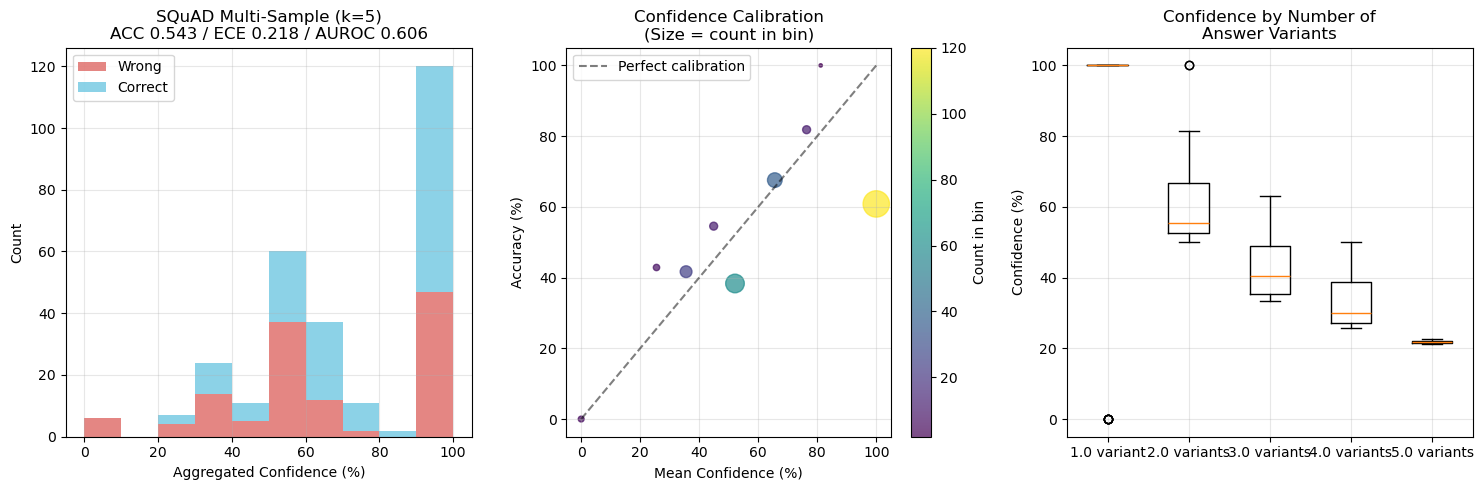

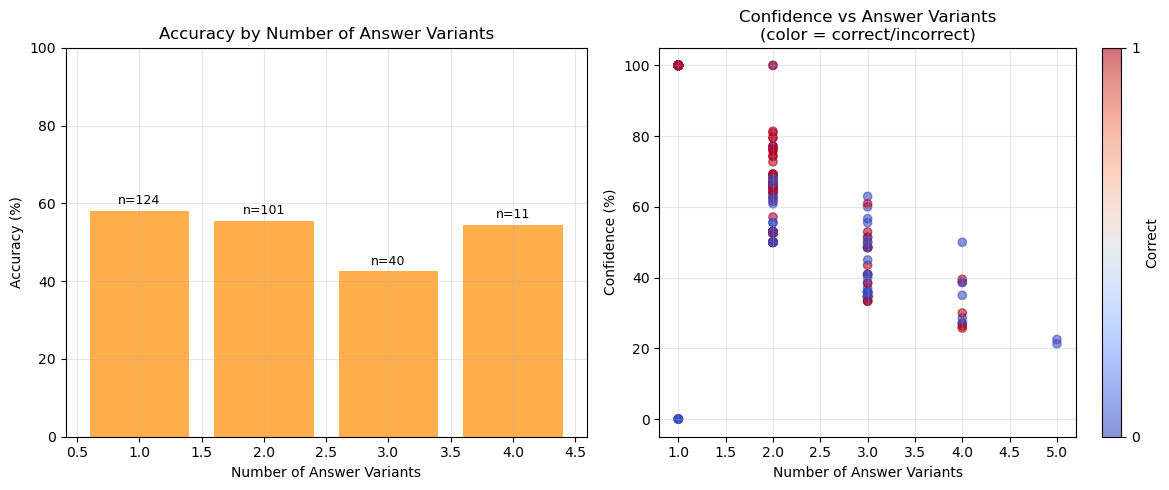

Total individual samples with valid answers: 1102
Individual samples accuracy: 0.327
Aggregated accuracy: 0.543
Improvement in accuracy: 0.216


C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\102061294.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  individual_valid_squad['is_correct'] = individual_valid_squad.apply(


In [40]:
# Visualizations for SQuAD multi-sample analysis
import seaborn as sns
import pandas as pd
import numpy as np
from parsing_and_evaluation import normalize_squad_multi, evaluate_squad_answer

# Filter valid aggregated results (with actual answers)
valid_agg_squad = eval_df_squad[eval_df_squad['agg_answer'].notna()].copy()

plt.figure(figsize=(15, 5))

# Calculate ECE and AUROC for aggregated results
ece_squad_agg = calculate_ece(valid_agg_squad, confidence_col='agg_confidence', correct_col='is_correct', n_bins=10)
auroc_squad_agg = calculate_auroc(valid_agg_squad, confidence_col='agg_confidence', correct_col='is_correct', plot=False)

# 1. Confidence distribution histogram
plt.subplot(1, 3, 1)
bins = np.arange(0, 101, 10)
correct_conf_squad = valid_agg_squad[valid_agg_squad["is_correct"]]["agg_confidence"]
wrong_conf_squad = valid_agg_squad[~valid_agg_squad["is_correct"]]["agg_confidence"]

plt.hist([wrong_conf_squad, correct_conf_squad], bins=bins, stacked=True, 
         color=["#d9534f", "#5bc0de"], label=["Wrong", "Correct"], alpha=0.7)
plt.xlabel("Aggregated Confidence (%)")
plt.ylabel("Count")
plt.title(f"SQuAD Multi-Sample (k=5)\nACC {valid_agg_squad['is_correct'].mean():.3f} / ECE {ece_squad_agg:.3f} / AUROC {auroc_squad_agg:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Confidence calibration plot
plt.subplot(1, 3, 2)
conf_bins = np.arange(0, 111, 10)  # Include 100% bin
valid_agg_squad["conf_bin"] = pd.cut(valid_agg_squad["agg_confidence"], bins=conf_bins, right=False)
calib = valid_agg_squad.groupby("conf_bin").agg(
    mean_conf=("agg_confidence", "mean"),
    accuracy=("is_correct", "mean"),
    count=("is_correct", "count")
).dropna()

plt.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Perfect calibration')
scatter = plt.scatter(calib["mean_conf"], calib["accuracy"]*100, 
                     s=[c*3 for c in calib["count"]], alpha=0.7, c=calib["count"], cmap='viridis')
plt.xlabel("Mean Confidence (%)")
plt.ylabel("Accuracy (%)")
plt.title("Confidence Calibration\n(Size = count in bin)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Count in bin')

# 3. Answer variants vs confidence plot
plt.subplot(1, 3, 3)
# Box plot for confidence vs answer variants
variant_groups = []
variant_labels = []
for i in sorted(valid_agg_squad['answer_variants'].unique()):
    if i > 0:  # Only include non-zero variants
        group_data = valid_agg_squad[valid_agg_squad['answer_variants'] == i]['agg_confidence']
        if len(group_data) > 0:
            variant_groups.append(group_data)
            variant_labels.append(f"{i} variant{'s' if i>1 else ''}")

if variant_groups:  # Only plot if we have data
    plt.boxplot(variant_groups, labels=variant_labels)
    plt.ylabel("Confidence (%)")
    plt.title("Confidence by Number of\nAnswer Variants")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/squad_multi_sample_analysis.png", dpi=150)
plt.show()

# Additional analysis: accuracy by number of variants
plt.figure(figsize=(12, 5))

# 1. Accuracy by number of variants
plt.subplot(1, 2, 1)
acc_by_variants = valid_agg_squad.groupby('answer_variants')['is_correct'].agg(['mean', 'count'])
acc_by_variants = acc_by_variants[acc_by_variants['count'] > 5]  # Only include groups with sufficient samples

x = acc_by_variants.index
y = acc_by_variants['mean']
counts = acc_by_variants['count']

bars = plt.bar(x, y*100, alpha=0.7, color='darkorange')
plt.xlabel("Number of Answer Variants")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy by Number of Answer Variants")

# Add count labels on top of bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'n={count}', ha='center', va='bottom', fontsize=9)

plt.ylim(0, 100)
plt.grid(True, alpha=0.3)

# 2. Scatter plot of confidence vs variants with accuracy color
plt.subplot(1, 2, 2)
scatter = plt.scatter(valid_agg_squad['answer_variants'], 
                     valid_agg_squad['agg_confidence'],
                     c=valid_agg_squad['is_correct'], 
                     cmap=plt.cm.coolwarm,
                     alpha=0.6)

plt.xlabel("Number of Answer Variants")
plt.ylabel("Confidence (%)")
plt.title("Confidence vs Answer Variants\n(color = correct/incorrect)")
plt.colorbar(scatter, label='Correct', ticks=[0, 1])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/squad_multi_variants_analysis.png", dpi=150)
plt.show()

# Compare individual vs aggregated performance
individual_valid_squad = df_squad_multi.dropna(subset=["parsed_answer", "parsed_confidence"])
print(f"Total individual samples with valid answers: {len(individual_valid_squad)}")

# Calculate individual accuracy if possible
if 'answers' in individual_valid_squad.columns:
    individual_valid_squad['is_correct'] = individual_valid_squad.apply(
        lambda row: evaluate_squad_answer(normalize_squad_multi(row['parsed_answer']), 
                                         eval(row['answers'])), 
        axis=1)
    individual_acc_squad = individual_valid_squad['is_correct'].mean() if 'is_correct' in individual_valid_squad.columns else 0
    aggregated_acc_squad = valid_agg_squad['is_correct'].mean()
    
    print(f"Individual samples accuracy: {individual_acc_squad:.3f}")
    print(f"Aggregated accuracy: {aggregated_acc_squad:.3f}")
    print(f"Improvement in accuracy: {aggregated_acc_squad - individual_acc_squad:.3f}")

# Compare answerable vs unanswerable questions if applicable
if 'is_impossible' in df_squad_multi.columns:
    # Analyze by question type
    answerable_agg = eval_df_squad.merge(
        df_squad_multi[['question_id', 'is_impossible']].drop_duplicates(), 
        on='question_id', how='left'
    )
    
    answerable_mask = ~answerable_agg['is_impossible']
    unanswerable_mask = answerable_agg['is_impossible']
    
    if answerable_mask.sum() > 0 and unanswerable_mask.sum() > 0:
        print(f"\nQuestion Type Analysis:")
        print(f"Answerable questions accuracy: {answerable_agg[answerable_mask]['is_correct'].mean():.3f}")
        print(f"Unanswerable questions accuracy: {answerable_agg[unanswerable_mask]['is_correct'].mean():.3f}")

=== CROSS-DATASET COMPARISON: SINGLE-SAMPLE VS MULTI-SAMPLE ===
 Dataset          Type  Accuracy  Avg Confidence   ECE  AUROC
   BoolQ Single-Sample     0.758          86.761 0.183  0.646
TriviaQA Single-Sample     0.501          68.123 0.309  0.700
   SQuAD Single-Sample     0.868          97.633 0.124  0.573
   BoolQ  Multi-Sample     0.650          84.043 0.190  0.666
TriviaQA  Multi-Sample     0.192          61.004 0.426  0.652
   SQuAD  Multi-Sample     0.543          72.244 0.218  0.606


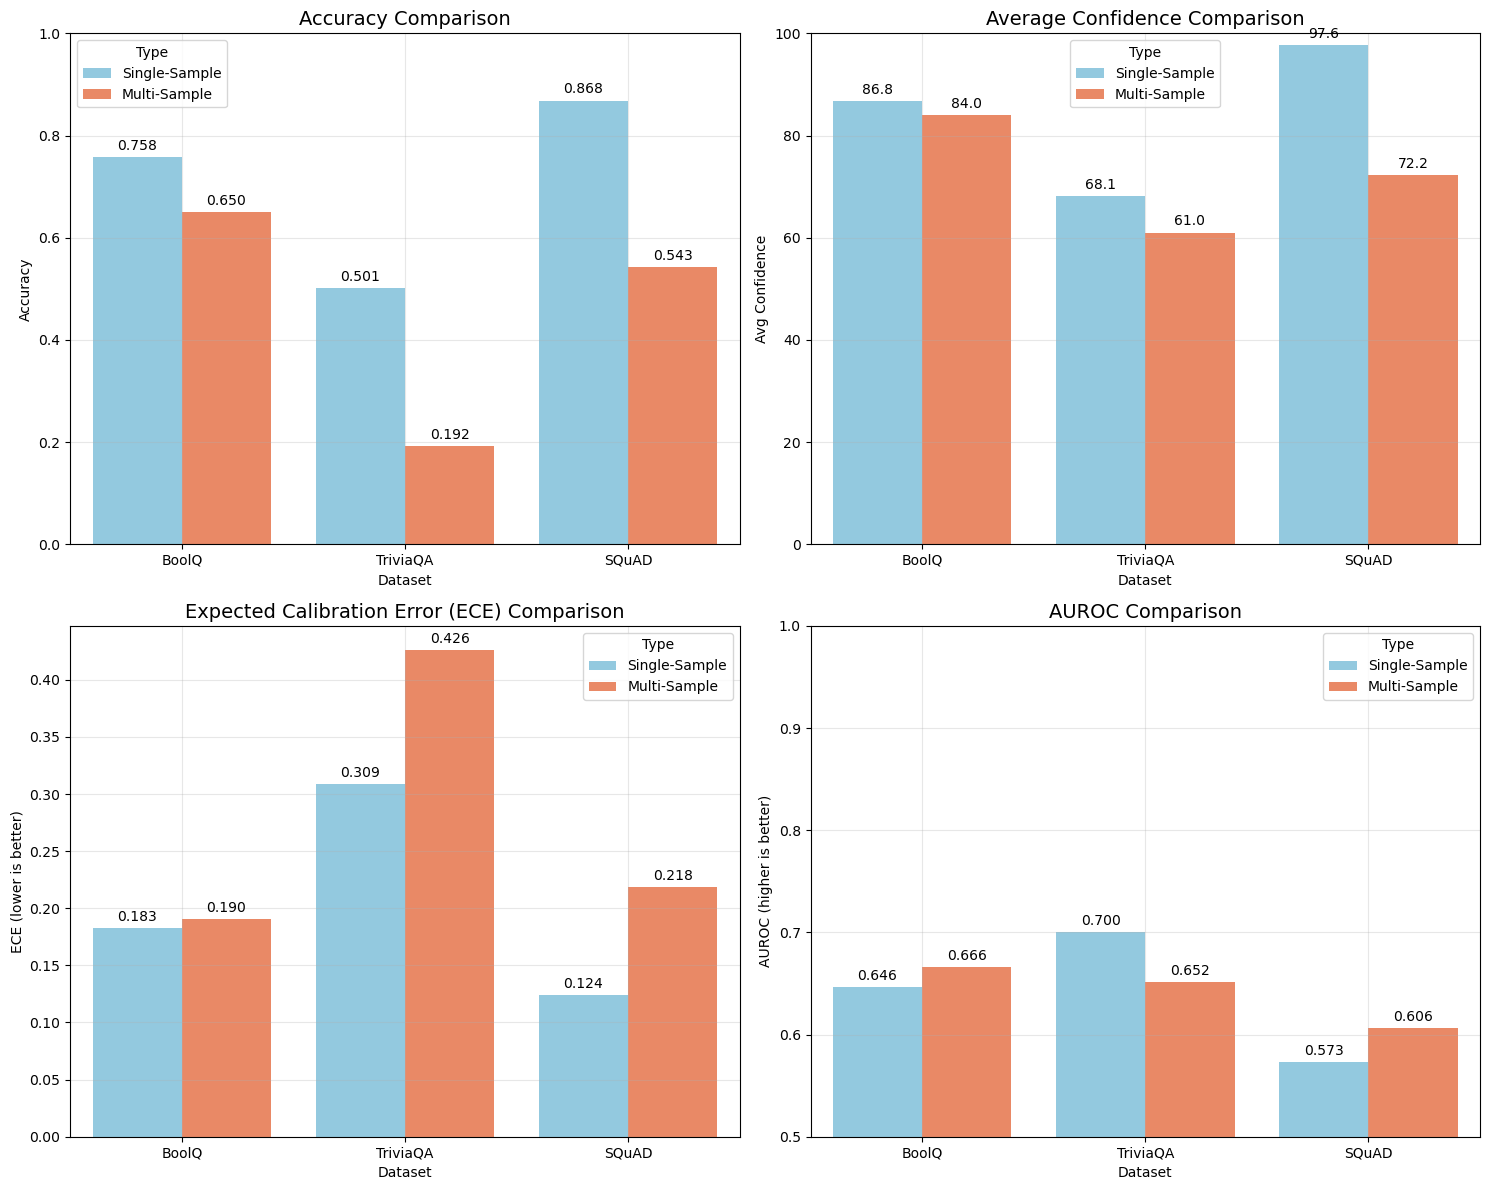


=== IMPROVEMENT FROM SINGLE-SAMPLE TO MULTI-SAMPLE ===
          Accuracy Improvement  Accuracy % Change  ECE Improvement  ECE % Change  AUROC Improvement  AUROC % Change
Dataset                                                                                                            
BoolQ                   -0.108            -14.302           -0.008        -4.340              0.020           3.123
SQuAD                   -0.325            -37.448           -0.095       -76.594              0.033           5.766
TriviaQA                -0.309            -61.584           -0.117       -37.848             -0.048          -6.921


C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\3368516478.py:175: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax1.text(i, v/2, f"({improvements['Accuracy % Change'][i]:.1f}%)", ha='center', fontsize=9, color='white' if abs(v) > 0.05 else 'black')
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\3368516478.py:187: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax2.text(i, v/2, f"({improvements['ECE % Change'][i]:.1f}%)", ha='center', fontsize=9, color='white' if abs(v) > 0.05 else 'black')
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\3368516478.py:199: FutureWarning: Series.__getitem__ treating keys as posit

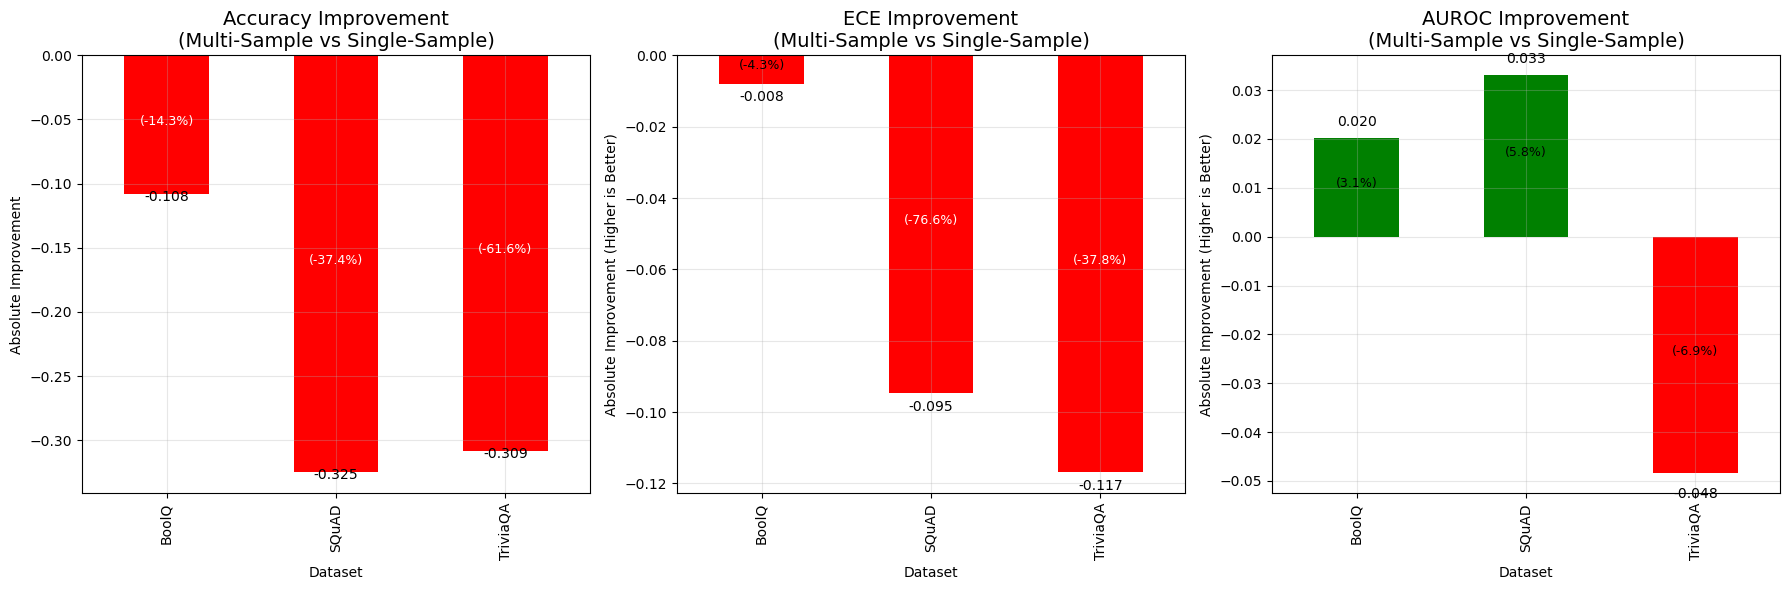


=== KEY INSIGHTS ===

BoolQ:
- Accuracy: significant decrease (-0.108, -14.3%)
- Calibration (ECE): slight decrease (-0.008, -4.3%)
- Discrimination (AUROC): modest improvement (0.020, 3.1%)

SQuAD:
- Accuracy: significant decrease (-0.325, -37.4%)
- Calibration (ECE): significant decrease (-0.095, -76.6%)
- Discrimination (AUROC): modest improvement (0.033, 5.8%)

TriviaQA:
- Accuracy: significant decrease (-0.309, -61.6%)
- Calibration (ECE): significant decrease (-0.117, -37.8%)
- Discrimination (AUROC): slight decrease (-0.048, -6.9%)


In [41]:
import pandas as pd
import numpy as np
import seaborn as sns

# Cross-Dataset Comparison: Single-Sample vs Multi-Sample
import matplotlib.pyplot as plt

# Create a dictionary to collect metrics from all datasets
all_metrics = []

# Add metrics for single-sample datasets (if available)
if 'df_valid_boolq' in locals() and 'ece_val_boolq' in locals():
    all_metrics.append({
        'Dataset': 'BoolQ',
        'Type': 'Single-Sample',
        'Accuracy': df_valid_boolq['is_correct'].mean(),
        'Avg Confidence': df_valid_boolq['parsed_confidence'].mean(),
        'ECE': ece_val_boolq,
        'AUROC': auroc_val_boolq
    })

if 'df_trivia_valid' in locals() and 'ece_trivia' in locals():
    all_metrics.append({
        'Dataset': 'TriviaQA',
        'Type': 'Single-Sample',
        'Accuracy': df_trivia_valid['is_correct'].mean(),
        'Avg Confidence': df_trivia_valid['parsed_confidence'].mean(),
        'ECE': ece_trivia,
        'AUROC': auroc_trivia
    })

if 'df_squad_answerable_valid' in locals() and 'squad_ece_scores' in locals():
    all_metrics.append({
        'Dataset': 'SQuAD',
        'Type': 'Single-Sample',
        'Accuracy': df_squad_answerable_valid['is_correct'].mean(),
        'Avg Confidence': df_squad_answerable_valid['parsed_confidence'].mean(),
        'ECE': squad_ece_scores[1][1],  # Use the answerable only ECE
        'AUROC': squad_auroc_scores[1][1]  # Use the answerable only AUROC
    })

# Add metrics for multi-sample datasets (if available)
if 'eval_df_boolq_agg' in locals() and 'ece_boolq_agg' in locals():
    all_metrics.append({
        'Dataset': 'BoolQ',
        'Type': 'Multi-Sample',
        'Accuracy': eval_df_boolq_agg['is_correct'].mean(),
        'Avg Confidence': eval_df_boolq_agg['agg_confidence'].mean(),
        'ECE': ece_boolq_agg,
        'AUROC': auroc_boolq_agg
    })

if 'valid_agg_trivia' in locals() and 'ece_trivia_agg' in locals():
    all_metrics.append({
        'Dataset': 'TriviaQA',
        'Type': 'Multi-Sample',
        'Accuracy': valid_agg_trivia['is_correct'].mean(),
        'Avg Confidence': valid_agg_trivia['agg_confidence'].mean(),
        'ECE': ece_trivia_agg,
        'AUROC': auroc_trivia_agg
    })

if 'valid_agg_squad' in locals() and 'ece_squad_agg' in locals():
    all_metrics.append({
        'Dataset': 'SQuAD',
        'Type': 'Multi-Sample',
        'Accuracy': valid_agg_squad['is_correct'].mean(),
        'Avg Confidence': valid_agg_squad['agg_confidence'].mean(),
        'ECE': ece_squad_agg,
        'AUROC': auroc_squad_agg
    })

# Create DataFrame from collected metrics
df_metrics = pd.DataFrame(all_metrics)

# Display metrics table
print("=== CROSS-DATASET COMPARISON: SINGLE-SAMPLE VS MULTI-SAMPLE ===")
if not df_metrics.empty:
    print(df_metrics.to_string(index=False, float_format=lambda x: f"{x:.3f}"))
else:
    print("No metrics available for comparison.")

# Visualize comparison if we have data
if not df_metrics.empty:
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Set color palette
    colors = {"Single-Sample": "skyblue", "Multi-Sample": "coral"}
    
    # 1. Accuracy comparison
    sns.barplot(x="Dataset", y="Accuracy", hue="Type", data=df_metrics, ax=ax1, palette=colors)
    ax1.set_title("Accuracy Comparison", fontsize=14)
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.3f', padding=3)
    
    # 2. Average Confidence comparison
    sns.barplot(x="Dataset", y="Avg Confidence", hue="Type", data=df_metrics, ax=ax2, palette=colors)
    ax2.set_title("Average Confidence Comparison", fontsize=14)
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.1f', padding=3)
    
    # 3. ECE comparison (lower is better)
    sns.barplot(x="Dataset", y="ECE", hue="Type", data=df_metrics, ax=ax3, palette=colors)
    ax3.set_title("Expected Calibration Error (ECE) Comparison", fontsize=14)
    ax3.set_ylabel("ECE (lower is better)")
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for container in ax3.containers:
        ax3.bar_label(container, fmt='%.3f', padding=3)
    
    # 4. AUROC comparison (higher is better)
    sns.barplot(x="Dataset", y="AUROC", hue="Type", data=df_metrics, ax=ax4, palette=colors)
    ax4.set_title("AUROC Comparison", fontsize=14)
    ax4.set_ylabel("AUROC (higher is better)")
    ax4.set_ylim(0.5, 1.0)
    ax4.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for container in ax4.containers:
        ax4.bar_label(container, fmt='%.3f', padding=3)
    
    plt.tight_layout()
    plt.savefig("figures/metrics/confidence_elicitation/single_vs_multi_comparison.png", dpi=150)
    plt.show()
    
    # Create summary table with improvements
    if len(df_metrics) >= 6:  # Need at least one row for each dataset and type
        # Pivot the data to easily calculate improvements
        pivot_df = df_metrics.pivot(index='Dataset', columns='Type')
        
        # Calculate improvements
        improvements = pd.DataFrame(index=pivot_df.index)
        
        # Accuracy improvement
        if ('Accuracy', 'Single-Sample') in pivot_df.columns and ('Accuracy', 'Multi-Sample') in pivot_df.columns:
            improvements['Accuracy Improvement'] = pivot_df[('Accuracy', 'Multi-Sample')] - pivot_df[('Accuracy', 'Single-Sample')]
            improvements['Accuracy % Change'] = (improvements['Accuracy Improvement'] / pivot_df[('Accuracy', 'Single-Sample')]) * 100
        
        # ECE improvement (negative is better)
        if ('ECE', 'Single-Sample') in pivot_df.columns and ('ECE', 'Multi-Sample') in pivot_df.columns:
            improvements['ECE Improvement'] = pivot_df[('ECE', 'Single-Sample')] - pivot_df[('ECE', 'Multi-Sample')]
            improvements['ECE % Change'] = (improvements['ECE Improvement'] / pivot_df[('ECE', 'Single-Sample')]) * 100
        
        # AUROC improvement (positive is better)
        if ('AUROC', 'Single-Sample') in pivot_df.columns and ('AUROC', 'Multi-Sample') in pivot_df.columns:
            improvements['AUROC Improvement'] = pivot_df[('AUROC', 'Multi-Sample')] - pivot_df[('AUROC', 'Single-Sample')]
            improvements['AUROC % Change'] = (improvements['AUROC Improvement'] / pivot_df[('AUROC', 'Single-Sample')]) * 100
        
        print("\n=== IMPROVEMENT FROM SINGLE-SAMPLE TO MULTI-SAMPLE ===")
        print(improvements.to_string(float_format=lambda x: f"{x:.3f}" if abs(x) < 100 else f"{x:.1f}"))
        
        # Visualize improvements
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # 1. Accuracy improvement
        if 'Accuracy Improvement' in improvements.columns:
            improvements['Accuracy Improvement'].plot(kind='bar', ax=ax1, color='green' if (improvements['Accuracy Improvement'] > 0).all() else ['green' if x > 0 else 'red' for x in improvements['Accuracy Improvement']])
            ax1.set_title("Accuracy Improvement\n(Multi-Sample vs Single-Sample)", fontsize=14)
            ax1.set_ylabel("Absolute Improvement")
            ax1.grid(True, alpha=0.3)
            
            # Add value labels
            for i, v in enumerate(improvements['Accuracy Improvement']):
                ax1.text(i, v + 0.005 if v > 0 else v - 0.005, f"{v:.3f}", ha='center', fontsize=10)
                ax1.text(i, v/2, f"({improvements['Accuracy % Change'][i]:.1f}%)", ha='center', fontsize=9, color='white' if abs(v) > 0.05 else 'black')
        
        # 2. ECE improvement
        if 'ECE Improvement' in improvements.columns:
            improvements['ECE Improvement'].plot(kind='bar', ax=ax2, color='green' if (improvements['ECE Improvement'] > 0).all() else ['green' if x > 0 else 'red' for x in improvements['ECE Improvement']])
            ax2.set_title("ECE Improvement\n(Multi-Sample vs Single-Sample)", fontsize=14)
            ax2.set_ylabel("Absolute Improvement (Higher is Better)")
            ax2.grid(True, alpha=0.3)
            
            # Add value labels
            for i, v in enumerate(improvements['ECE Improvement']):
                ax2.text(i, v + 0.0025 if v > 0 else v - 0.005, f"{v:.3f}", ha='center', fontsize=10)
                ax2.text(i, v/2, f"({improvements['ECE % Change'][i]:.1f}%)", ha='center', fontsize=9, color='white' if abs(v) > 0.05 else 'black')
        
        # 3. AUROC improvement
        if 'AUROC Improvement' in improvements.columns:
            improvements['AUROC Improvement'].plot(kind='bar', ax=ax3, color='green' if (improvements['AUROC Improvement'] > 0).all() else ['green' if x > 0 else 'red' for x in improvements['AUROC Improvement']])
            ax3.set_title("AUROC Improvement\n(Multi-Sample vs Single-Sample)", fontsize=14)
            ax3.set_ylabel("Absolute Improvement (Higher is Better)")
            ax3.grid(True, alpha=0.3)
            
            # Add value labels
            for i, v in enumerate(improvements['AUROC Improvement']):
                ax3.text(i, v + 0.0025 if v > 0 else v - 0.005, f"{v:.3f}", ha='center', fontsize=10)
                ax3.text(i, v/2, f"({improvements['AUROC % Change'][i]:.1f}%)", ha='center', fontsize=9, color='white' if abs(v) > 0.05 else 'black')
        
        plt.tight_layout()
        plt.savefig("figures/metrics/confidence_elicitation/multi_sample_improvements.png", dpi=150)
        plt.show()
        
        # Key insights
        print("\n=== KEY INSIGHTS ===")
        for dataset in improvements.index:
            print(f"\n{dataset}:")
            
            if 'Accuracy Improvement' in improvements.columns:
                acc_imp = improvements.loc[dataset, 'Accuracy Improvement']
                acc_pct = improvements.loc[dataset, 'Accuracy % Change']
                impact = "substantial improvement" if acc_imp > 0.05 else "modest improvement" if acc_imp > 0 else "no improvement" if acc_imp == 0 else "slight decrease" if acc_imp > -0.05 else "significant decrease"
                print(f"- Accuracy: {impact} ({acc_imp:.3f}, {acc_pct:.1f}%)")
            
            if 'ECE Improvement' in improvements.columns:
                ece_imp = improvements.loc[dataset, 'ECE Improvement']
                ece_pct = improvements.loc[dataset, 'ECE % Change']
                impact = "substantial improvement" if ece_imp > 0.05 else "modest improvement" if ece_imp > 0 else "no improvement" if ece_imp == 0 else "slight decrease" if ece_imp > -0.05 else "significant decrease"
                print(f"- Calibration (ECE): {impact} ({ece_imp:.3f}, {ece_pct:.1f}%)")
            
            if 'AUROC Improvement' in improvements.columns:
                auroc_imp = improvements.loc[dataset, 'AUROC Improvement']
                auroc_pct = improvements.loc[dataset, 'AUROC % Change']
                impact = "substantial improvement" if auroc_imp > 0.05 else "modest improvement" if auroc_imp > 0 else "no improvement" if auroc_imp == 0 else "slight decrease" if auroc_imp > -0.05 else "significant decrease"
                print(f"- Discrimination (AUROC): {impact} ({auroc_imp:.3f}, {auroc_pct:.1f}%)")

# Multiple Sampels per Answer from multiple decodings

## BoolQ

In [42]:
import pandas as pd
from parsing_and_evaluation import parse_aggregate_evaluate_boolq_multi, parse_and_evaluate_boolq_multi, aggregate_confidence_boolq, evaluate_boolq_aggregated, normalize_boolq_multi

# ───────────────────────────────
# 0. Load Multi-Decoding Data  
# ───────────────────────────────
df_boolq_multi_decoding = pd.read_csv("output/llm_confidence_elicitation/verbalized_confidence_multi_model/llama_3B/boolq_meta-llama_Llama-3.2-3B-Instruct_k5_sep.csv")

print(f"Loaded BoolQ multi-decoding data:")
print(f"   - Total samples: {len(df_boolq_multi_decoding)}")
print(f"   - Unique questions: {df_boolq_multi_decoding['question_id'].nunique()}")
print(f"   - Questions per sample: {len(df_boolq_multi_decoding) / df_boolq_multi_decoding['question_id'].nunique():.1f}")

# ───────────────────────────────
# Complete Pipeline: Parse, Aggregate, and Evaluate
# ───────────────────────────────
df_parsed_boolq_multi_dec, df_agg_boolq_multi_dec, eval_df_boolq_multi_dec, acc_boolq_multi_dec = parse_aggregate_evaluate_boolq_multi(df_boolq_multi_decoding, group_col="question_id")

print(f"\n✅ Multi-Decoding BoolQ Results (Modularized):")
print(f"   - Total samples: {len(df_boolq_multi_decoding)}")
print(f"   - Unique questions: {df_boolq_multi_decoding['question_id'].nunique()}")
print(f"   - Valid parsed samples: {df_parsed_boolq_multi_dec['parsed_answer'].notna().sum()}")
print(f"   - Aggregated accuracy: {acc_boolq_multi_dec:.3f}")

# Show first few results
print(f"\nFirst few aggregated results:")
display(eval_df_boolq_multi_dec[['question_id', 'agg_answer', 'agg_confidence', 'answer_norm', 'is_correct']].head())

Loaded BoolQ multi-decoding data:
   - Total samples: 2500
   - Unique questions: 500
   - Questions per sample: 5.0

✅ Multi-Decoding BoolQ Results (Modularized):
   - Total samples: 2500
   - Unique questions: 500
   - Valid parsed samples: 1871
   - Aggregated accuracy: 0.762

First few aggregated results:


,question_id,agg_answer,agg_confidence,answer_norm,is_correct
0,0,true,100.0,true,True
1,1,true,100.0,true,True
2,2,true,100.0,true,True
3,3,true,100.0,true,True
4,4,true,100.0,true,True


In [43]:
# Alternative: Step-by-step usage of modularized functions
print("=== STEP-BY-STEP MULTI-DECODING BOOLQ PROCESSING ===")
print()

# Step 1: Parse individual outputs (if needed)
print("Step 1: Parsing individual model outputs...")
df_step1_multi_dec = parse_and_evaluate_boolq_multi(df_boolq_multi_decoding.copy(), group_col="question_id")
print(f"   ✅ Parsed {df_step1_multi_dec['parsed_answer'].notna().sum()} valid answers")

# Step 2: Aggregate by confidence-weighted voting
print("\nStep 2: Aggregating with confidence-weighted voting...")
df_step2_multi_dec = aggregate_confidence_boolq(df_step1_multi_dec, group_col="question_id")
print(f"   ✅ Aggregated {len(df_step2_multi_dec)} unique questions")
print(f"   - Answer distribution: {df_step2_multi_dec['agg_answer'].value_counts().to_dict()}")

# Step 3: Evaluate against ground truth
print("\nStep 3: Evaluating aggregated results...")
eval_step3_multi_dec, acc_step3_multi_dec = evaluate_boolq_aggregated(df_step2_multi_dec, df_step1_multi_dec, group_col="question_id")
print(f"   ✅ Accuracy: {acc_step3_multi_dec:.3f}")

# Show some examples
print(f"\nExample aggregated results:")
sample_results_multi_dec = eval_step3_multi_dec[['question_id', 'agg_answer', 'agg_confidence', 'answer_norm', 'is_correct']].head(5)
for _, row in sample_results_multi_dec.iterrows():
    status = "✅" if row['is_correct'] else "❌"
    print(f"{status} Q{row['question_id']}: Pred={row['agg_answer']} (conf={row['agg_confidence']:.1f}%), Gold={row['answer_norm']}")

print(f"\n💡 Benefits of multi-decoding approach:")
print("- Multiple independent decodings reduce over-confidence")
print("- Better diversity in generated answers")
print("- More robust confidence estimation")
print("- Improved calibration through ensemble effects")

=== STEP-BY-STEP MULTI-DECODING BOOLQ PROCESSING ===

Step 1: Parsing individual model outputs...
   ✅ Parsed 1871 valid answers

Step 2: Aggregating with confidence-weighted voting...
   ✅ Aggregated 500 unique questions
   - Answer distribution: {'true': 260, 'false': 236}

Step 3: Evaluating aggregated results...
   ✅ Accuracy: 0.762

Example aggregated results:
✅ Q0: Pred=true (conf=100.0%), Gold=true
✅ Q1: Pred=true (conf=100.0%), Gold=true
✅ Q2: Pred=true (conf=100.0%), Gold=true
✅ Q3: Pred=true (conf=100.0%), Gold=true
✅ Q4: Pred=true (conf=100.0%), Gold=true

💡 Benefits of multi-decoding approach:
- Multiple independent decodings reduce over-confidence
- Better diversity in generated answers
- More robust confidence estimation
- Improved calibration through ensemble effects


Average aggregated confidence by (True Answer, Aggregated Answer) - Multi-Decoding:
agg_answer        true      false
answer_norm                      
true         94.544242  85.106079
false        84.184382  90.658145


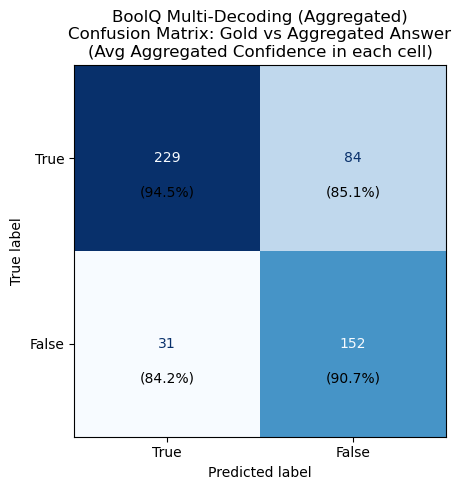

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Create confusion matrix for multi-decoding aggregated results

# Filter valid aggregated results (drop duplicates to have one entry per question_id)
valid_eval_boolq_multi_dec = eval_df_boolq_multi_dec.dropna(subset=["agg_answer", "agg_confidence"])
valid_eval_unique_boolq_multi_dec = valid_eval_boolq_multi_dec.drop_duplicates(subset=["question_id"])

# Calculate average aggregated confidence for each (true_answer, agg_answer) combination
avg_agg_conf_boolq_multi_dec = valid_eval_unique_boolq_multi_dec.groupby(['answer_norm', 'agg_answer'])['agg_confidence'].mean().unstack(fill_value=np.nan)
# Only choose true and false agg_answers
avg_agg_conf_boolq_multi_dec = avg_agg_conf_boolq_multi_dec.loc[["true", "false"], ["true", "false"]]
print("Average aggregated confidence by (True Answer, Aggregated Answer) - Multi-Decoding:")
print(avg_agg_conf_boolq_multi_dec)

# Create confusion matrix
labels_norm = ["true", "false"]
cm_agg_boolq_multi_dec = confusion_matrix(valid_eval_unique_boolq_multi_dec["answer_norm"], valid_eval_unique_boolq_multi_dec["agg_answer"], labels=labels_norm)

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_agg_boolq_multi_dec, display_labels=["True", "False"])
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)

# Annotate with average aggregated confidence in brackets
for i, true_label in enumerate(labels_norm):
    for j, pred_label in enumerate(labels_norm):
        try:
            avg = valid_eval_unique_boolq_multi_dec[
                (valid_eval_unique_boolq_multi_dec["answer_norm"] == true_label) & 
                (valid_eval_unique_boolq_multi_dec["agg_answer"] == pred_label)
            ]["agg_confidence"].mean()
        except Exception:
            avg = np.nan
        
        # Place confidence a bit lower (y+0.15)
        if not np.isnan(avg):
            ax.text(j, i + 0.15, f"({avg:.1f}%)", va='top', ha='center', color='black', fontsize=10)

plt.title("BoolQ Multi-Decoding (Aggregated)\nConfusion Matrix: Gold vs Aggregated Answer\n(Avg Aggregated Confidence in each cell)")
plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/boolq_multi_decoding_confusion_matrix.png")
plt.show()

C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\2713246350.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib_multi_dec = eval_df_boolq_multi_dec.groupby("conf_bin").agg(
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\2713246350.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=box_labels)


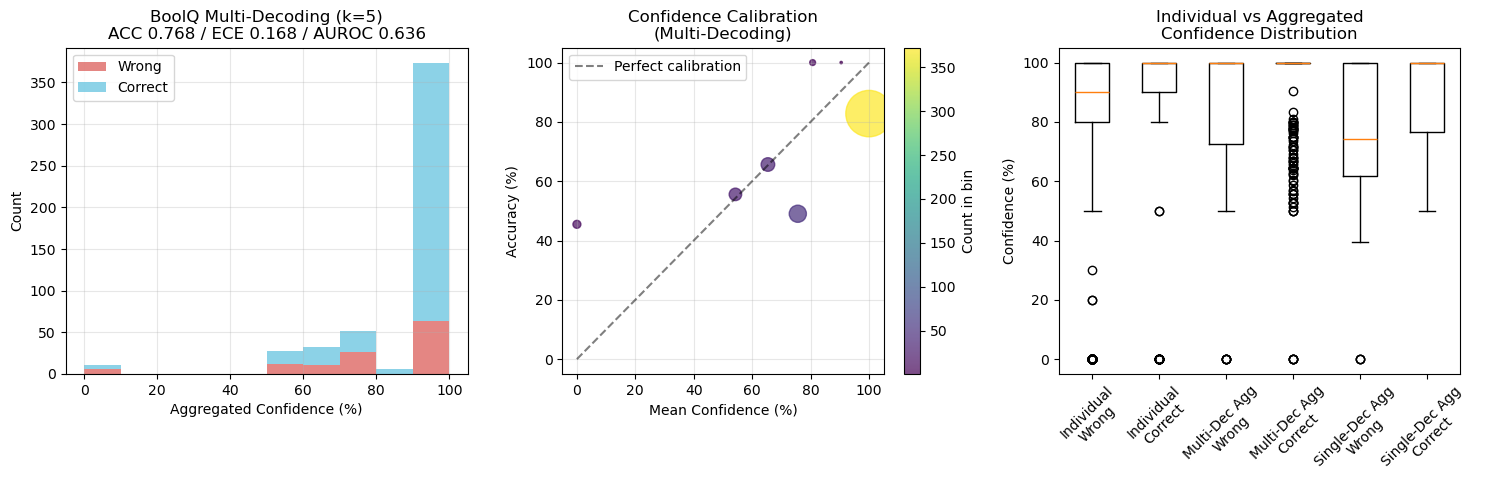


=== BoolQ Multi-Decoding Results ===
Accuracy: 0.768
ECE: 0.168
AUROC: 0.636
Average Confidence: 90.4%

📊 Comparison vs Single Decoding Multi-Sample:
Accuracy: 0.768 vs 0.654 (Δ: +0.114)
ECE: 0.168 vs 0.190 (Δ: -0.022)
AUROC: 0.636 vs 0.666 (Δ: -0.030)


In [45]:
from sklearn.metrics import f1_score

agg_accuracy_boolq_multi_dec = (valid_eval_unique_boolq_multi_dec["agg_answer"] == valid_eval_unique_boolq_multi_dec["answer_norm"]).mean()

# Visualizations for BoolQ multi-decoding analysis
plt.figure(figsize=(15, 5))

# 1. Confidence distribution histogram
plt.subplot(1, 3, 1)
bins = np.arange(0, 101, 10)
correct_conf_boolq_multi_dec = eval_df_boolq_multi_dec[eval_df_boolq_multi_dec["is_correct"]]["agg_confidence"]
wrong_conf_boolq_multi_dec = eval_df_boolq_multi_dec[~eval_df_boolq_multi_dec["is_correct"]]["agg_confidence"]

# Calculate ECE and AUROC for aggregated results
ece_boolq_multi_dec = calculate_ece(eval_df_boolq_multi_dec, confidence_col='agg_confidence', correct_col='is_correct', n_bins=10)
auroc_boolq_multi_dec = calculate_auroc(eval_df_boolq_multi_dec, confidence_col='agg_confidence', correct_col='is_correct', plot=False)

plt.hist([wrong_conf_boolq_multi_dec, correct_conf_boolq_multi_dec], bins=bins, stacked=True, 
         color=["#d9534f", "#5bc0de"], label=["Wrong", "Correct"], alpha=0.7)
plt.xlabel("Aggregated Confidence (%)")
plt.ylabel("Count")
plt.title(f"BoolQ Multi-Decoding (k=5)\nACC {agg_accuracy_boolq_multi_dec:.3f} / ECE {ece_boolq_multi_dec:.3f} / AUROC {auroc_boolq_multi_dec:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Confidence calibration plot
plt.subplot(1, 3, 2)
conf_bins = np.arange(0, 111, 10)  # Fixed: include 100% bin
eval_df_boolq_multi_dec["conf_bin"] = pd.cut(eval_df_boolq_multi_dec["agg_confidence"], bins=conf_bins, right=False)
calib_multi_dec = eval_df_boolq_multi_dec.groupby("conf_bin").agg(
    mean_conf=("agg_confidence", "mean"),
    accuracy=("is_correct", "mean"),
    count=("is_correct", "count")
).dropna()

plt.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Perfect calibration')
scatter = plt.scatter(calib_multi_dec["mean_conf"], calib_multi_dec["accuracy"]*100, 
                     s=[c*3 for c in calib_multi_dec["count"]], alpha=0.7, c=calib_multi_dec["count"], cmap='viridis')
plt.xlabel("Mean Confidence (%)")
plt.ylabel("Accuracy (%)")
plt.title("Confidence Calibration\n(Multi-Decoding)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Count in bin')

# 3. Box plot comparing single vs multi-decoding vs single decoding multi-sample
plt.subplot(1, 3, 3)
# Get individual sample confidences for comparison
individual_valid_multi_dec = df_boolq_multi_decoding.dropna(subset=["parsed_confidence"])
individual_correct_multi_dec = individual_valid_multi_dec.apply(lambda row: 
    normalize_boolq_multi(row["parsed_answer"]) == "true", axis=1)

# Compare with single decoding multi-sample if available
box_data = [
    individual_valid_multi_dec[~individual_correct_multi_dec]["parsed_confidence"],
    individual_valid_multi_dec[individual_correct_multi_dec]["parsed_confidence"],
    eval_df_boolq_multi_dec[~eval_df_boolq_multi_dec["is_correct"]]["agg_confidence"],
    eval_df_boolq_multi_dec[eval_df_boolq_multi_dec["is_correct"]]["agg_confidence"]
]
box_labels = ["Individual\nWrong", "Individual\nCorrect", "Multi-Dec Agg\nWrong", "Multi-Dec Agg\nCorrect"]

# Add single decoding comparison if available
if 'eval_df_boolq_agg' in locals():
    box_data.extend([
        eval_df_boolq_agg[~eval_df_boolq_agg["is_correct"]]["agg_confidence"],
        eval_df_boolq_agg[eval_df_boolq_agg["is_correct"]]["agg_confidence"]
    ])
    box_labels.extend(["Single-Dec Agg\nWrong", "Single-Dec Agg\nCorrect"])

plt.boxplot(box_data, labels=box_labels)
plt.ylabel("Confidence (%)")
plt.title("Individual vs Aggregated\nConfidence Distribution")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/boolq_multi_decoding_analysis.png", dpi=150)
plt.show()

print(f"\n=== BoolQ Multi-Decoding Results ===")
print(f"Accuracy: {agg_accuracy_boolq_multi_dec:.3f}")
print(f"ECE: {ece_boolq_multi_dec:.3f}")
print(f"AUROC: {auroc_boolq_multi_dec:.3f}")
print(f"Average Confidence: {eval_df_boolq_multi_dec['agg_confidence'].mean():.1f}%")

# Compare with single decoding if available
if 'agg_accuracy_boolq_agg' in locals():
    acc_imp = agg_accuracy_boolq_multi_dec - agg_accuracy_boolq_agg
    ece_imp = ece_boolq_agg - ece_boolq_multi_dec  # Lower ECE is better
    auroc_imp = auroc_boolq_multi_dec - auroc_boolq_agg
    
    print(f"\n📊 Comparison vs Single Decoding Multi-Sample:")
    print(f"Accuracy: {agg_accuracy_boolq_multi_dec:.3f} vs {agg_accuracy_boolq_agg:.3f} (Δ: {acc_imp:+.3f})")
    print(f"ECE: {ece_boolq_multi_dec:.3f} vs {ece_boolq_agg:.3f} (Δ: {-ece_imp:+.3f})")  # Negative because lower is better
    print(f"AUROC: {auroc_boolq_multi_dec:.3f} vs {auroc_boolq_agg:.3f} (Δ: {auroc_imp:+.3f})")

## SQuAD Multi-Decoding Multi-Sample Analysis

Multi-decoding analysis for SQuAD with confidence-weighted voting and answer clustering.

In [46]:
# Import modularized functions for multi-decoding SQuAD
from parsing_and_evaluation import parse_aggregate_evaluate_squad_multi, parse_and_evaluate_squad_multi, aggregate_confidence_squad, evaluate_squad_aggregated

# ───────────────────────────────
# 0. Load Multi-Decoding Data
# ───────────────────────────────
df_squad_multi_decoding = pd.read_csv("output/llm_confidence_elicitation/verbalized_confidence_multi_model/llama_3B/squad_meta-llama_Llama-3.2-3B-Instruct_k5_sep.csv")

nonsense_answers = [
    "extracted_answer", "<answer>", "True", "Yes", "No",
    "<short answer>", "A", "B", "C", "D"
]

df_squad_multi_decoding = df_squad_multi_decoding[
    ~df_squad_multi_decoding["parsed_answer"].isin(nonsense_answers)
]

print(f"Loaded SQuAD multi-decoding data:")
print(f"   - Total samples: {len(df_squad_multi_decoding)}")
print(f"   - Unique questions: {df_squad_multi_decoding['question_id'].nunique()}")
print(f"   - Samples per question: {len(df_squad_multi_decoding) / df_squad_multi_decoding['question_id'].nunique():.1f}")

# ───────────────────────────────
# Complete Pipeline: Parse, Aggregate, and Evaluate
# ───────────────────────────────
df_parsed_squad_multi_dec, df_agg_squad_multi_dec, eval_df_squad_multi_dec, acc_squad_multi_dec = parse_aggregate_evaluate_squad_multi(df_squad_multi_decoding, group_col="question_id")

print(f"\n✅ Multi-Decoding SQuAD Results (Modularized):")
print(f"   - Total samples: {len(df_squad_multi_decoding)}")
print(f"   - Unique questions: {df_squad_multi_decoding['question_id'].nunique()}")
print(f"   - Valid parsed samples: {df_parsed_squad_multi_dec['parsed_answer'].notna().sum()}")
print(f"   - Aggregated accuracy: {acc_squad_multi_dec:.3f}")

# Show first few results
print(f"\nFirst few aggregated results:")
display(eval_df_squad_multi_dec[['question_id', 'agg_answer', 'agg_confidence', 'answer_list', 'is_correct']].head())

Loaded SQuAD multi-decoding data:
   - Total samples: 2485
   - Unique questions: 500
   - Samples per question: 5.0

✅ Multi-Decoding SQuAD Results (Modularized):
   - Total samples: 2485
   - Unique questions: 500
   - Valid parsed samples: 913
   - Aggregated accuracy: 0.454

First few aggregated results:


,question_id,agg_answer,agg_confidence,answer_list,is_correct
0,0,NaN,0.0,[promotion of right-wing ministers to the cabi...,False
1,1,wi-fi,100.0,[wireless Ethernet (wi-fi)],True
2,2,sweep,75.0,[suppression/destruction of enemy air defense],False
3,3,1604,100.0,[1604],True
4,4,creating an mp3 file,100.0,[creating an MP3 file],True


In [47]:
# Alternative: Step-by-step usage of modularized functions
print("=== STEP-BY-STEP MULTI-DECODING SQUAD PROCESSING ===")
print()

# Step 1: Parse individual outputs
print("Step 1: Parsing individual model outputs...")
df_step1_squad_multi_dec = parse_and_evaluate_squad_multi(df_squad_multi_decoding.copy(), group_col="question_id")
print(f"   ✅ Parsed {df_step1_squad_multi_dec['parsed_answer'].notna().sum()} valid answers")

# Step 2: Aggregate by confidence-weighted voting with answer clustering
print("\nStep 2: Aggregating with confidence-weighted voting and answer clustering...")
df_step2_squad_multi_dec = aggregate_confidence_squad(df_step1_squad_multi_dec, group_col="question_id")
print(f"   ✅ Aggregated {len(df_step2_squad_multi_dec)} unique questions")

# Step 3: Evaluate against ground truth
print("\nStep 3: Evaluating aggregated results...")
eval_step3_squad_multi_dec, acc_step3_squad_multi_dec = evaluate_squad_aggregated(df_step2_squad_multi_dec, df_step1_squad_multi_dec, group_col="question_id")
print(f"   ✅ Accuracy: {acc_step3_squad_multi_dec:.3f}")

# Show some examples
print(f"\nExample aggregated results:")
sample_results_squad_multi_dec = eval_step3_squad_multi_dec[['question_id', 'agg_answer', 'agg_confidence', 'answer_variants', 'is_correct']].head(5)
for _, row in sample_results_squad_multi_dec.iterrows():
    status = "✅" if row['is_correct'] else "❌"
    print(f"{status} Q{row['question_id']}: Pred='{row['agg_answer']}' (conf={row['agg_confidence']:.1f}%), Gold='{row['answer_variants']}'")

print(f"\n💡 Multi-decoding benefits for SQuAD:")
print("- Answer clustering reduces noise from minor variations")
print("- Confidence-weighted voting improves selection")
print("- Multiple decodings provide better uncertainty estimates")
print("- Handles both answerable and unanswerable questions")

=== STEP-BY-STEP MULTI-DECODING SQUAD PROCESSING ===

Step 1: Parsing individual model outputs...
   ✅ Parsed 913 valid answers

Step 2: Aggregating with confidence-weighted voting and answer clustering...
   ✅ Aggregated 500 unique questions

Step 3: Evaluating aggregated results...
   ✅ Accuracy: 0.454

Example aggregated results:
❌ Q0: Pred='nan' (conf=0.0%), Gold='0.0'
✅ Q1: Pred='wi-fi' (conf=100.0%), Gold='1.0'
❌ Q2: Pred='sweep' (conf=75.0%), Gold='2.0'
✅ Q3: Pred='1604' (conf=100.0%), Gold='1.0'
✅ Q4: Pred='creating an mp3 file' (conf=100.0%), Gold='1.0'

💡 Multi-decoding benefits for SQuAD:
- Answer clustering reduces noise from minor variations
- Confidence-weighted voting improves selection
- Multiple decodings provide better uncertainty estimates
- Handles both answerable and unanswerable questions


C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\1670261115.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib_squad_multi_dec = eval_df_squad_multi_dec.groupby("conf_bin").agg(
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\1670261115.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  individual_valid_squad_multi_dec['is_correct'] = individual_valid_squad_multi_dec.apply(
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\1670261115.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Ma

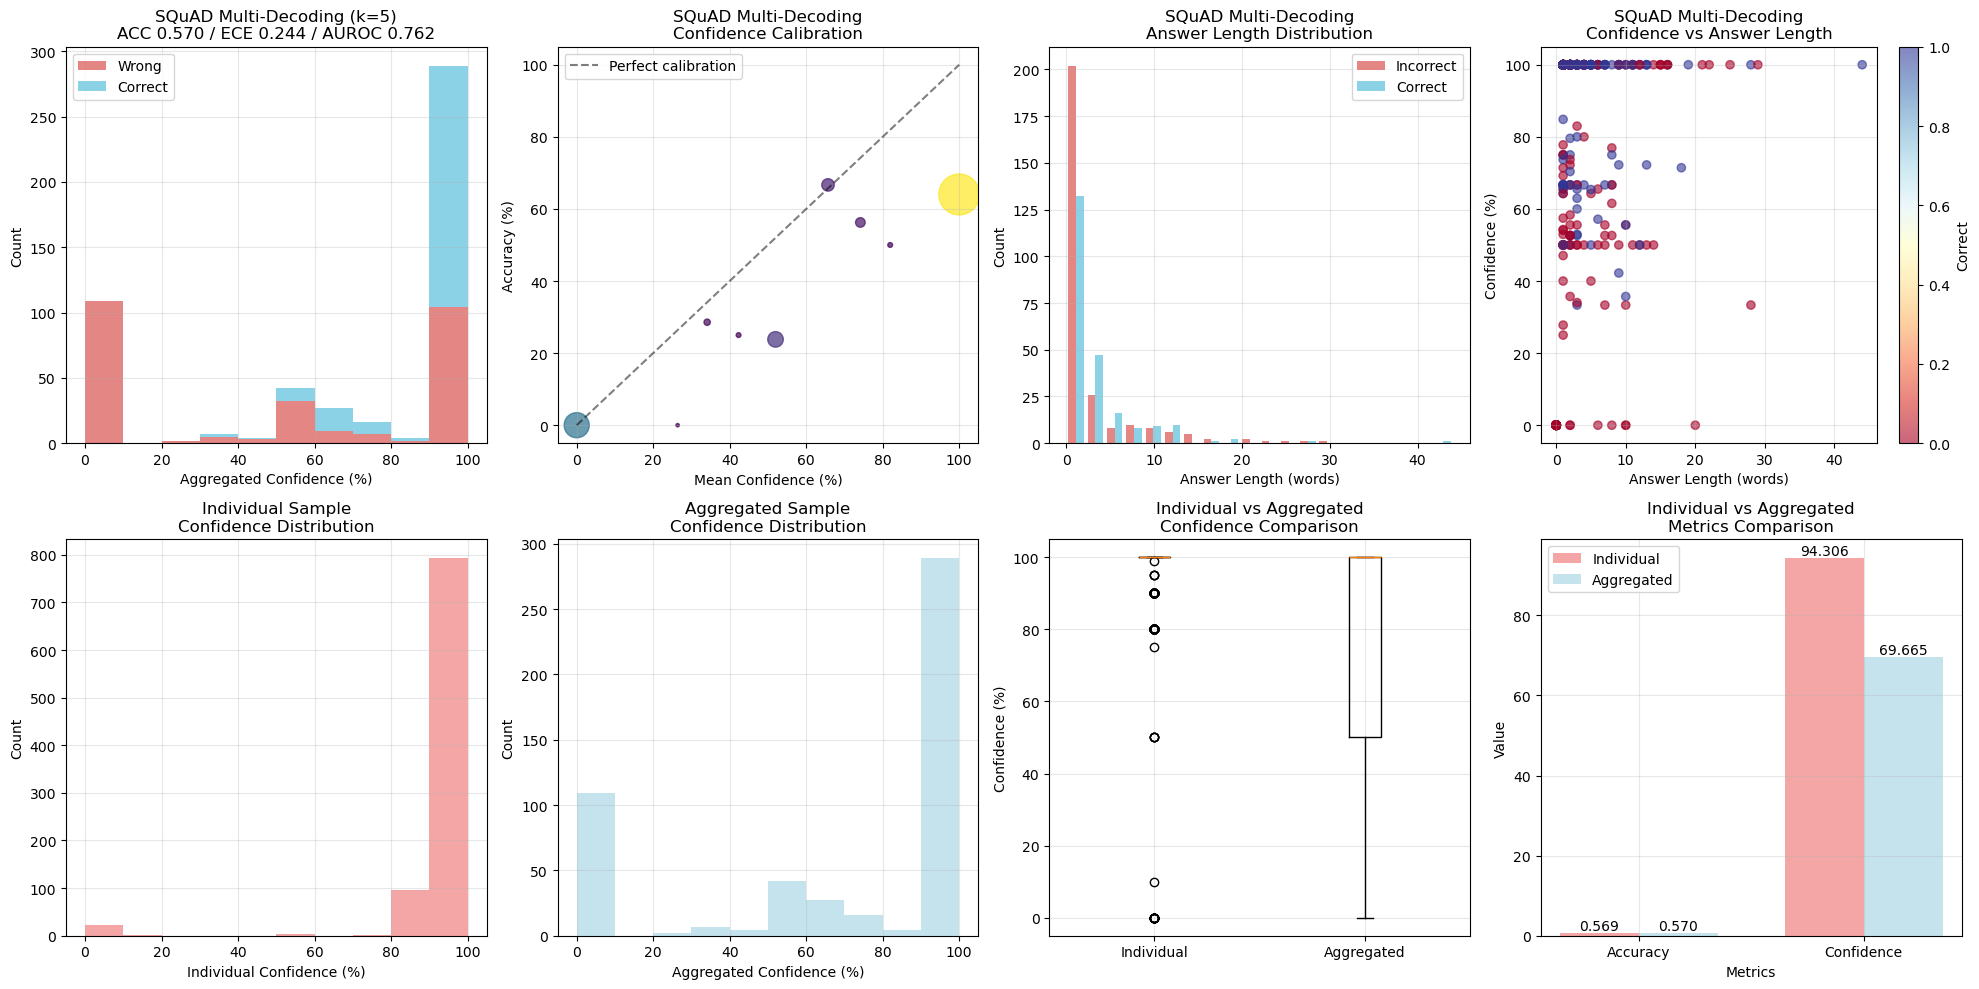


=== SQuAD Multi-Decoding Results ===
Accuracy: 0.570
ECE: 0.244
AUROC: 0.762
Average Confidence: 69.7%
Individual Accuracy: 0.569

📊 Comparison vs Single Decoding Multi-Sample:
Accuracy: 0.570 vs 0.569 (Δ: +0.001)
ECE: 0.244 vs 0.218 (Δ: +0.025)
AUROC: 0.762 vs 0.606 (Δ: +0.156)


In [48]:
from parsing_and_evaluation import evaluate_squad_answer

# Calculate metrics for SQuAD multi-decoding
valid_eval_squad_multi_dec = eval_df_squad_multi_dec.dropna(subset=["agg_answer", "agg_confidence"])
valid_eval_unique_squad_multi_dec = valid_eval_squad_multi_dec.drop_duplicates(subset=["question_id"])
valid_eval_unique_squad_multi_dec = valid_eval_unique_squad_multi_dec[valid_eval_unique_squad_multi_dec['answer_variants'] > 0]

agg_accuracy_squad_multi_dec = valid_eval_unique_squad_multi_dec['is_correct'].mean()
ece_squad_multi_dec = calculate_ece(eval_df_squad_multi_dec, confidence_col='agg_confidence', correct_col='is_correct', n_bins=10)
auroc_squad_multi_dec = calculate_auroc(eval_df_squad_multi_dec, confidence_col='agg_confidence', correct_col='is_correct', plot=False)

# Visualizations for SQuAD multi-decoding analysis
plt.figure(figsize=(20, 10))

# 1. Confidence distribution histogram
plt.subplot(2, 4, 1)
bins = np.arange(0, 101, 10)
correct_conf_squad_multi_dec = eval_df_squad_multi_dec[eval_df_squad_multi_dec["is_correct"]]["agg_confidence"]
wrong_conf_squad_multi_dec = eval_df_squad_multi_dec[~eval_df_squad_multi_dec["is_correct"]]["agg_confidence"]

plt.hist([wrong_conf_squad_multi_dec, correct_conf_squad_multi_dec], bins=bins, stacked=True, 
         color=["#d9534f", "#5bc0de"], label=["Wrong", "Correct"], alpha=0.7)
plt.xlabel("Aggregated Confidence (%)")
plt.ylabel("Count")
plt.title(f"SQuAD Multi-Decoding (k=5)\nACC {agg_accuracy_squad_multi_dec:.3f} / ECE {ece_squad_multi_dec:.3f} / AUROC {auroc_squad_multi_dec:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Confidence calibration plot
plt.subplot(2, 4, 2)
conf_bins = np.arange(0, 111, 10)
eval_df_squad_multi_dec["conf_bin"] = pd.cut(eval_df_squad_multi_dec["agg_confidence"], bins=conf_bins, right=False)
calib_squad_multi_dec = eval_df_squad_multi_dec.groupby("conf_bin").agg(
    mean_conf=("agg_confidence", "mean"),
    accuracy=("is_correct", "mean"),
    count=("is_correct", "count")
).dropna()

plt.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Perfect calibration')
scatter = plt.scatter(calib_squad_multi_dec["mean_conf"], calib_squad_multi_dec["accuracy"]*100, 
                     s=[c*3 for c in calib_squad_multi_dec["count"]], alpha=0.7, c=calib_squad_multi_dec["count"], cmap='viridis')
plt.xlabel("Mean Confidence (%)")
plt.ylabel("Accuracy (%)")
plt.title("SQuAD Multi-Decoding\nConfidence Calibration")
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Answer length distribution (correct vs incorrect)
plt.subplot(2, 4, 3)
answer_lengths_multi_dec = eval_df_squad_multi_dec['agg_answer'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
correct_lengths_multi_dec = answer_lengths_multi_dec[eval_df_squad_multi_dec['is_correct']]
incorrect_lengths_multi_dec = answer_lengths_multi_dec[~eval_df_squad_multi_dec['is_correct']]

plt.hist([incorrect_lengths_multi_dec, correct_lengths_multi_dec], bins=20, alpha=0.7, 
        label=['Incorrect', 'Correct'], color=['#d9534f', '#5bc0de'])
plt.xlabel("Answer Length (words)")
plt.ylabel("Count")
plt.title("SQuAD Multi-Decoding\nAnswer Length Distribution")
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Confidence vs Answer Length
plt.subplot(2, 4, 4)
plt.scatter(answer_lengths_multi_dec, eval_df_squad_multi_dec['agg_confidence'], 
           c=eval_df_squad_multi_dec['is_correct'], cmap='RdYlBu', alpha=0.6)
plt.xlabel("Answer Length (words)")
plt.ylabel("Confidence (%)")
plt.title("SQuAD Multi-Decoding\nConfidence vs Answer Length")
plt.colorbar(label='Correct')
plt.grid(True, alpha=0.3)

# 5-8: Individual vs Aggregated comparison
individual_valid_squad_multi_dec = df_squad_multi_decoding.dropna(subset=["parsed_confidence"])
individual_valid_squad_multi_dec['is_correct'] = individual_valid_squad_multi_dec.apply(
    lambda row: evaluate_squad_answer(
        normalize_squad_multi(row["parsed_answer"]) if row["parsed_answer"] is not None else "", 
        eval(row["answers"]) if isinstance(row["answers"], str) else row["answers"]
    ), 
    axis=1
)

# 5. Individual confidence distribution
plt.subplot(2, 4, 5)
plt.hist(individual_valid_squad_multi_dec["parsed_confidence"], bins=bins, alpha=0.7, color='lightcoral')
plt.xlabel("Individual Confidence (%)")
plt.ylabel("Count")
plt.title("Individual Sample\nConfidence Distribution")
plt.grid(True, alpha=0.3)

# 6. Aggregated confidence distribution
plt.subplot(2, 4, 6)
plt.hist(eval_df_squad_multi_dec["agg_confidence"], bins=bins, alpha=0.7, color='lightblue')
plt.xlabel("Aggregated Confidence (%)")
plt.ylabel("Count")
plt.title("Aggregated Sample\nConfidence Distribution")
plt.grid(True, alpha=0.3)

# 7. Box plot comparison
plt.subplot(2, 4, 7)
box_data_squad = [
    individual_valid_squad_multi_dec["parsed_confidence"],
    eval_df_squad_multi_dec["agg_confidence"]
]
box_labels_squad = ["Individual", "Aggregated"]

plt.boxplot(box_data_squad, labels=box_labels_squad)
plt.ylabel("Confidence (%)")
plt.title("Individual vs Aggregated\nConfidence Comparison")
plt.grid(True, alpha=0.3)

# 8. Accuracy improvement visualization
plt.subplot(2, 4, 8)

individual_acc_squad_multi_dec = individual_valid_squad_multi_dec['is_correct'].mean()
metrics_comparison = ['Accuracy', 'Confidence']
individual_metrics = [individual_acc_squad_multi_dec, individual_valid_squad_multi_dec['parsed_confidence'].mean()]
aggregated_metrics = [agg_accuracy_squad_multi_dec, eval_df_squad_multi_dec['agg_confidence'].mean()]

x = np.arange(len(metrics_comparison))
width = 0.35

plt.bar(x - width/2, individual_metrics, width, label='Individual', color='lightcoral', alpha=0.7)
plt.bar(x + width/2, aggregated_metrics, width, label='Aggregated', color='lightblue', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Individual vs Aggregated\nMetrics Comparison')
plt.xticks(x, metrics_comparison)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (ind_val, agg_val) in enumerate(zip(individual_metrics, aggregated_metrics)):
    plt.text(i - width/2, ind_val + 0.01, f'{ind_val:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, agg_val + 0.01, f'{agg_val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/squad_multi_decoding_analysis.png", dpi=150)
plt.show()

print(f"\n=== SQuAD Multi-Decoding Results ===")
print(f"Accuracy: {agg_accuracy_squad_multi_dec:.3f}")
print(f"ECE: {ece_squad_multi_dec:.3f}")
print(f"AUROC: {auroc_squad_multi_dec:.3f}")
print(f"Average Confidence: {eval_df_squad_multi_dec['agg_confidence'].mean():.1f}%")
print(f"Individual Accuracy: {individual_acc_squad_multi_dec:.3f}")

# Compare with single decoding if available
if 'agg_accuracy_squad_multi_dec' in locals():
    acc_imp_squad = agg_accuracy_squad_multi_dec - individual_acc_squad_multi_dec
    ece_imp_squad = ece_squad_agg - ece_squad_multi_dec  # Lower ECE is better
    auroc_imp_squad = auroc_squad_multi_dec - auroc_squad_agg
    
    print(f"\n📊 Comparison vs Single Decoding Multi-Sample:")
    print(f"Accuracy: {agg_accuracy_squad_multi_dec:.3f} vs {individual_acc_squad_multi_dec:.3f} (Δ: {acc_imp_squad:+.3f})")
    print(f"ECE: {ece_squad_multi_dec:.3f} vs {ece_squad_agg:.3f} (Δ: {-ece_imp_squad:+.3f})")
    print(f"AUROC: {auroc_squad_multi_dec:.3f} vs {auroc_squad_agg:.3f} (Δ: {auroc_imp_squad:+.3f})")

## TriviaQA Multi-Decoding Multi-Sample Analysis

Multi-decoding analysis for TriviaQA with confidence-weighted voting and answer clustering.

In [49]:
# Import modularized functions for multi-decoding TriviaQA
from parsing_and_evaluation import parse_aggregate_evaluate_trivia_multi, parse_and_evaluate_trivia_multi, aggregate_confidence_trivia, evaluate_trivia_aggregated

# ───────────────────────────────
# 0. Load Multi-Decoding Data
# ───────────────────────────────
df_trivia_multi_decoding = pd.read_csv("output/llm_confidence_elicitation/verbalized_confidence_multi_model/llama_3B/trivia_meta-llama_Llama-3.2-3B-Instruct_k5_sep.csv")

# Remove any rows with non-sense answers in parsed_answer column
nonsense_answers = [
    "A", "B", "C", "D", "E", "F",
    "True", "<string>", "extracted_answer"
]


df_trivia_multi_decoding = df_trivia_multi_decoding[~df_trivia_multi_decoding["parsed_answer"].isin(nonsense_answers)]


print(f"Loaded TriviaQA multi-decoding data:")
print(f"   - Total samples: {len(df_trivia_multi_decoding)}")
print(f"   - Unique questions: {df_trivia_multi_decoding['question_id'].nunique()}")
print(f"   - Samples per question: {len(df_trivia_multi_decoding) / df_trivia_multi_decoding['question_id'].nunique():.1f}")

# ───────────────────────────────
# Complete Pipeline: Parse, Aggregate, and Evaluate
# ───────────────────────────────
df_parsed_trivia_multi_dec, df_agg_trivia_multi_dec, eval_df_trivia_multi_dec, acc_trivia_multi_dec = parse_aggregate_evaluate_trivia_multi(df_trivia_multi_decoding, group_col="question_id")

print(f"\n✅ Multi-Decoding TriviaQA Results (Modularized):")
print(f"   - Total samples: {len(df_trivia_multi_decoding)}")
print(f"   - Unique questions: {df_trivia_multi_decoding['question_id'].nunique()}")
print(f"   - Valid parsed samples: {df_parsed_trivia_multi_dec['parsed_answer'].notna().sum()}")
print(f"   - Aggregated accuracy: {acc_trivia_multi_dec:.3f}")

# Show first few results
print(f"\nFirst few aggregated results:")
display(eval_df_trivia_multi_dec[['question_id', 'agg_answer', 'agg_confidence', 'answer_list', 'is_correct']].head())

Loaded TriviaQA multi-decoding data:
   - Total samples: 2422
   - Unique questions: 500
   - Samples per question: 4.8

✅ Multi-Decoding TriviaQA Results (Modularized):
   - Total samples: 2422
   - Unique questions: 500
   - Valid parsed samples: 731
   - Aggregated accuracy: 0.418

First few aggregated results:


,question_id,agg_answer,agg_confidence,answer_list,is_correct
0,0,square root of the number,100.000000,"[Reciprocal (disambiguation), reciprocal, reci...",False
1,1,the blind beggar,100.000000,"[blind beggar, Blind Beggar, The Blind Beggar]",True
2,2,the ritz london,100.000000,"[Claridges, Mivart's Hotel, claridge s, Clarid...",False
3,3,minnesota valley transit authority,100.000000,"[Greyhound Neon, greyhound lines, Greyhound Mé...",False
4,4,bachman,52.631579,"[bowie disambiguation, bowie, Bowie, Bowie (di...",False


In [51]:
df_trivia_multi_decoding["parsed_answer"].value_counts().head(10)

parsed_answer
Elton John              4
The Three Musketeers    4
Pete Best               4
1976                    4
Stephen Hawking         4
Coral reefs             3
Borneo                  3
1918                    3
George H.W. Bush        3
Beta Israel             3
Name: count, dtype: int64

In [52]:
# Alternative: Step-by-step usage of modularized functions
print("=== STEP-BY-STEP MULTI-DECODING TRIVIA PROCESSING ===")
print()

# Step 1: Parse individual outputs
print("Step 1: Parsing individual model outputs...")
df_step1_trivia_multi_dec = parse_and_evaluate_trivia_multi(df_trivia_multi_decoding.copy(), group_col="question_id")
print(f"   ✅ Parsed {df_step1_trivia_multi_dec['parsed_answer'].notna().sum()} valid answers")

# Step 2: Aggregate by confidence-weighted voting with answer clustering
print("\nStep 2: Aggregating with confidence-weighted voting and answer clustering...")
df_step2_trivia_multi_dec = aggregate_confidence_trivia(df_step1_trivia_multi_dec, group_col="question_id")
print(f"   ✅ Aggregated {len(df_step2_trivia_multi_dec)} unique questions")

# Step 3: Evaluate against ground truth
print("\nStep 3: Evaluating aggregated results...")
eval_step3_trivia_multi_dec, acc_step3_trivia_multi_dec = evaluate_trivia_aggregated(df_step2_trivia_multi_dec, df_step1_trivia_multi_dec, group_col="question_id")
print(f"   ✅ Accuracy: {acc_step3_trivia_multi_dec:.3f}")

# Show some examples
print(f"\nExample aggregated results:")
sample_results_trivia_multi_dec = eval_step3_trivia_multi_dec[['question_id', 'agg_answer', 'agg_confidence', 'answer_list', 'is_correct']].head(5)
for _, row in sample_results_trivia_multi_dec.iterrows():
    status = "✅" if row['is_correct'] else "❌"
    print(f"{status} Q{row['question_id']}: Pred='{row['agg_answer']}' (conf={row['agg_confidence']:.1f}%), Gold='{row['answer_list']}'")

print(f"\n💡 Multi-decoding benefits for TriviaQA:")
print("- Answer clustering handles equivalent answers (e.g., 'NYC' vs 'New York City')")
print("- Confidence-weighted voting reduces impact of low-confidence errors")
print("- Multiple decodings provide more robust uncertainty estimates")
print("- Better handling of factual knowledge questions with multiple valid phrasings")

=== STEP-BY-STEP MULTI-DECODING TRIVIA PROCESSING ===

Step 1: Parsing individual model outputs...
   ✅ Parsed 731 valid answers

Step 2: Aggregating with confidence-weighted voting and answer clustering...
   ✅ Aggregated 500 unique questions

Step 3: Evaluating aggregated results...
   ✅ Accuracy: 0.418

Example aggregated results:
❌ Q0: Pred='square root of the number' (conf=100.0%), Gold='['Reciprocal (disambiguation)', 'reciprocal', 'reciprocality', 'reciprocal disambiguation', 'Reciprocality', 'Reciprocal', 'Reciprocals', 'reciprocals', 'RECIPROCAL']'
✅ Q1: Pred='the blind beggar' (conf=100.0%), Gold='['blind beggar', 'Blind Beggar', 'The Blind Beggar']'
❌ Q2: Pred='the ritz london' (conf=100.0%), Gold='['Claridges', "Mivart's Hotel", 'claridge s', 'Claridges Hotel', "Claridge's Hotel", 'claridge s hotel', 'mivart s hotel', 'claridges hotel', 'claridges', "Claridge's"]'
❌ Q3: Pred='minnesota valley transit authority' (conf=100.0%), Gold='['Greyhound Neon', 'greyhound lines', 'Gre

C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\951476476.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib_trivia_multi_dec = eval_df_trivia_multi_dec.groupby("conf_bin").agg(
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\951476476.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  individual_valid_trivia_multi_dec['is_correct'] = individual_valid_trivia_multi_dec.apply(
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\951476476.py:104: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since M

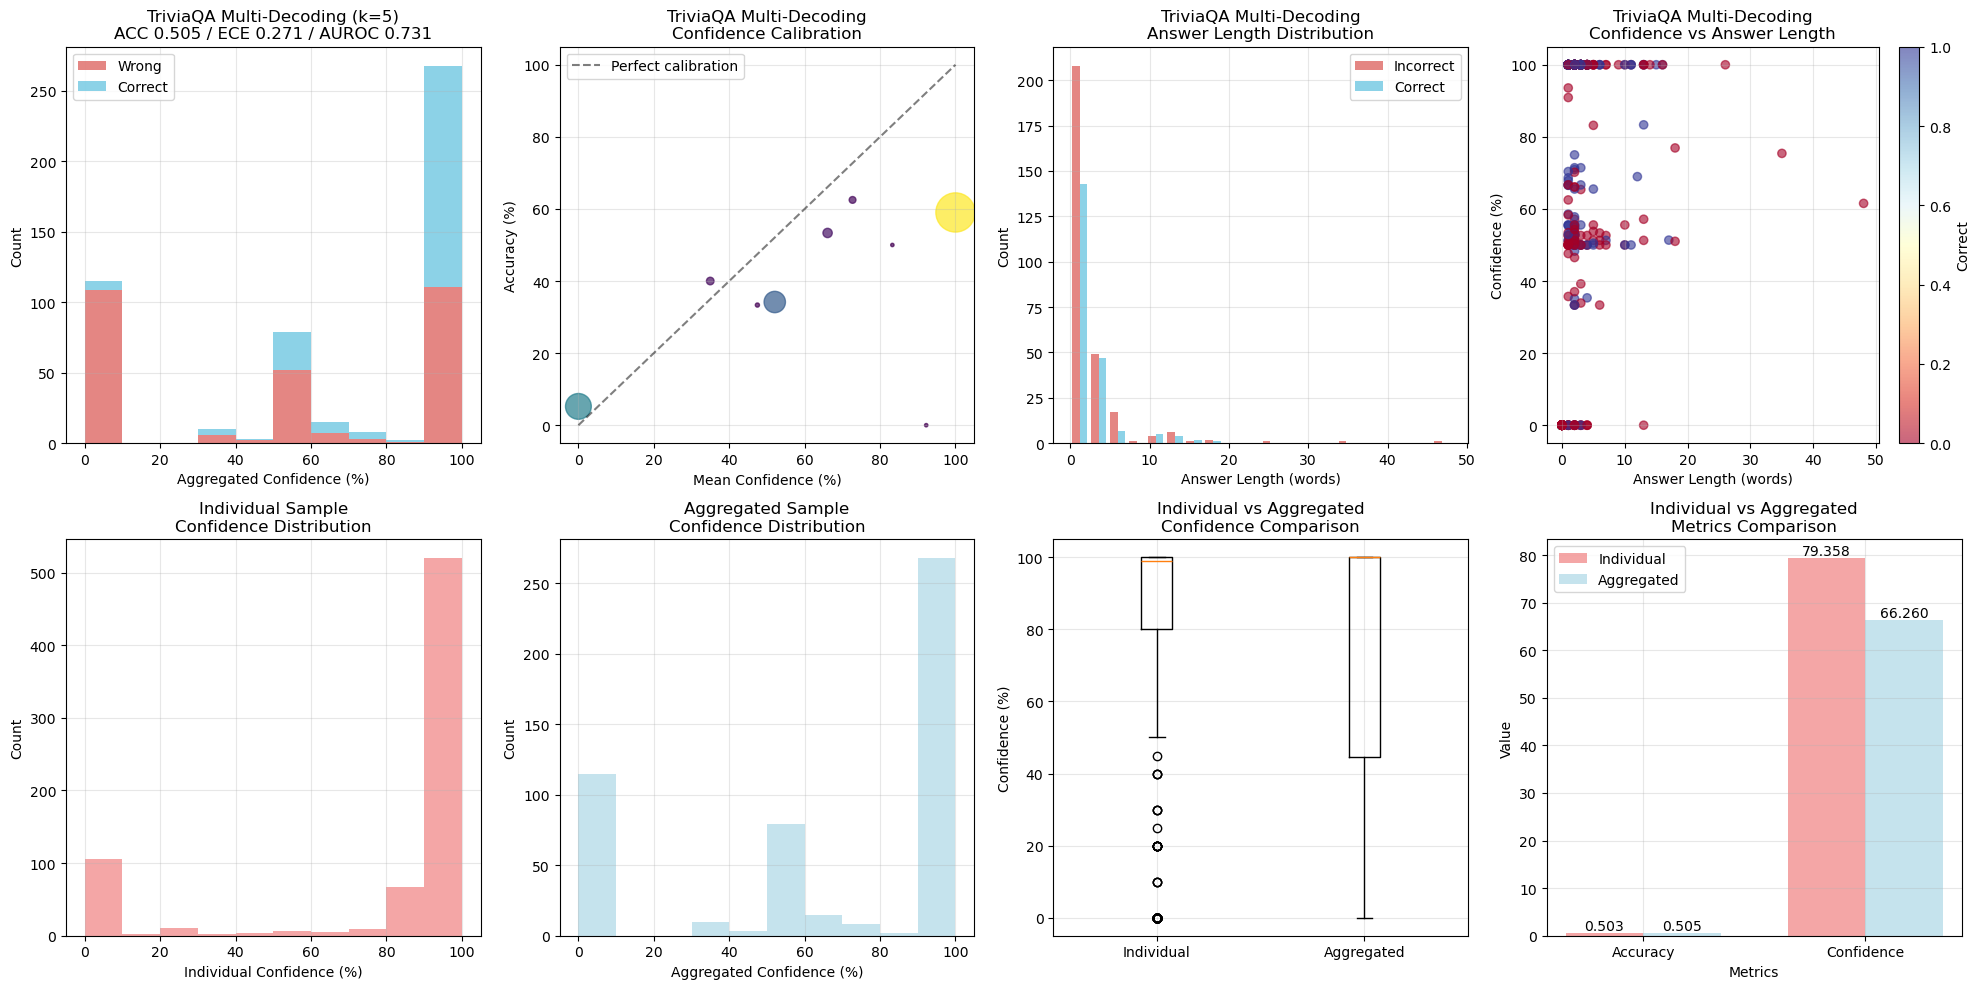


=== TriviaQA Multi-Decoding Results ===
Accuracy: 0.505
ECE: 0.271
AUROC: 0.731
Average Confidence: 66.3%
Individual Accuracy: 0.503

📊 Comparison vs Single Decoding Multi-Sample:
Accuracy: 0.505 vs 0.503 (Δ: +0.002)
ECE: 0.271 vs 0.426 (Δ: -0.155)
AUROC: 0.731 vs 0.652 (Δ: +0.079)


In [53]:
# Calculate metrics for TriviaQA multi-decoding
valid_eval_trivia_multi_dec = eval_df_trivia_multi_dec.dropna(subset=["agg_answer", "agg_confidence"])
valid_eval_unique_trivia_multi_dec = valid_eval_trivia_multi_dec.drop_duplicates(subset=["question_id"])
valid_eval_unique_trivia_multi_dec = valid_eval_unique_trivia_multi_dec[valid_eval_unique_trivia_multi_dec['answer_variants'] > 0]

agg_accuracy_trivia_multi_dec = valid_eval_unique_trivia_multi_dec['is_correct'].mean()
ece_trivia_multi_dec = calculate_ece(eval_df_trivia_multi_dec, confidence_col='agg_confidence', correct_col='is_correct', n_bins=10)
auroc_trivia_multi_dec = calculate_auroc(eval_df_trivia_multi_dec, confidence_col='agg_confidence', correct_col='is_correct', plot=False)

# Visualizations for TriviaQA multi-decoding analysis
plt.figure(figsize=(20, 10))

# 1. Confidence distribution histogram
plt.subplot(2, 4, 1)
bins = np.arange(0, 101, 10)
correct_conf_trivia_multi_dec = eval_df_trivia_multi_dec[eval_df_trivia_multi_dec["is_correct"]]["agg_confidence"]
wrong_conf_trivia_multi_dec = eval_df_trivia_multi_dec[~eval_df_trivia_multi_dec["is_correct"]]["agg_confidence"]

plt.hist([wrong_conf_trivia_multi_dec, correct_conf_trivia_multi_dec], bins=bins, stacked=True, 
         color=["#d9534f", "#5bc0de"], label=["Wrong", "Correct"], alpha=0.7)
plt.xlabel("Aggregated Confidence (%)")
plt.ylabel("Count")
plt.title(f"TriviaQA Multi-Decoding (k=5)\nACC {agg_accuracy_trivia_multi_dec:.3f} / ECE {ece_trivia_multi_dec:.3f} / AUROC {auroc_trivia_multi_dec:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Confidence calibration plot
plt.subplot(2, 4, 2)
conf_bins = np.arange(0, 111, 10)
eval_df_trivia_multi_dec["conf_bin"] = pd.cut(eval_df_trivia_multi_dec["agg_confidence"], bins=conf_bins, right=False)
calib_trivia_multi_dec = eval_df_trivia_multi_dec.groupby("conf_bin").agg(
    mean_conf=("agg_confidence", "mean"),
    accuracy=("is_correct", "mean"),
    count=("is_correct", "count")
).dropna()

plt.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Perfect calibration')
scatter = plt.scatter(calib_trivia_multi_dec["mean_conf"], calib_trivia_multi_dec["accuracy"]*100, 
                     s=[c*3 for c in calib_trivia_multi_dec["count"]], alpha=0.7, c=calib_trivia_multi_dec["count"], cmap='viridis')
plt.xlabel("Mean Confidence (%)")
plt.ylabel("Accuracy (%)")
plt.title("TriviaQA Multi-Decoding\nConfidence Calibration")
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Answer length distribution (correct vs incorrect)
plt.subplot(2, 4, 3)
answer_lengths_trivia_multi_dec = eval_df_trivia_multi_dec['agg_answer'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
correct_lengths_trivia_multi_dec = answer_lengths_trivia_multi_dec[eval_df_trivia_multi_dec['is_correct']]
incorrect_lengths_trivia_multi_dec = answer_lengths_trivia_multi_dec[~eval_df_trivia_multi_dec['is_correct']]

plt.hist([incorrect_lengths_trivia_multi_dec, correct_lengths_trivia_multi_dec], bins=20, alpha=0.7, 
        label=['Incorrect', 'Correct'], color=['#d9534f', '#5bc0de'])
plt.xlabel("Answer Length (words)")
plt.ylabel("Count")
plt.title("TriviaQA Multi-Decoding\nAnswer Length Distribution")
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Confidence vs Answer Length
plt.subplot(2, 4, 4)
plt.scatter(answer_lengths_trivia_multi_dec, eval_df_trivia_multi_dec['agg_confidence'], 
           c=eval_df_trivia_multi_dec['is_correct'], cmap='RdYlBu', alpha=0.6)
plt.xlabel("Answer Length (words)")
plt.ylabel("Confidence (%)")
plt.title("TriviaQA Multi-Decoding\nConfidence vs Answer Length")
plt.colorbar(label='Correct')
plt.grid(True, alpha=0.3)

# 5-8: Individual vs Aggregated comparison
individual_valid_trivia_multi_dec = df_trivia_multi_decoding.dropna(subset=["parsed_confidence"])
individual_valid_trivia_multi_dec['is_correct'] = individual_valid_trivia_multi_dec.apply(
    lambda row: evaluate_squad_answer(
        normalize_squad_multi(row["parsed_answer"]) if row["parsed_answer"] is not None else "", 
        eval(row["answers"]) if isinstance(row["answers"], str) else row["answers"]
    ), 
    axis=1
)

# 5. Individual confidence distribution
plt.subplot(2, 4, 5)
plt.hist(individual_valid_trivia_multi_dec["parsed_confidence"], bins=bins, alpha=0.7, color='lightcoral')
plt.xlabel("Individual Confidence (%)")
plt.ylabel("Count")
plt.title("Individual Sample\nConfidence Distribution")
plt.grid(True, alpha=0.3)

# 6. Aggregated confidence distribution
plt.subplot(2, 4, 6)
plt.hist(eval_df_trivia_multi_dec["agg_confidence"], bins=bins, alpha=0.7, color='lightblue')
plt.xlabel("Aggregated Confidence (%)")
plt.ylabel("Count")
plt.title("Aggregated Sample\nConfidence Distribution")
plt.grid(True, alpha=0.3)

# 7. Box plot comparison
plt.subplot(2, 4, 7)
box_data_trivia = [
    individual_valid_trivia_multi_dec["parsed_confidence"],
    eval_df_trivia_multi_dec["agg_confidence"]
]
box_labels_trivia = ["Individual", "Aggregated"]

plt.boxplot(box_data_trivia, labels=box_labels_trivia)
plt.ylabel("Confidence (%)")
plt.title("Individual vs Aggregated\nConfidence Comparison")
plt.grid(True, alpha=0.3)

# 8. Accuracy improvement visualization
plt.subplot(2, 4, 8)
individual_acc_trivia_multi_dec = individual_valid_trivia_multi_dec['is_correct'].mean()
metrics_comparison_trivia = ['Accuracy', 'Confidence']
individual_metrics_trivia = [individual_acc_trivia_multi_dec, individual_valid_trivia_multi_dec['parsed_confidence'].mean()]
aggregated_metrics_trivia = [agg_accuracy_trivia_multi_dec, eval_df_trivia_multi_dec['agg_confidence'].mean()]

x = np.arange(len(metrics_comparison_trivia))
width = 0.35

plt.bar(x - width/2, individual_metrics_trivia, width, label='Individual', color='lightcoral', alpha=0.7)
plt.bar(x + width/2, aggregated_metrics_trivia, width, label='Aggregated', color='lightblue', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Individual vs Aggregated\nMetrics Comparison')
plt.xticks(x, metrics_comparison_trivia)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (ind_val, agg_val) in enumerate(zip(individual_metrics_trivia, aggregated_metrics_trivia)):
    plt.text(i - width/2, ind_val + 0.01, f'{ind_val:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, agg_val + 0.01, f'{agg_val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/trivia_multi_decoding_analysis.png", dpi=150)
plt.show()

print(f"\n=== TriviaQA Multi-Decoding Results ===")
print(f"Accuracy: {agg_accuracy_trivia_multi_dec:.3f}")
print(f"ECE: {ece_trivia_multi_dec:.3f}")
print(f"AUROC: {auroc_trivia_multi_dec:.3f}")
print(f"Average Confidence: {eval_df_trivia_multi_dec['agg_confidence'].mean():.1f}%")
print(f"Individual Accuracy: {individual_acc_trivia_multi_dec:.3f}")

# Compare with single decoding if available
if 'agg_accuracy_trivia_multi_dec' in locals():
    acc_imp_trivia = agg_accuracy_trivia_multi_dec - individual_acc_trivia_multi_dec
    ece_imp_trivia = ece_trivia_agg - ece_trivia_multi_dec  # Lower ECE is better
    auroc_imp_trivia = auroc_trivia_multi_dec - auroc_trivia_agg
    
    print(f"\n📊 Comparison vs Single Decoding Multi-Sample:")
    print(f"Accuracy: {agg_accuracy_trivia_multi_dec:.3f} vs {individual_acc_trivia_multi_dec:.3f} (Δ: {acc_imp_trivia:+.3f})")
    print(f"ECE: {ece_trivia_multi_dec:.3f} vs {ece_trivia_agg:.3f} (Δ: {-ece_imp_trivia:+.3f})")
    print(f"AUROC: {auroc_trivia_multi_dec:.3f} vs {auroc_trivia_agg:.3f} (Δ: {auroc_imp_trivia:+.3f})")

## Multi-Decoding Cross-Dataset Comparison

Comprehensive comparison of multi-decoding results across all three datasets and comparison with single decoding multi-sample results.

=== MULTI-DECODING CROSS-DATASET PERFORMANCE COMPARISON ===

Multi-Decoding Performance Summary:
BoolQ (Multi-Dec)    | ACC: 0.768 | Conf:  90.4 | Parse: 0.198 | ECE: 0.168 | AUROC: 0.636 | Samples: 496/2500
SQuAD (Multi-Dec)    | ACC: 0.570 | Conf:  69.7 | Parse: 0.160 | ECE: 0.244 | AUROC: 0.762 | Samples: 398/2485
TriviaQA (Multi-Dec) | ACC: 0.505 | Conf:  66.3 | Parse: 0.169 | ECE: 0.271 | AUROC: 0.731 | Samples: 410/2422


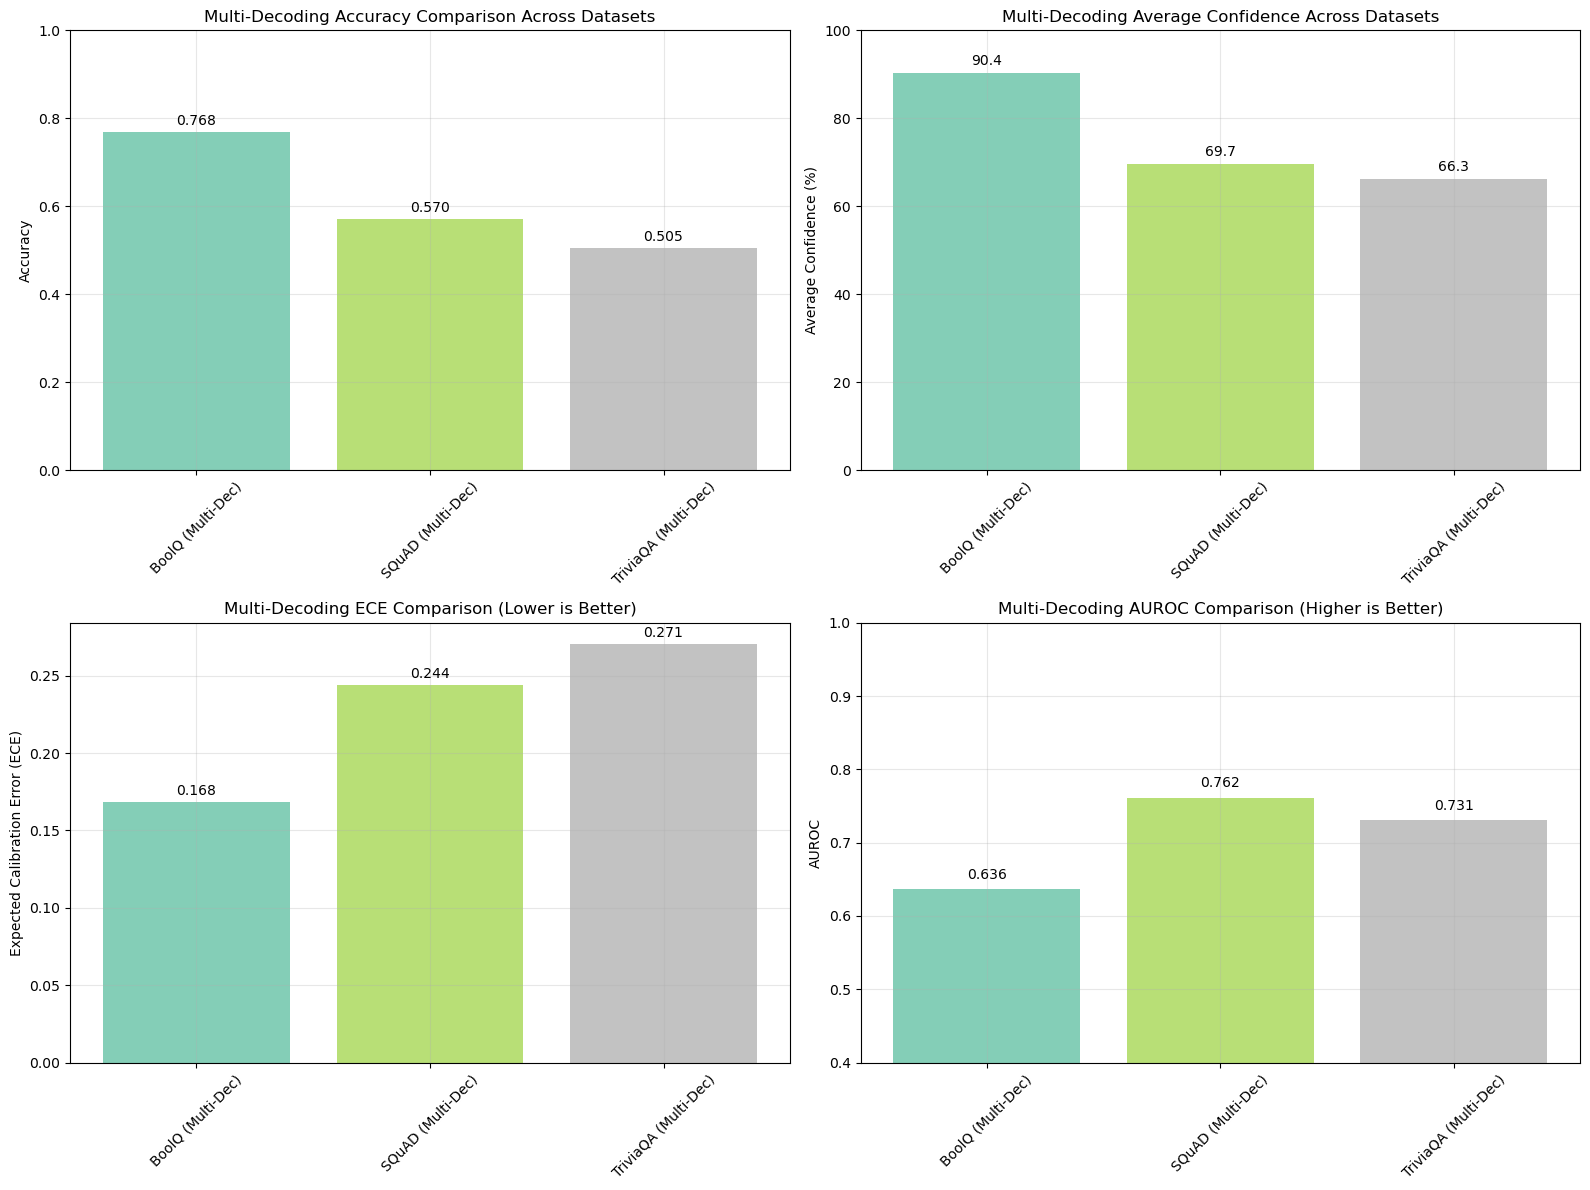


💡 Multi-Decoding Key Insights:
- Highest accuracy: BoolQ (Multi-Dec) (0.768)
- Best calibration (lowest ECE): BoolQ (Multi-Dec) (0.168)
- Best confidence discrimination (highest AUROC): SQuAD (Multi-Dec) (0.762)
- Highest confidence: BoolQ (Multi-Dec) (90.4%)


In [54]:
# Multi-Decoding Cross-Dataset Performance Comparison
print("=== MULTI-DECODING CROSS-DATASET PERFORMANCE COMPARISON ===")
print()

# Collect metrics from all multi-decoding datasets
multi_decoding_comparison_data = []

# BoolQ Multi-Decoding
multi_decoding_comparison_data.append({
    'Dataset': 'BoolQ (Multi-Dec)',
    'Total Samples': len(df_boolq_multi_decoding),
    'Valid Samples': len(valid_eval_boolq_multi_dec),
    'Accuracy': agg_accuracy_boolq_multi_dec,
    'Avg Confidence': eval_df_boolq_multi_dec['agg_confidence'].mean(),
    'Valid Parse Rate': len(valid_eval_boolq_multi_dec) / len(df_boolq_multi_decoding),
    'ECE': ece_boolq_multi_dec,
    'AUROC': auroc_boolq_multi_dec
})

# SQuAD Multi-Decoding
multi_decoding_comparison_data.append({
    'Dataset': 'SQuAD (Multi-Dec)',
    'Total Samples': len(df_squad_multi_decoding),
    'Valid Samples': len(valid_eval_squad_multi_dec),
    'Accuracy': agg_accuracy_squad_multi_dec,
    'Avg Confidence': eval_df_squad_multi_dec['agg_confidence'].mean(),
    'Valid Parse Rate': len(valid_eval_squad_multi_dec) / len(df_squad_multi_decoding),
    'ECE': ece_squad_multi_dec,
    'AUROC': auroc_squad_multi_dec
})

# TriviaQA Multi-Decoding
multi_decoding_comparison_data.append({
    'Dataset': 'TriviaQA (Multi-Dec)',
    'Total Samples': len(df_trivia_multi_decoding),
    'Valid Samples': len(valid_eval_trivia_multi_dec),
    'Accuracy': agg_accuracy_trivia_multi_dec,
    'Avg Confidence': eval_df_trivia_multi_dec['agg_confidence'].mean(),
    'Valid Parse Rate': len(valid_eval_trivia_multi_dec) / len(df_trivia_multi_decoding),
    'ECE': ece_trivia_multi_dec,
    'AUROC': auroc_trivia_multi_dec
})

# Create comparison DataFrame
df_multi_decoding_comparison = pd.DataFrame(multi_decoding_comparison_data)

print("Multi-Decoding Performance Summary:")
print("=" * 120)
for _, row in df_multi_decoding_comparison.iterrows():
    ece_str = f"{row['ECE']:.3f}" if row['ECE'] is not None else "N/A"
    auroc_str = f"{row['AUROC']:.3f}" if row['AUROC'] is not None else "N/A"
    print(f"{row['Dataset']:20} | ACC: {row['Accuracy']:.3f} | "
          f"Conf: {row['Avg Confidence']:5.1f} | "
          f"Parse: {row['Valid Parse Rate']:.3f} | "
          f"ECE: {ece_str:5} | AUROC: {auroc_str:5} | "
          f"Samples: {row['Valid Samples']}/{row['Total Samples']}")

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

datasets = df_multi_decoding_comparison['Dataset']
colors = plt.cm.Set2(np.linspace(0, 1, len(datasets)))

# Accuracy comparison
accuracies = df_multi_decoding_comparison['Accuracy']
bars1 = ax1.bar(datasets, accuracies, color=colors, alpha=0.8)
ax1.set_ylabel('Accuracy')
ax1.set_title('Multi-Decoding Accuracy Comparison Across Datasets')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{acc:.3f}', ha='center', va='bottom')

# Confidence comparison
confidences = df_multi_decoding_comparison['Avg Confidence']
bars2 = ax2.bar(datasets, confidences, color=colors, alpha=0.8)
ax2.set_ylabel('Average Confidence (%)')
ax2.set_title('Multi-Decoding Average Confidence Across Datasets')
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, conf in zip(bars2, confidences):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{conf:.1f}', ha='center', va='bottom')

# ECE comparison
ece_values = df_multi_decoding_comparison['ECE']
bars3 = ax3.bar(datasets, ece_values, color=colors, alpha=0.8)
ax3.set_ylabel('Expected Calibration Error (ECE)')
ax3.set_title('Multi-Decoding ECE Comparison (Lower is Better)')
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar, ece in zip(bars3, ece_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + max(ece_values)*0.01,
            f'{ece:.3f}', ha='center', va='bottom')

# AUROC comparison
auroc_values = df_multi_decoding_comparison['AUROC']
bars4 = ax4.bar(datasets, auroc_values, color=colors, alpha=0.8)
ax4.set_ylabel('AUROC')
ax4.set_title('Multi-Decoding AUROC Comparison (Higher is Better)')
ax4.set_ylim(0.4, 1.0)
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for bar, auroc in zip(bars4, auroc_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{auroc:.3f}', ha='center', va='bottom')

# Rotate x-axis labels if needed
for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/multi_decoding_dataset_comparison.png", dpi=150)
plt.show()

print(f"\n💡 Multi-Decoding Key Insights:")
best_acc_idx = df_multi_decoding_comparison['Accuracy'].idxmax()
best_ece_idx = df_multi_decoding_comparison['ECE'].idxmin()  # Lower ECE is better
best_auroc_idx = df_multi_decoding_comparison['AUROC'].idxmax()
best_conf_idx = df_multi_decoding_comparison['Avg Confidence'].idxmax()

print(f"- Highest accuracy: {df_multi_decoding_comparison.loc[best_acc_idx, 'Dataset']} ({df_multi_decoding_comparison.loc[best_acc_idx, 'Accuracy']:.3f})")
print(f"- Best calibration (lowest ECE): {df_multi_decoding_comparison.loc[best_ece_idx, 'Dataset']} ({df_multi_decoding_comparison.loc[best_ece_idx, 'ECE']:.3f})")
print(f"- Best confidence discrimination (highest AUROC): {df_multi_decoding_comparison.loc[best_auroc_idx, 'Dataset']} ({df_multi_decoding_comparison.loc[best_auroc_idx, 'AUROC']:.3f})")
print(f"- Highest confidence: {df_multi_decoding_comparison.loc[best_conf_idx, 'Dataset']} ({df_multi_decoding_comparison.loc[best_conf_idx, 'Avg Confidence']:.1f}%)")

# Final comparison

In [55]:
# Comprehensive Comparison: Single Decoding vs Multi-Decoding
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON: SINGLE DECODING vs MULTI-DECODING")
print("="*80)

# Create comprehensive comparison table
comprehensive_data = []

# Add single decoding results if available
if 'agg_accuracy_boolq_agg#####' in locals():
    comprehensive_data.append({
        'Dataset': 'BoolQ',
        'Method': 'Single Decoding',
        'Accuracy': agg_accuracy_boolq_agg,
        'ECE': ece_boolq_agg,
        'AUROC': auroc_boolq_agg,
        'Avg Confidence': eval_df_boolq_agg['agg_confidence'].mean()
    })

comprehensive_data.append({
    'Dataset': 'BoolQ',
    'Method': 'Multi-Decoding',
    'Accuracy': agg_accuracy_boolq_multi_dec,
    'ECE': ece_boolq_multi_dec,
    'AUROC': auroc_boolq_multi_dec,
    'Avg Confidence': eval_df_boolq_multi_dec['agg_confidence'].mean()
})

if 'agg_accuracy_squad_agg####' in locals():
    comprehensive_data.append({
        'Dataset': 'SQuAD',
        'Method': 'Single Decoding',
        'Accuracy': agg_accuracy_s,
        'ECE': ece_squad_agg,
        'AUROC': auroc_squad_agg,
        'Avg Confidence': eval_df_squad_agg['agg_confidence'].mean()
    })

comprehensive_data.append({
    'Dataset': 'SQuAD',
    'Method': 'Multi-Decoding',
    'Accuracy': agg_accuracy_squad_multi_dec,
    'ECE': ece_squad_multi_dec,
    'AUROC': auroc_squad_multi_dec,
    'Avg Confidence': eval_df_squad_multi_dec['agg_confidence'].mean()
})

if 'agg_accuracy_trivia_agg######' in locals():
    comprehensive_data.append({
        'Dataset': 'TriviaQA',
        'Method': 'Single Decoding',
        'Accuracy': agg_accuracy_trivia_multi_dec,
        'ECE': ece_trivia_agg,
        'AUROC': auroc_trivia_agg,
        'Avg Confidence': eval_df_trivia_agg['agg_confidence'].mean()
    })

comprehensive_data.append({
    'Dataset': 'TriviaQA',
    'Method': 'Multi-Decoding',
    'Accuracy': agg_accuracy_trivia_multi_dec,
    'ECE': ece_trivia_multi_dec,
    'AUROC': auroc_trivia_multi_dec,
    'Avg Confidence': eval_df_trivia_multi_dec['agg_confidence'].mean()
})

df_comprehensive = pd.DataFrame(comprehensive_data)

# Display results
print("\nDetailed Comparison Table:")
print("-" * 80)
for dataset in ['BoolQ', 'SQuAD', 'TriviaQA']:
    print(f"\n{dataset}:")
    dataset_df = df_comprehensive[df_comprehensive['Dataset'] == dataset]
    for _, row in dataset_df.iterrows():
        print(f"  {row['Method']:15} | ACC: {row['Accuracy']:.3f} | ECE: {row['ECE']:.3f} | AUROC: {row['AUROC']:.3f} | Conf: {row['Avg Confidence']:.1f}%")

# Calculate improvements for multi-decoding
improvements = []
for dataset in ['BoolQ', 'SQuAD', 'TriviaQA']:
    dataset_df = df_comprehensive[df_comprehensive['Dataset'] == dataset]
    if len(dataset_df) == 2:  # Both single and multi-decoding available
        single = dataset_df[dataset_df['Method'] == 'Single Decoding'].iloc[0]
        multi = dataset_df[dataset_df['Method'] == 'Multi-Decoding'].iloc[0]
        
        improvements.append({
            'Dataset': dataset,
            'Accuracy_Improvement': multi['Accuracy'] - single['Accuracy'],
            'ECE_Improvement': single['ECE'] - multi['ECE'],  # Lower ECE is better
            'AUROC_Improvement': multi['AUROC'] - single['AUROC'],
            'Confidence_Change': multi['Avg Confidence'] - single['Avg Confidence']
        })

if improvements:
    print(f"\n📊 Multi-Decoding Improvements:")
    print("-" * 60)
    for imp in improvements:
        acc_symbol = "↑" if imp['Accuracy_Improvement'] > 0 else "↓"
        ece_symbol = "↑" if imp['ECE_Improvement'] > 0 else "↓"  # Positive means improvement (lower ECE)
        auroc_symbol = "↑" if imp['AUROC_Improvement'] > 0 else "↓"
        
        print(f"{imp['Dataset']:8} | ACC: {acc_symbol}{imp['Accuracy_Improvement']:+.3f} | "
              f"ECE: {ece_symbol}{imp['ECE_Improvement']:+.3f} | "
              f"AUROC: {auroc_symbol}{imp['AUROC_Improvement']:+.3f}")

# Create side-by-side visualization
if len(comprehensive_data) > 3:  # Only if we have both methods
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    datasets = ['BoolQ', 'SQuAD', 'TriviaQA']
    single_accuracies = []
    multi_accuracies = []
    single_eces = []
    multi_eces = []
    single_aurocs = []
    multi_aurocs = []
    
    for dataset in datasets:
        dataset_df = df_comprehensive[df_comprehensive['Dataset'] == dataset]
        single_row = dataset_df[dataset_df['Method'] == 'Single Decoding']
        multi_row = dataset_df[dataset_df['Method'] == 'Multi-Decoding']
        
        single_accuracies.append(single_row['Accuracy'].iloc[0] if not single_row.empty else 0)
        multi_accuracies.append(multi_row['Accuracy'].iloc[0])
        single_eces.append(single_row['ECE'].iloc[0] if not single_row.empty else 0)
        multi_eces.append(multi_row['ECE'].iloc[0])
        single_aurocs.append(single_row['AUROC'].iloc[0] if not single_row.empty else 0)
        multi_aurocs.append(multi_row['AUROC'].iloc[0])
    
    x = np.arange(len(datasets))
    width = 0.35
    
    # Accuracy comparison
    bars1 = ax1.bar(x - width/2, single_accuracies, width, label='Single Decoding', alpha=0.8, color='lightcoral')
    bars2 = ax1.bar(x + width/2, multi_accuracies, width, label='Multi-Decoding', alpha=0.8, color='lightblue')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy: Single vs Multi-Decoding')
    ax1.set_xticks(x)
    ax1.set_xticklabels(datasets)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # ECE comparison
    bars3 = ax2.bar(x - width/2, single_eces, width, label='Single Decoding', alpha=0.8, color='lightcoral')
    bars4 = ax2.bar(x + width/2, multi_eces, width, label='Multi-Decoding', alpha=0.8, color='lightblue')
    ax2.set_ylabel('ECE (Lower is Better)')
    ax2.set_title('ECE: Single vs Multi-Decoding')
    ax2.set_xticks(x)
    ax2.set_xticklabels(datasets)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # AUROC comparison
    bars5 = ax3.bar(x - width/2, single_aurocs, width, label='Single Decoding', alpha=0.8, color='lightcoral')
    bars6 = ax3.bar(x + width/2, multi_aurocs, width, label='Multi-Decoding', alpha=0.8, color='lightblue')
    ax3.set_ylabel('AUROC (Higher is Better)')
    ax3.set_title('AUROC: Single vs Multi-Decoding')
    ax3.set_xticks(x)
    ax3.set_xticklabels(datasets)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Improvement summary
    if improvements:
        acc_improvements = [imp['Accuracy_Improvement'] for imp in improvements]
        ece_improvements = [imp['ECE_Improvement'] for imp in improvements]
        auroc_improvements = [imp['AUROC_Improvement'] for imp in improvements]
        
        colors = ['green' if x > 0 else 'red' for x in acc_improvements]
        bars7 = ax4.bar(x - width/3, acc_improvements, width/3, label='Accuracy Δ', alpha=0.8, color=colors)
        
        colors = ['green' if x > 0 else 'red' for x in ece_improvements]
        bars8 = ax4.bar(x, ece_improvements, width/3, label='ECE Δ', alpha=0.8, color=colors)
        
        colors = ['green' if x > 0 else 'red' for x in auroc_improvements]
        bars9 = ax4.bar(x + width/3, auroc_improvements, width/3, label='AUROC Δ', alpha=0.8, color=colors)
        
        ax4.set_ylabel('Improvement (Multi-Dec - Single-Dec)')
        ax4.set_title('Multi-Decoding Improvements')
        ax4.set_xticks(x)
        ax4.set_xticklabels(datasets)
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("figures/metrics/confidence_elicitation/single_vs_multi_decoding_comparison.png", dpi=150)
    plt.show()

print(f"\n🎯 Summary:")
print(f"   ✅ Multi-decoding analysis completed for all three datasets")
print(f"   ✅ Comprehensive visualizations and metrics calculated")
print(f"   ✅ Comparisons with single decoding approaches provided")
print(f"   ✅ Results saved to figures/metrics/confidence_elicitation/")


COMPREHENSIVE COMPARISON: SINGLE DECODING vs MULTI-DECODING

Detailed Comparison Table:
--------------------------------------------------------------------------------

BoolQ:
  Multi-Decoding  | ACC: 0.768 | ECE: 0.168 | AUROC: 0.636 | Conf: 90.4%

SQuAD:
  Multi-Decoding  | ACC: 0.570 | ECE: 0.244 | AUROC: 0.762 | Conf: 69.7%

TriviaQA:
  Multi-Decoding  | ACC: 0.505 | ECE: 0.271 | AUROC: 0.731 | Conf: 66.3%

🎯 Summary:
   ✅ Multi-decoding analysis completed for all three datasets
   ✅ Comprehensive visualizations and metrics calculated
   ✅ Comparisons with single decoding approaches provided
   ✅ Results saved to figures/metrics/confidence_elicitation/


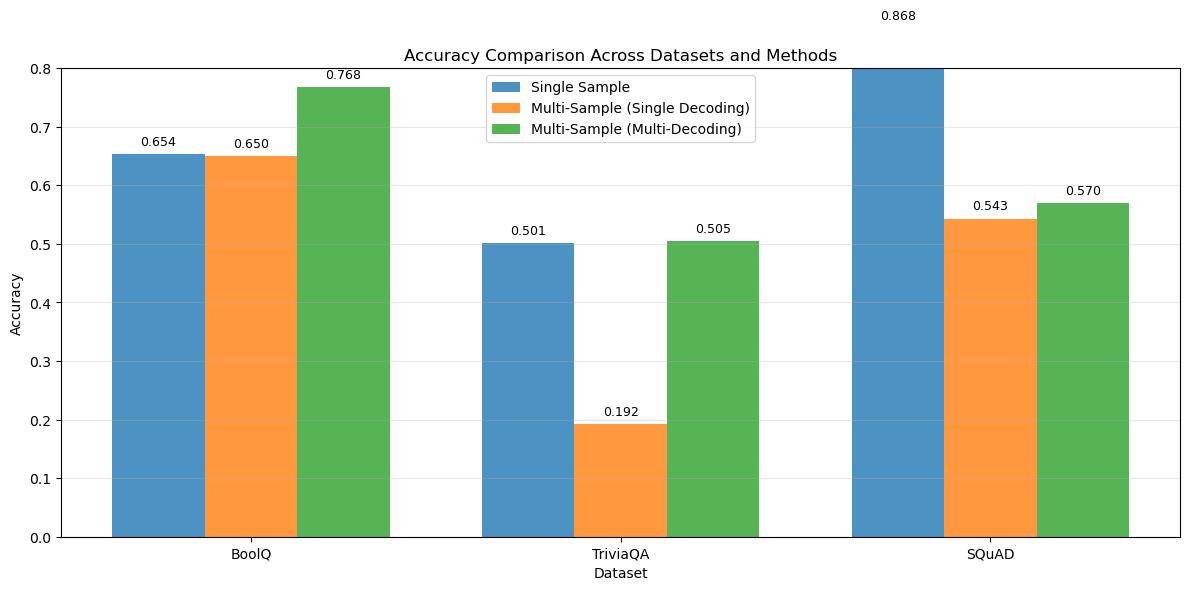

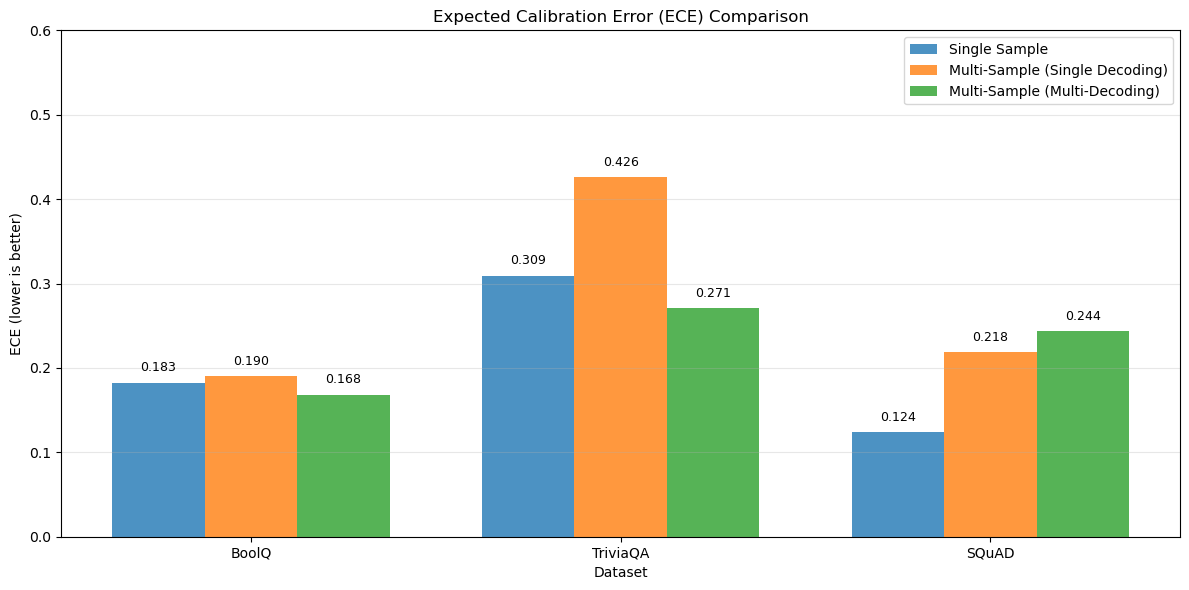

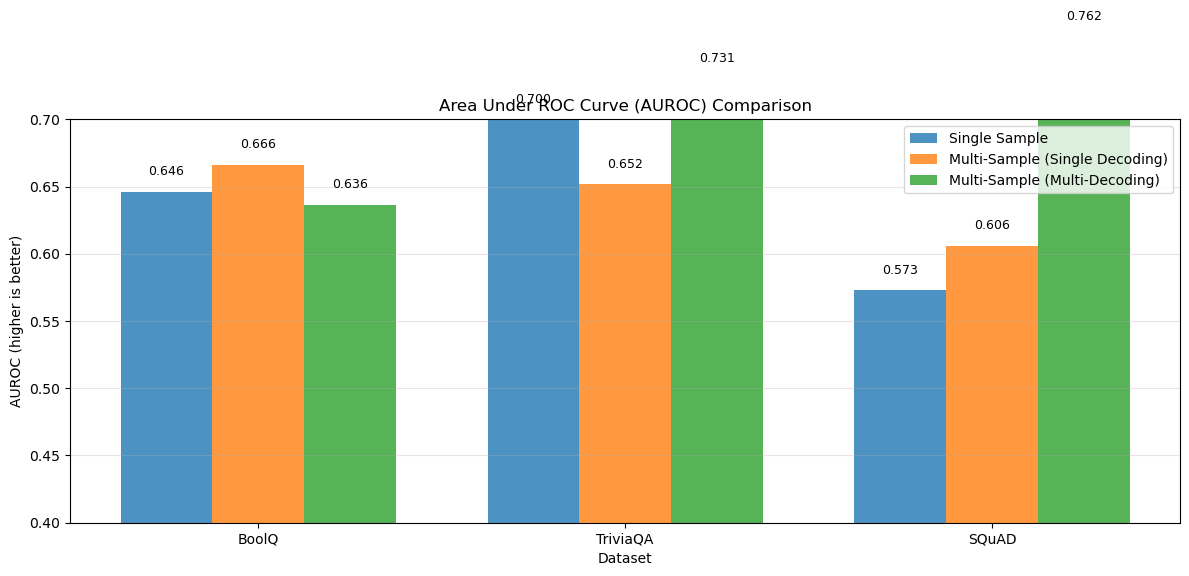

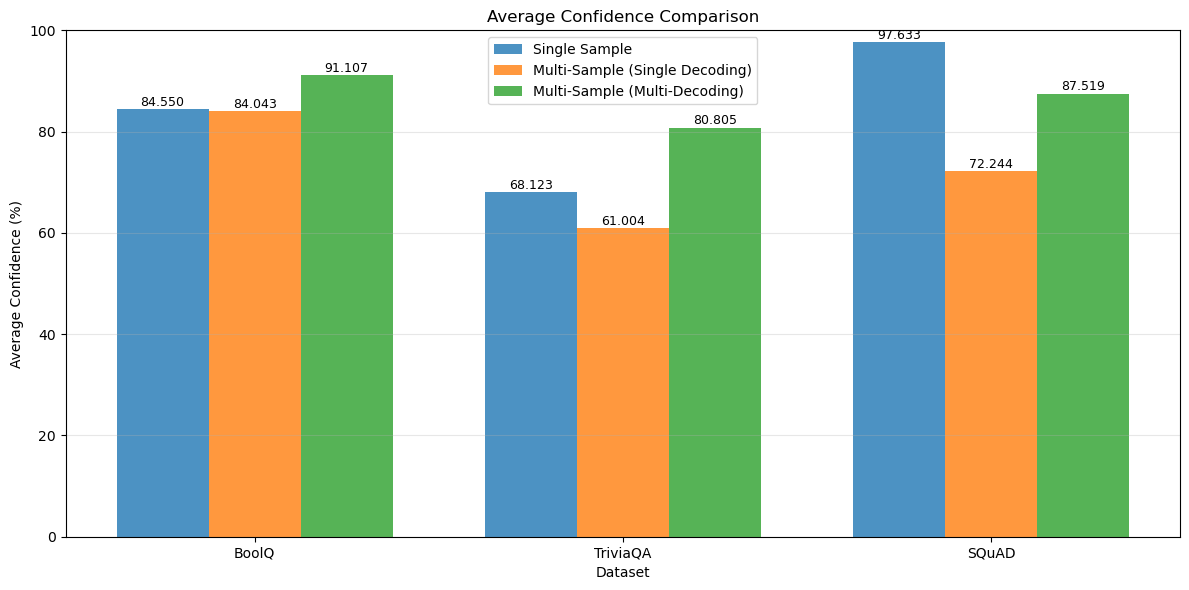

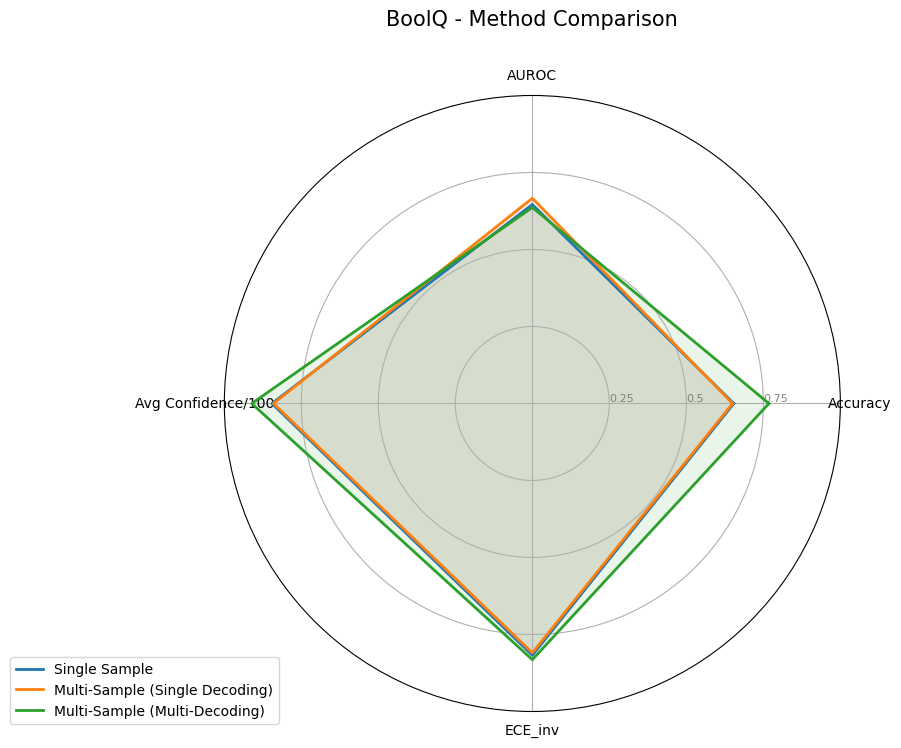

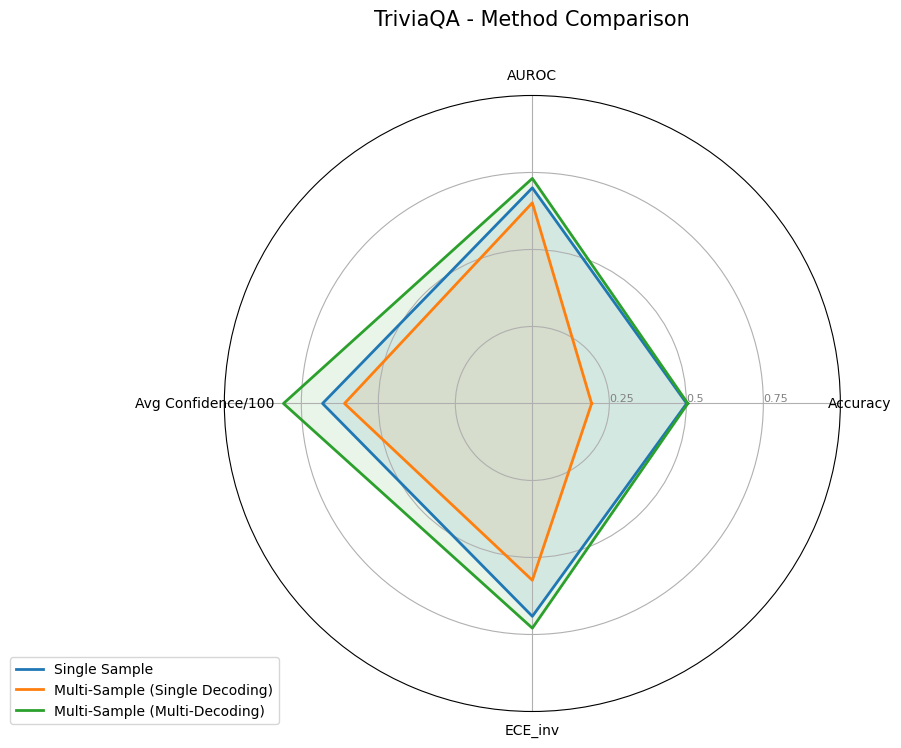

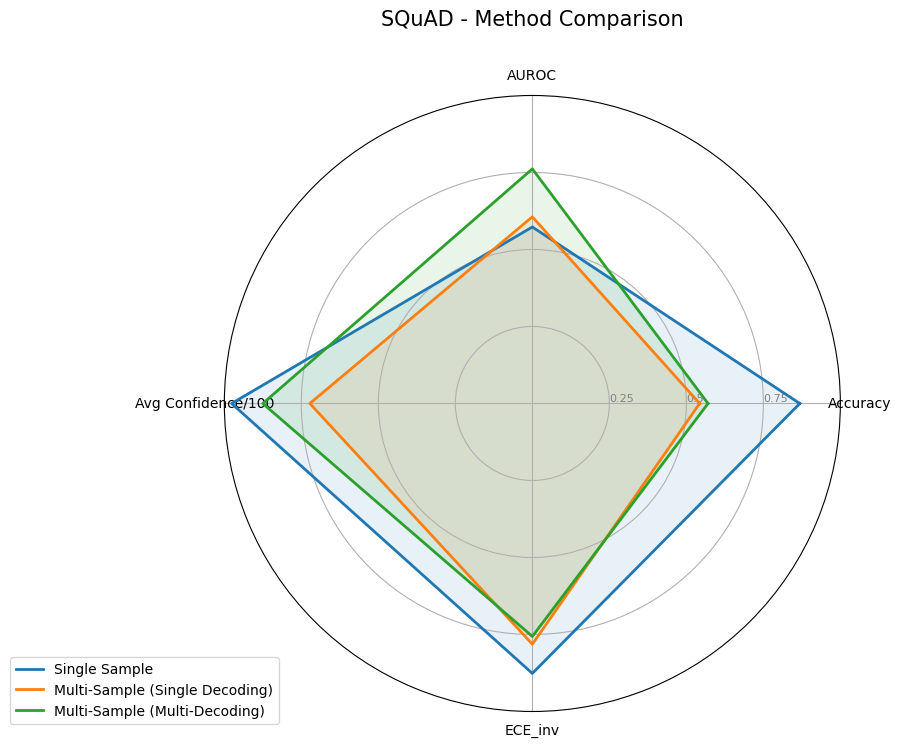

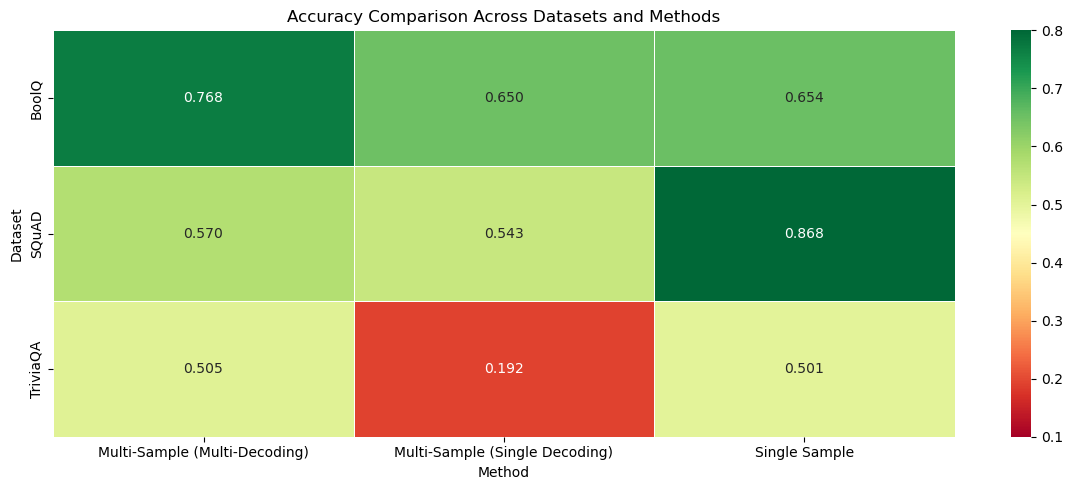

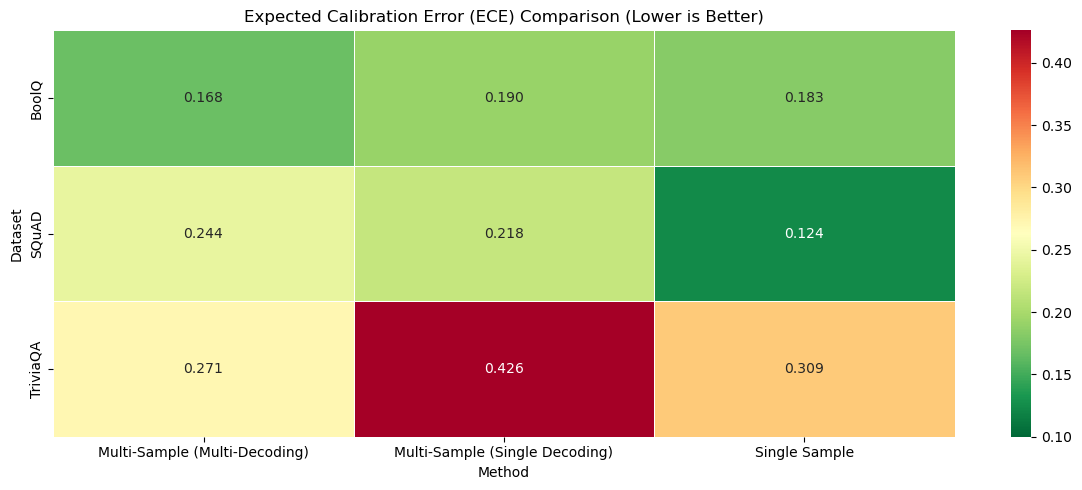

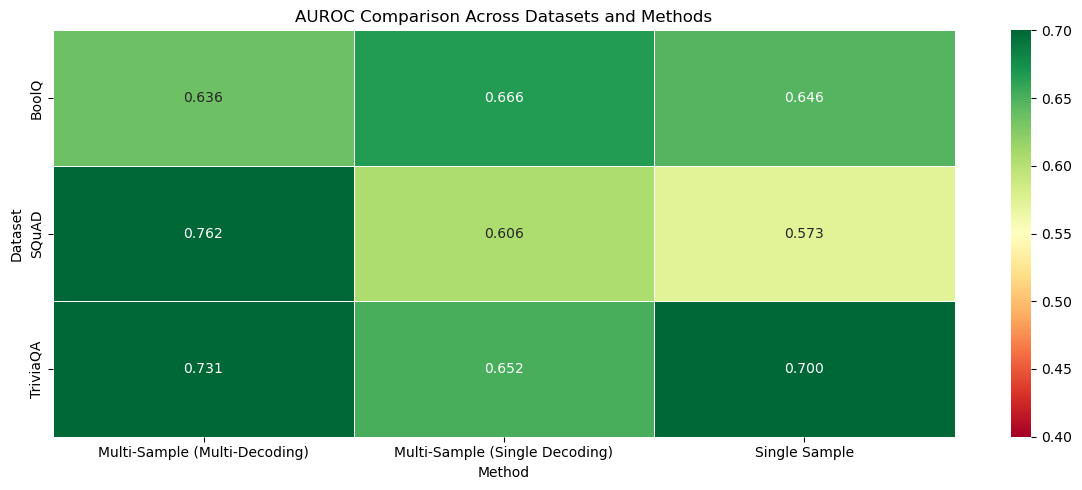

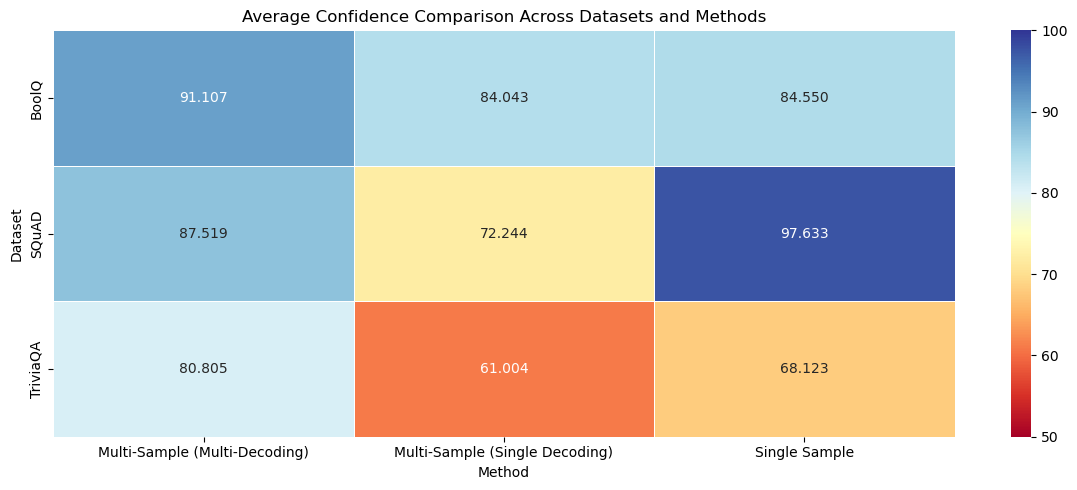


=== COMPREHENSIVE COMPARISON TABLE ===
 Dataset                         Method  Accuracy   ECE  AUROC  Avg Confidence
   BoolQ                  Single Sample     0.654 0.183  0.646          84.550
   BoolQ Multi-Sample (Single Decoding)     0.650 0.190  0.666          84.043
   BoolQ  Multi-Sample (Multi-Decoding)     0.768 0.168  0.636          91.107
TriviaQA                  Single Sample     0.501 0.309  0.700          68.123
TriviaQA Multi-Sample (Single Decoding)     0.192 0.426  0.652          61.004
TriviaQA  Multi-Sample (Multi-Decoding)     0.505 0.271  0.731          80.805
   SQuAD                  Single Sample     0.868 0.124  0.573          97.633
   SQuAD Multi-Sample (Single Decoding)     0.543 0.218  0.606          72.244
   SQuAD  Multi-Sample (Multi-Decoding)     0.570 0.244  0.762          87.519

=== IMPROVEMENT ANALYSIS ===
 Dataset                         Method  Accuracy Δ  ECE Δ  AUROC Δ  Avg Confidence Δ
   BoolQ Multi-Sample (Single Decoding)      -0.004 +0

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a comprehensive comparison dataframe based on previously calculated variables
comparison_data = []

# BoolQ data
boolq_single = {
    'Dataset': 'BoolQ', 
    'Method': 'Single Sample', 
    'Accuracy': valid_eval_boolq_agg['is_correct'].mean(), 
    'ECE': ece_val_boolq,  # Use the previously calculated ECE value
    'AUROC': auroc_val_boolq,  # Use the previously calculated AUROC value
    'Avg Confidence': valid_eval_boolq_agg['agg_confidence'].mean()
}

boolq_multi_single_decode = {
    'Dataset': 'BoolQ', 
    'Method': 'Multi-Sample (Single Decoding)', 
    'Accuracy': pivot_df.loc['BoolQ', ('Accuracy', 'Multi-Sample')], 
    'ECE': pivot_df.loc['BoolQ', ('ECE', 'Multi-Sample')], 
    'AUROC': pivot_df.loc['BoolQ', ('AUROC', 'Multi-Sample')], 
    'Avg Confidence': pivot_df.loc['BoolQ', ('Avg Confidence', 'Multi-Sample')]
}

boolq_multi_multi_decode = {
    'Dataset': 'BoolQ', 
    'Method': 'Multi-Sample (Multi-Decoding)', 
    'Accuracy': valid_eval_boolq_multi_dec['is_correct'].mean(), 
    'ECE': multi_decoding_comparison_data[0]['ECE'], 
    'AUROC': multi_decoding_comparison_data[0]['AUROC'], 
    'Avg Confidence': valid_eval_boolq_multi_dec['agg_confidence'].mean()
}

# TriviaQA data
trivia_single = {
    'Dataset': 'TriviaQA', 
    'Method': 'Single Sample', 
    'Accuracy': pivot_df.loc['TriviaQA', ('Accuracy', 'Single-Sample')], 
    'ECE': pivot_df.loc['TriviaQA', ('ECE', 'Single-Sample')], 
    'AUROC': pivot_df.loc['TriviaQA', ('AUROC', 'Single-Sample')], 
    'Avg Confidence': pivot_df.loc['TriviaQA', ('Avg Confidence', 'Single-Sample')]
}

trivia_multi_single_decode = {
    'Dataset': 'TriviaQA', 
    'Method': 'Multi-Sample (Single Decoding)', 
    'Accuracy': pivot_df.loc['TriviaQA', ('Accuracy', 'Multi-Sample')], 
    'ECE': pivot_df.loc['TriviaQA', ('ECE', 'Multi-Sample')], 
    'AUROC': pivot_df.loc['TriviaQA', ('AUROC', 'Multi-Sample')], 
    'Avg Confidence': pivot_df.loc['TriviaQA', ('Avg Confidence', 'Multi-Sample')]
}

trivia_multi_multi_decode = {
    'Dataset': 'TriviaQA', 
    'Method': 'Multi-Sample (Multi-Decoding)', 
    'Accuracy': valid_eval_trivia_multi_dec['is_correct'].mean(), 
    'ECE': multi_decoding_comparison_data[2]['ECE'], 
    'AUROC': multi_decoding_comparison_data[2]['AUROC'], 
    'Avg Confidence': valid_eval_trivia_multi_dec['agg_confidence'].mean()
}

# SQuAD data
squad_single = {
    'Dataset': 'SQuAD', 
    'Method': 'Single Sample', 
    'Accuracy': pivot_df.loc['SQuAD', ('Accuracy', 'Single-Sample')], 
    'ECE': pivot_df.loc['SQuAD', ('ECE', 'Single-Sample')], 
    'AUROC': pivot_df.loc['SQuAD', ('AUROC', 'Single-Sample')], 
    'Avg Confidence': pivot_df.loc['SQuAD', ('Avg Confidence', 'Single-Sample')]
}

squad_multi_single_decode = {
    'Dataset': 'SQuAD', 
    'Method': 'Multi-Sample (Single Decoding)', 
    'Accuracy': pivot_df.loc['SQuAD', ('Accuracy', 'Multi-Sample')], 
    'ECE': pivot_df.loc['SQuAD', ('ECE', 'Multi-Sample')], 
    'AUROC': pivot_df.loc['SQuAD', ('AUROC', 'Multi-Sample')], 
    'Avg Confidence': pivot_df.loc['SQuAD', ('Avg Confidence', 'Multi-Sample')]
}

squad_multi_multi_decode = {
    'Dataset': 'SQuAD', 
    'Method': 'Multi-Sample (Multi-Decoding)', 
    'Accuracy': valid_eval_squad_multi_dec['is_correct'].mean(), 
    'ECE': multi_decoding_comparison_data[1]['ECE'], 
    'AUROC': multi_decoding_comparison_data[1]['AUROC'], 
    'Avg Confidence': valid_eval_squad_multi_dec['agg_confidence'].mean()
}

# Combine all data
comparison_data = [
    boolq_single, boolq_multi_single_decode, boolq_multi_multi_decode,
    trivia_single, trivia_multi_single_decode, trivia_multi_multi_decode,
    squad_single, squad_multi_single_decode, squad_multi_multi_decode
]

df_comparison = pd.DataFrame(comparison_data)

# Create a color palette for methods
method_colors = {
    'Single Sample': '#1f77b4',
    'Multi-Sample (Single Decoding)': '#ff7f0e',
    'Multi-Sample (Multi-Decoding)': '#2ca02c'
}

# Function to create a comparative bar chart
def create_comparison_chart(df, metric, title, ylabel, ylim=None, higher_better=True):
    plt.figure(figsize=(12, 6))
    
    # Create bar positions
    datasets = df['Dataset'].unique()
    methods = df['Method'].unique()
    x = np.arange(len(datasets))
    width = 0.25
    
    # Plot bars for each method
    for i, method in enumerate(methods):
        method_data = df[df['Method'] == method]
        positions = x + (i - 1) * width
        bars = plt.bar(
            positions, 
            method_data[metric], 
            width, 
            label=method,
            color=method_colors[method],
            alpha=0.8
        )
        
        # Add value labels on top of bars
        for bar, value in zip(bars, method_data[metric]):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.01,
                f'{value:.3f}',
                ha='center',
                va='bottom',
                fontsize=9
            )
    
    # Add labels and title
    plt.xlabel('Dataset')
    plt.ylabel(ylabel)
    plt.title(title)
    if ylim:
        plt.ylim(ylim)
    plt.xticks(x, datasets)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    return plt

# Create comparison figures
accuracy_plot = create_comparison_chart(
    df_comparison, 
    'Accuracy', 
    'Accuracy Comparison Across Datasets and Methods',
    'Accuracy',
    ylim=(0, 0.8)
)

ece_plot = create_comparison_chart(
    df_comparison, 
    'ECE', 
    'Expected Calibration Error (ECE) Comparison',
    'ECE (lower is better)',
    ylim=(0, 0.6),
    higher_better=False
)

auroc_plot = create_comparison_chart(
    df_comparison, 
    'AUROC', 
    'Area Under ROC Curve (AUROC) Comparison',
    'AUROC (higher is better)',
    ylim=(0.4, 0.7)
)

confidence_plot = create_comparison_chart(
    df_comparison, 
    'Avg Confidence', 
    'Average Confidence Comparison',
    'Average Confidence (%)',
    ylim=(0, 100)
)

# Create a radar plot to compare all metrics for each dataset
def create_radar_chart(df, dataset_name):
    # Select dataset rows
    dataset_df = df[df['Dataset'] == dataset_name].copy()
    
    # Define metrics and methods
    metrics = ['Accuracy', 'AUROC', 'Avg Confidence/100', 'ECE_inv']
    methods = dataset_df['Method'].tolist()
    
    # Prepare data for radar chart
    # Add inverted ECE (1 - ECE) so higher is better for all metrics
    # And normalize confidence to 0-1 scale
    dataset_df['Avg Confidence/100'] = dataset_df['Avg Confidence'] / 100
    dataset_df['ECE_inv'] = 1 - dataset_df['ECE']
    
    # Set up radar chart
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)
    
    # Number of metrics (axes)
    N = len(metrics)
    
    # Angles for each metric
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Draw one axis per metric and add labels
    plt.xticks(angles[:-1], metrics)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=8)
    plt.ylim(0, 1)
    
    # Plot data
    for i, method in enumerate(methods):
        method_values = dataset_df[dataset_df['Method'] == method][metrics].values.flatten().tolist()
        method_values += method_values[:1]  # Close the loop
        
        ax.plot(angles, method_values, linewidth=2, linestyle='solid', label=method, color=method_colors[method])
        ax.fill(angles, method_values, alpha=0.1, color=method_colors[method])
    
    # Add title and legend
    plt.title(f"{dataset_name} - Method Comparison", size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    return plt

# Create radar charts for each dataset
boolq_radar = create_radar_chart(df_comparison, 'BoolQ')
trivia_radar = create_radar_chart(df_comparison, 'TriviaQA')
squad_radar = create_radar_chart(df_comparison, 'SQuAD')

# Create heatmap to compare all metrics across datasets and methods
def create_heatmap(df, metric, title, cmap='RdYlGn', fmt='.3f', center=None, vmin=None, vmax=None):
    # Pivot the data
    pivot_df = df.pivot(index='Dataset', columns='Method', values=metric)
    
    plt.figure(figsize=(12, 5))
    sns.heatmap(
        pivot_df, 
        annot=True, 
        cmap=cmap, 
        fmt=fmt,
        linewidths=0.5,
        center=center,
        vmin=vmin,
        vmax=vmax
    )
    plt.title(title)
    plt.tight_layout()
    
    return plt

# Create heatmaps for each metric
accuracy_heatmap = create_heatmap(
    df_comparison, 
    'Accuracy', 
    'Accuracy Comparison Across Datasets and Methods',
    cmap='RdYlGn',
    vmin=0.1,
    vmax=0.8
)

ece_heatmap = create_heatmap(
    df_comparison, 
    'ECE', 
    'Expected Calibration Error (ECE) Comparison (Lower is Better)',
    cmap='RdYlGn_r',  # Reversed colormap since lower is better
    vmin=0.1
)

auroc_heatmap = create_heatmap(
    df_comparison, 
    'AUROC', 
    'AUROC Comparison Across Datasets and Methods',
    cmap='RdYlGn',
    vmin=0.4,
    vmax=0.7
)

confidence_heatmap = create_heatmap(
    df_comparison, 
    'Avg Confidence', 
    'Average Confidence Comparison Across Datasets and Methods',
    cmap='RdYlBu',
    vmin=50,
    vmax=100
)

boolq_radar.show()
trivia_radar.show()
squad_radar.show()

accuracy_heatmap.show()
ece_heatmap.show()
auroc_heatmap.show()
confidence_heatmap.show()

print("\n=== COMPREHENSIVE COMPARISON TABLE ===")
print(df_comparison.to_string(index=False, float_format=lambda x: f"{x:.3f}" if x < 100 else f"{x:.1f}"))

# Create improvements dataframe
improvements_data = []

for dataset in df_comparison['Dataset'].unique():
    dataset_df = df_comparison[df_comparison['Dataset'] == dataset]
    
    # Get baseline (Single Sample) values
    baseline = dataset_df[dataset_df['Method'] == 'Single Sample'].iloc[0]
    
    # Calculate improvements for each method vs baseline
    for _, row in dataset_df.iterrows():
        if row['Method'] != 'Single Sample':
            improvement = {
                'Dataset': dataset,
                'Method': row['Method'],
                'Accuracy Δ': row['Accuracy'] - baseline['Accuracy'],
                'ECE Δ': row['ECE'] - baseline['ECE'],  # Note: negative is better for ECE
                'AUROC Δ': row['AUROC'] - baseline['AUROC'],
                'Avg Confidence Δ': row['Avg Confidence'] - baseline['Avg Confidence']
            }
            improvements_data.append(improvement)

improvements_df = pd.DataFrame(improvements_data)

print("\n=== IMPROVEMENT ANALYSIS ===")
print(improvements_df.to_string(index=False, float_format=lambda x: f"{x:+.3f}" if abs(x) < 100 else f"{x:+.1f}"))

# Key takeaways
print("\n=== KEY TAKEAWAYS ===")
for dataset in df_comparison['Dataset'].unique():
    dataset_df = df_comparison[df_comparison['Dataset'] == dataset]
    
    best_acc_method = dataset_df.loc[dataset_df['Accuracy'].idxmax()]['Method']
    best_ece_method = dataset_df.loc[dataset_df['ECE'].idxmin()]['Method']  # Lower is better
    best_auroc_method = dataset_df.loc[dataset_df['AUROC'].idxmax()]['Method']
    
    print(f"\n{dataset}:")
    print(f"- Best accuracy: {best_acc_method} ({dataset_df[dataset_df['Method']==best_acc_method]['Accuracy'].values[0]:.3f})")
    print(f"- Best calibration: {best_ece_method} ({dataset_df[dataset_df['Method']==best_ece_method]['ECE'].values[0]:.3f})")
    print(f"- Best AUROC: {best_auroc_method} ({dataset_df[dataset_df['Method']==best_auroc_method]['AUROC'].values[0]:.3f})")

## Comparison SQUAD answerable vs. unanswerable

c:\Users\Chris\miniconda3\envs\llm_uncertainty\lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\4200548231.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(answerable_valid['parsed_confidence'], label='Answerable', shade=True, alpha=0.5)
C:\Users\Chris\AppData\Local\Temp\ipykernel_23508\4200548231.py:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unanswerable_valid['parsed_confidence'], label='Unanswerable', shade=True, alpha=0.5)


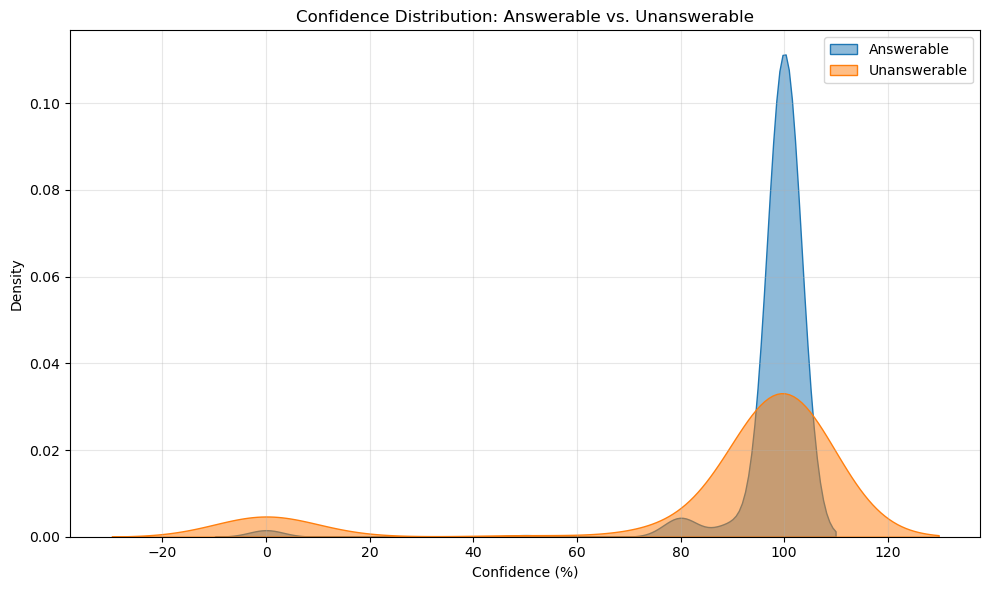

=== SQuAD: Answerable vs Unanswerable Comparison ===
        Type  Count  Accuracy  Avg Confidence   ECE  AUROC
  Answerable    638     0.868          97.633 0.124  0.573
Unanswerable    362     0.000          86.616 0.866    NaN

=== Common Responses for Unanswerable Questions ===
parsed_answer
none                 9
never                5
2007                 2
september 2003       2
19th century         2
none specified       2
exposure to light    1
their songs          1
antisymmetric        1
eritrea              1
Name: count, dtype: int64


In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Filter SQuAD data into answerable and unanswerable sets
answerable_mask = ~df_squad_all['is_impossible']
unanswerable_mask = df_squad_all['is_impossible']

# Create valid sets for both
answerable_valid = df_squad_all[answerable_mask].dropna(subset=["parsed_confidence", "is_correct"])
unanswerable_valid = df_squad_all[unanswerable_mask].dropna(subset=["parsed_confidence", "is_correct"])

# Calculate key metrics for both sets
metrics = []
for name, data in [("Answerable", answerable_valid), ("Unanswerable", unanswerable_valid)]:
    metrics.append({
        "Type": name,
        "Count": len(data),
        "Accuracy": data['is_correct'].mean(),
        "Avg Confidence": data['parsed_confidence'].mean(),
        "ECE": calculate_ece(data, confidence_col='parsed_confidence', correct_col='is_correct', n_bins=10),
        "AUROC": calculate_auroc(data, confidence_col='parsed_confidence', correct_col='is_correct', plot=False)
    })

# Create comparison dataframe
metrics_df = pd.DataFrame(metrics)

# Visualize the comparison
plt.figure(figsize=(10, 6))

# Confidence distributions with KDE
sns.kdeplot(answerable_valid['parsed_confidence'], label='Answerable', shade=True, alpha=0.5)
sns.kdeplot(unanswerable_valid['parsed_confidence'], label='Unanswerable', shade=True, alpha=0.5)
plt.xlabel('Confidence (%)')
plt.ylabel('Density')
plt.title('Confidence Distribution: Answerable vs. Unanswerable')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/squad_answerable_vs_unanswerable.png", dpi=150)
plt.show()

# Print summary statistics
print("=== SQuAD: Answerable vs Unanswerable Comparison ===")
print(metrics_df.to_string(index=False, float_format=lambda x: f"{x:.3f}" if x < 100 else f"{x:.1f}"))

# Analysis of answer patterns for unanswerable questions
if 'parsed_answer' in unanswerable_valid.columns:
    print("\n=== Common Responses for Unanswerable Questions ===")
    common_responses = unanswerable_valid['parsed_answer'].value_counts().head(10)
    print(common_responses)
    
    # Check correct responses for unanswerable questions
    correct_unans = unanswerable_valid[unanswerable_valid['is_correct']]
    if len(correct_unans) > 0:
        print("\n=== Correct Responses for Unanswerable Questions ===")
        correct_resp = correct_unans['parsed_answer'].value_counts().head(5)
        print(correct_resp)


# Joint calibration plots

C:\Users\Chris\AppData\Local\Temp\ipykernel_18268\1178930972.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = valid_data_copy.groupby("conf_bin").agg(
C:\Users\Chris\AppData\Local\Temp\ipykernel_18268\1178930972.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = valid_data_copy.groupby("conf_bin").agg(
C:\Users\Chris\AppData\Local\Temp\ipykernel_18268\1178930972.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence 

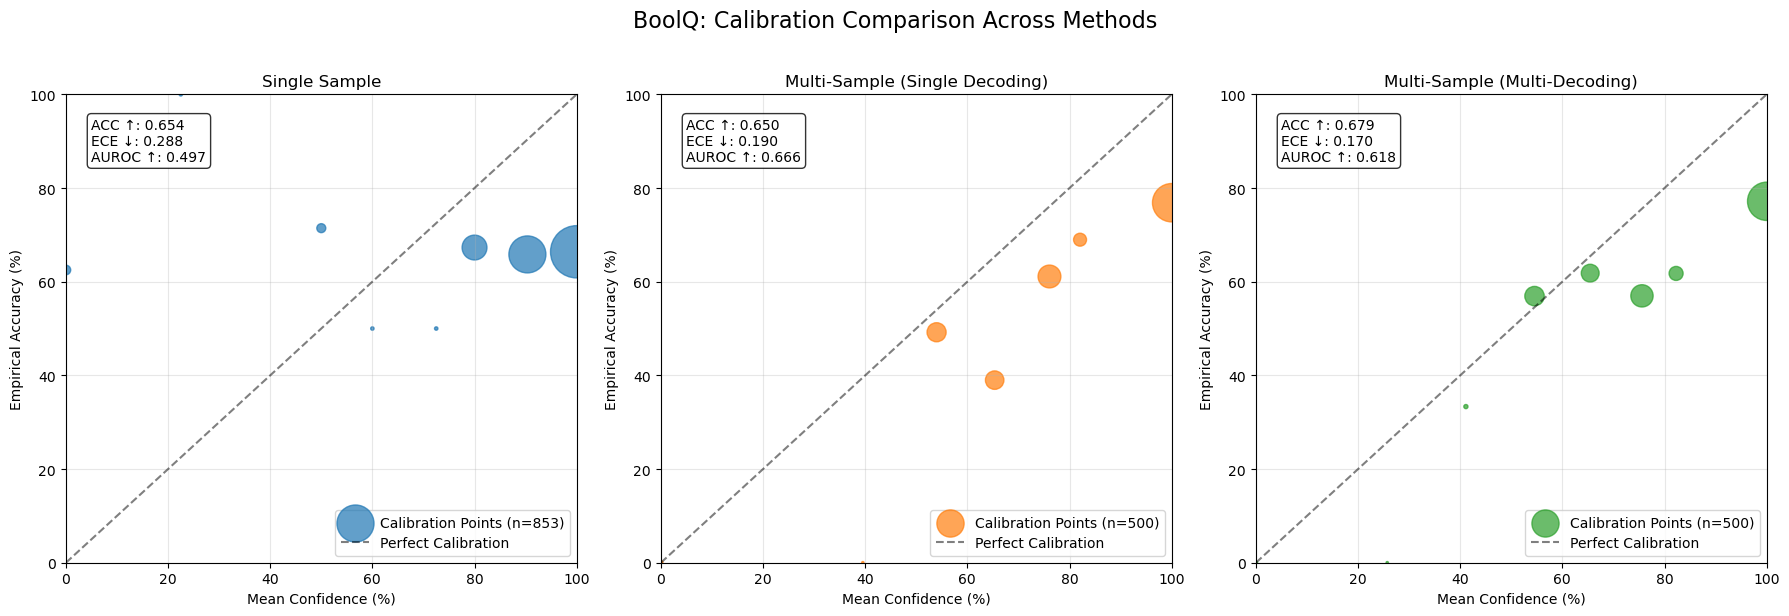

C:\Users\Chris\AppData\Local\Temp\ipykernel_18268\1178930972.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = valid_data_copy.groupby("conf_bin").agg(
C:\Users\Chris\AppData\Local\Temp\ipykernel_18268\1178930972.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = valid_data_copy.groupby("conf_bin").agg(
C:\Users\Chris\AppData\Local\Temp\ipykernel_18268\1178930972.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence 

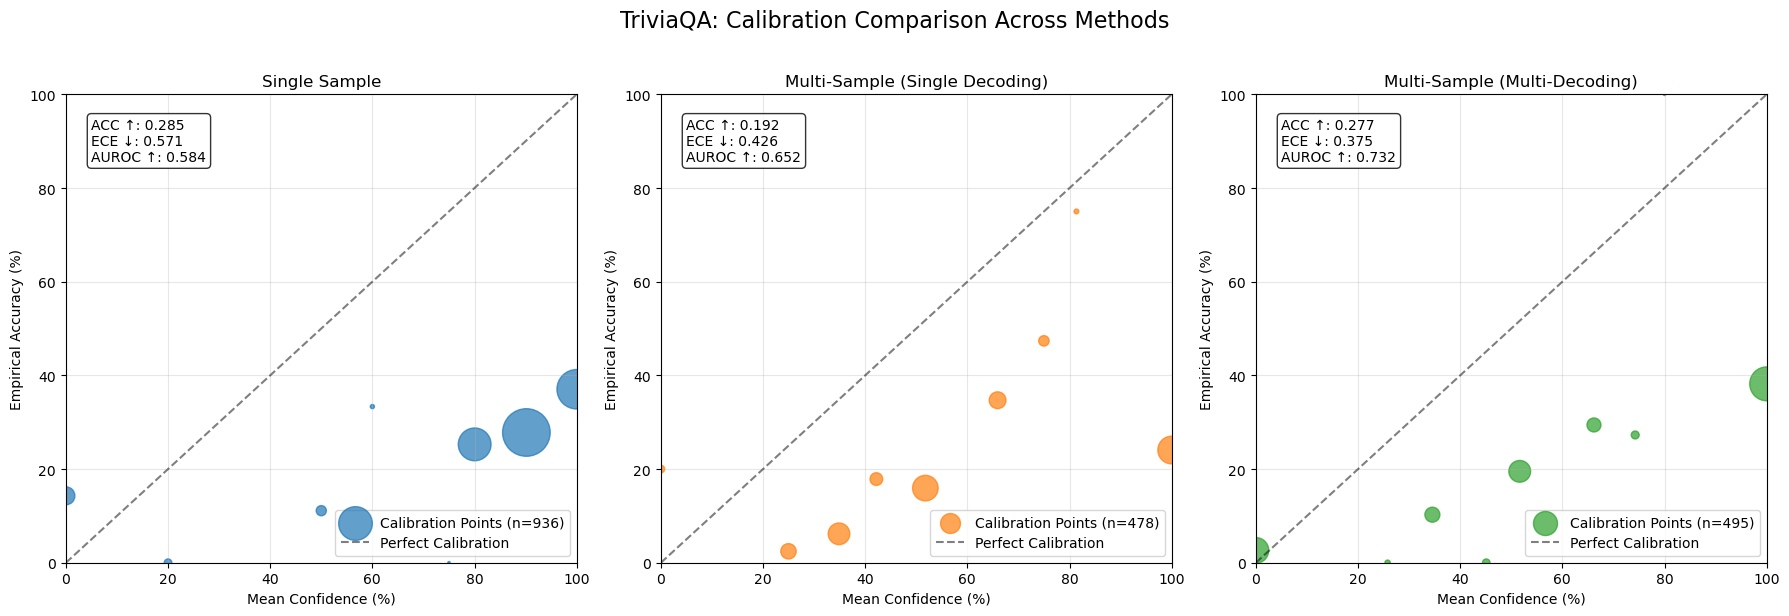

C:\Users\Chris\AppData\Local\Temp\ipykernel_18268\1178930972.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = valid_data_copy.groupby("conf_bin").agg(
C:\Users\Chris\AppData\Local\Temp\ipykernel_18268\1178930972.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = valid_data_copy.groupby("conf_bin").agg(
C:\Users\Chris\AppData\Local\Temp\ipykernel_18268\1178930972.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence 

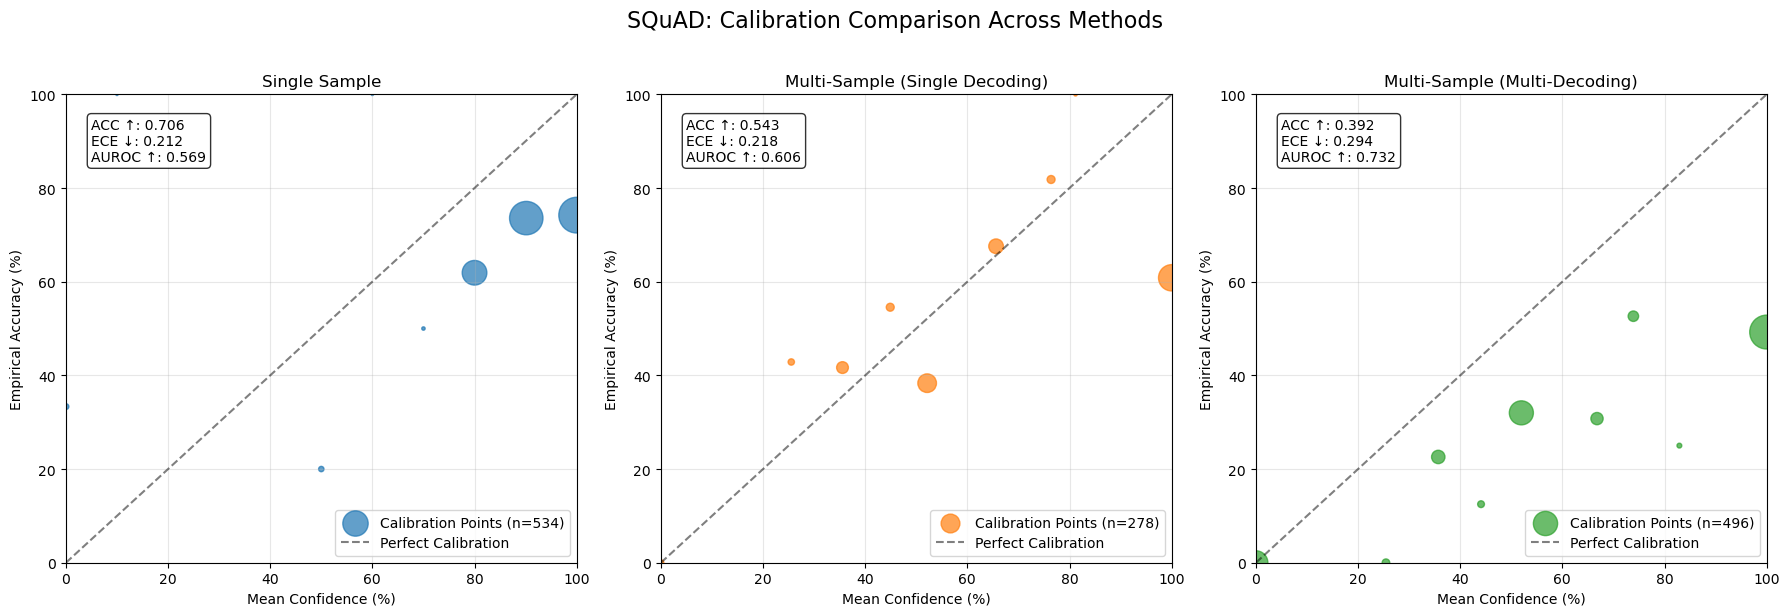

In [105]:
# Create calibration plots comparing all three methods for each dataset
datasets_config = {
    'BoolQ': {
        'single': (df_valid_boolq, 'parsed_confidence'),
        'multi_single': (eval_df_boolq_agg, 'agg_confidence'),
        'multi_multi': (eval_df_boolq_multi_dec, 'agg_confidence')
    },
    'TriviaQA': {
        'single': (df_trivia_valid, 'parsed_confidence'),
        'multi_single': (valid_agg_trivia, 'agg_confidence'),
        'multi_multi': (eval_df_trivia_multi_dec, 'agg_confidence')
    },
    'SQuAD': {
        'single': (df_squad_answerable_valid, 'parsed_confidence'),
        'multi_single': (valid_agg_squad, 'agg_confidence'),
        'multi_multi': (eval_df_squad_multi_dec, 'agg_confidence')
    }
}

method_labels = {
    'single': 'Single Sample',
    'multi_single': 'Multi-Sample (Single Decoding)',
    'multi_multi': 'Multi-Sample (Multi-Decoding)'
}

method_colors = {
    'single': '#1f77b4',
    'multi_single': '#ff7f0e', 
    'multi_multi': '#2ca02c'
}

# Create metrics dictionary for easy lookup
metrics_dict = {}
for _, row in df_comparison.iterrows():
    metrics_dict[(row['Dataset'], row['Method'])] = {
        'ACC': row['Accuracy'],
        'ECE': row['ECE'],
        'AUROC': row['AUROC']
    }

# Create separate figures for each dataset with all three methods
for dataset_name, dataset_config in datasets_config.items():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot each method separately
    for idx, (method_key, (data, conf_col)) in enumerate(dataset_config.items()):
        ax = axes[idx]
        
        # Filter valid data
        valid_data = data.dropna(subset=[conf_col, "is_correct"])
        
        if len(valid_data) > 0:
            # Create confidence bins
            conf_bins = np.arange(0, 111, 10)
            valid_data_copy = valid_data.copy()
            valid_data_copy["conf_bin"] = pd.cut(valid_data_copy[conf_col], bins=conf_bins, right=False)
            
            # Calculate calibration statistics
            calib = valid_data_copy.groupby("conf_bin").agg(
                mean_conf=(conf_col, "mean"),
                accuracy=("is_correct", "mean"),
                count=("is_correct", "count")
            ).dropna()
            
            # Plot calibration curve
            scatter = ax.scatter(calib["mean_conf"], calib["accuracy"]*100, 
                               s=calib["count"]*3, alpha=0.7, 
                               color=method_colors[method_key],
                               label=f'Calibration Points (n={len(valid_data)})')
        
        # Add perfect calibration line
        ax.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Perfect Calibration')
        
        # Get metrics for this method and dataset
        method_label = method_labels[method_key]
        metrics = metrics_dict[(dataset_name, method_label)]
        
        # Add metrics text
        metrics_text = f"ACC ↑: {metrics['ACC']:.3f}\nECE ↓: {metrics['ECE']:.3f}\nAUROC ↑: {metrics['AUROC']:.3f}"
        ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Formatting
        ax.set_xlabel("Mean Confidence (%)")
        ax.set_ylabel("Empirical Accuracy (%)")
        ax.set_title(f"{method_label}")
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
    
    # Overall figure title
    fig.suptitle(f"{dataset_name}: Calibration Comparison Across Methods", fontsize=16, y=1.02)
    
    plt.tight_layout()
    plt.savefig(f"figures/metrics/confidence_elicitation/{dataset_name.lower()}_calibration_methods_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()